In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_CAP_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(491695, 829)
(491695, 8)
validation
(85893, 829)
(85893, 8)
test
(41645, 829)
(41645, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1539976 (5.87 MB)


Trainable params: 1539976 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/50 [..............................] - ETA: 1:24 - loss: 2.6210 - STD: 0.0563 - MAE: 0.2288

 4/50 [=>............................] - ETA: 1s - loss: 1.9635 - STD: 0.0688 - MAE: 0.2055  

 6/50 [==>...........................] - ETA: 1s - loss: 1.7737 - STD: 0.1076 - MAE: 0.1872

 8/50 [===>..........................] - ETA: 1s - loss: 1.6823 - STD: 0.1379 - MAE: 0.1742

 9/50 [====>.........................] - ETA: 1s - loss: 1.6532 - STD: 0.1488 - MAE: 0.1695

11/50 [=====>........................] - ETA: 1s - loss: 1.6066 - STD: 0.1636 - MAE: 0.1630

12/50 [======>.......................] - ETA: 1s - loss: 1.5891 - STD: 0.1681 - MAE: 0.1609

13/50 [======>.......................] - ETA: 1s - loss: 1.5731 - STD: 0.1712 - MAE: 0.1595

14/50 [=======>......................] - ETA: 1s - loss: 1.5596 - STD: 0.1730 - MAE: 0.1585

15/50 [========>.....................] - ETA: 1s - loss: 1.5478 - STD: 0.1741 - MAE: 0.1579

16/50 [========>.....................] - ETA: 1s - loss: 1.5381 - STD: 0.1747 - MAE: 0.1575

17/50 [=========>....................] - ETA: 1s - loss: 1.5313 - STD: 0.1749 - MAE: 0.1573

18/50 [=========>....................] - ETA: 1s - loss: 1.5237 - STD: 0.1751 - MAE: 0.1571

19/50 [==========>...................] - ETA: 2s - loss: 1.5227 - STD: 0.1753 - MAE: 0.1569

22/50 [============>.................] - ETA: 2s - loss: 1.5033 - STD: 0.1764 - MAE: 0.1561

24/50 [=============>................] - ETA: 1s - loss: 1.4933 - STD: 0.1778 - MAE: 0.1555

26/50 [==============>...............] - ETA: 1s - loss: 1.4834 - STD: 0.1793 - MAE: 0.1547

27/50 [===============>..............] - ETA: 1s - loss: 1.4792 - STD: 0.1800 - MAE: 0.1544

28/50 [===============>..............] - ETA: 1s - loss: 1.4754 - STD: 0.1807 - MAE: 0.1541

29/50 [================>.............] - ETA: 1s - loss: 1.4720 - STD: 0.1812 - MAE: 0.1539

30/50 [=================>............] - ETA: 1s - loss: 1.4677 - STD: 0.1816 - MAE: 0.1536

31/50 [=================>............] - ETA: 1s - loss: 1.4646 - STD: 0.1819 - MAE: 0.1534

32/50 [==================>...........] - ETA: 1s - loss: 1.4606 - STD: 0.1821 - MAE: 0.1532

33/50 [==================>...........] - ETA: 1s - loss: 1.4580 - STD: 0.1822 - MAE: 0.1532

34/50 [===================>..........] - ETA: 1s - loss: 1.4552 - STD: 0.1823 - MAE: 0.1531

35/50 [====================>.........] - ETA: 1s - loss: 1.4524 - STD: 0.1822 - MAE: 0.1531

36/50 [====================>.........] - ETA: 0s - loss: 1.4503 - STD: 0.1821 - MAE: 0.1531

37/50 [=====================>........] - ETA: 0s - loss: 1.4485 - STD: 0.1820 - MAE: 0.1531

38/50 [=====================>........] - ETA: 0s - loss: 1.4466 - STD: 0.1819 - MAE: 0.1531

40/50 [=======================>......] - ETA: 0s - loss: 1.4435 - STD: 0.1817 - MAE: 0.1532

41/50 [=======================>......] - ETA: 0s - loss: 1.4417 - STD: 0.1816 - MAE: 0.1532

42/50 [========================>.....] - ETA: 0s - loss: 1.4398 - STD: 0.1816 - MAE: 0.1532

43/50 [========================>.....] - ETA: 0s - loss: 1.4382 - STD: 0.1816 - MAE: 0.1531

44/50 [=========================>....] - ETA: 0s - loss: 1.4364 - STD: 0.1816 - MAE: 0.1531

45/50 [==========================>...] - ETA: 0s - loss: 1.4346 - STD: 0.1817 - MAE: 0.1530

46/50 [==========================>...] - ETA: 0s - loss: 1.4328 - STD: 0.1818 - MAE: 0.1529

47/50 [===========================>..] - ETA: 0s - loss: 1.4312 - STD: 0.1819 - MAE: 0.1529

48/50 [===========================>..] - ETA: 0s - loss: 1.4299 - STD: 0.1821 - MAE: 0.1528

49/50 [============================>.] - ETA: 0s - loss: 1.4285 - STD: 0.1822 - MAE: 0.1527

50/50 [==============================] - 6s 80ms/step - loss: 1.4273 - STD: 0.1823 - MAE: 0.1527 - val_loss: 1.3257 - val_STD: 0.1873 - val_MAE: 0.1476


Epoch 2/10000


 1/50 [..............................] - ETA: 4s - loss: 1.3735 - STD: 0.1873 - MAE: 0.1503

 2/50 [>.............................] - ETA: 2s - loss: 1.3695 - STD: 0.1868 - MAE: 0.1504

 3/50 [>.............................] - ETA: 2s - loss: 1.3662 - STD: 0.1861 - MAE: 0.1504

 4/50 [=>............................] - ETA: 2s - loss: 1.3656 - STD: 0.1855 - MAE: 0.1506

 5/50 [==>...........................] - ETA: 2s - loss: 1.3634 - STD: 0.1849 - MAE: 0.1506

 6/50 [==>...........................] - ETA: 2s - loss: 1.3637 - STD: 0.1845 - MAE: 0.1508

 7/50 [===>..........................] - ETA: 2s - loss: 1.3626 - STD: 0.1841 - MAE: 0.1509

 8/50 [===>..........................] - ETA: 2s - loss: 1.3653 - STD: 0.1839 - MAE: 0.1511

 9/50 [====>.........................] - ETA: 2s - loss: 1.3649 - STD: 0.1837 - MAE: 0.1512

10/50 [=====>........................] - ETA: 2s - loss: 1.3649 - STD: 0.1836 - MAE: 0.1512

11/50 [=====>........................] - ETA: 2s - loss: 1.3641 - STD: 0.1835 - MAE: 0.1512

12/50 [======>.......................] - ETA: 2s - loss: 1.3656 - STD: 0.1835 - MAE: 0.1513

13/50 [======>.......................] - ETA: 2s - loss: 1.3639 - STD: 0.1836 - MAE: 0.1512

14/50 [=======>......................] - ETA: 2s - loss: 1.3634 - STD: 0.1836 - MAE: 0.1511

15/50 [========>.....................] - ETA: 1s - loss: 1.3649 - STD: 0.1837 - MAE: 0.1512

16/50 [========>.....................] - ETA: 1s - loss: 1.3648 - STD: 0.1838 - MAE: 0.1511

17/50 [=========>....................] - ETA: 1s - loss: 1.3638 - STD: 0.1839 - MAE: 0.1510

18/50 [=========>....................] - ETA: 1s - loss: 1.3642 - STD: 0.1840 - MAE: 0.1510

19/50 [==========>...................] - ETA: 1s - loss: 1.3637 - STD: 0.1840 - MAE: 0.1510

20/50 [===========>..................] - ETA: 1s - loss: 1.3640 - STD: 0.1841 - MAE: 0.1510

21/50 [===========>..................] - ETA: 1s - loss: 1.3641 - STD: 0.1841 - MAE: 0.1509

22/50 [============>.................] - ETA: 1s - loss: 1.3630 - STD: 0.1841 - MAE: 0.1509

23/50 [============>.................] - ETA: 1s - loss: 1.3618 - STD: 0.1842 - MAE: 0.1508

24/50 [=============>................] - ETA: 1s - loss: 1.3614 - STD: 0.1842 - MAE: 0.1508

25/50 [==============>...............] - ETA: 1s - loss: 1.3605 - STD: 0.1842 - MAE: 0.1507

26/50 [==============>...............] - ETA: 1s - loss: 1.3606 - STD: 0.1843 - MAE: 0.1507

27/50 [===============>..............] - ETA: 1s - loss: 1.3604 - STD: 0.1844 - MAE: 0.1506

29/50 [================>.............] - ETA: 1s - loss: 1.3605 - STD: 0.1845 - MAE: 0.1506

30/50 [=================>............] - ETA: 1s - loss: 1.3608 - STD: 0.1846 - MAE: 0.1506

31/50 [=================>............] - ETA: 1s - loss: 1.3619 - STD: 0.1846 - MAE: 0.1506

32/50 [==================>...........] - ETA: 0s - loss: 1.3618 - STD: 0.1846 - MAE: 0.1506

33/50 [==================>...........] - ETA: 0s - loss: 1.3622 - STD: 0.1846 - MAE: 0.1507

34/50 [===================>..........] - ETA: 0s - loss: 1.3627 - STD: 0.1845 - MAE: 0.1507

35/50 [====================>.........] - ETA: 0s - loss: 1.3628 - STD: 0.1844 - MAE: 0.1508

36/50 [====================>.........] - ETA: 0s - loss: 1.3623 - STD: 0.1843 - MAE: 0.1508

37/50 [=====================>........] - ETA: 0s - loss: 1.3626 - STD: 0.1842 - MAE: 0.1508

38/50 [=====================>........] - ETA: 0s - loss: 1.3624 - STD: 0.1841 - MAE: 0.1509

39/50 [======================>.......] - ETA: 0s - loss: 1.3621 - STD: 0.1840 - MAE: 0.1509

40/50 [=======================>......] - ETA: 0s - loss: 1.3617 - STD: 0.1840 - MAE: 0.1509

41/50 [=======================>......] - ETA: 0s - loss: 1.3620 - STD: 0.1840 - MAE: 0.1509

42/50 [========================>.....] - ETA: 0s - loss: 1.3619 - STD: 0.1840 - MAE: 0.1509

43/50 [========================>.....] - ETA: 0s - loss: 1.3622 - STD: 0.1841 - MAE: 0.1509

44/50 [=========================>....] - ETA: 0s - loss: 1.3622 - STD: 0.1841 - MAE: 0.1509

45/50 [==========================>...] - ETA: 0s - loss: 1.3624 - STD: 0.1842 - MAE: 0.1508

46/50 [==========================>...] - ETA: 0s - loss: 1.3624 - STD: 0.1842 - MAE: 0.1508

47/50 [===========================>..] - ETA: 0s - loss: 1.3623 - STD: 0.1843 - MAE: 0.1508

48/50 [===========================>..] - ETA: 0s - loss: 1.3623 - STD: 0.1843 - MAE: 0.1508

49/50 [============================>.] - ETA: 0s - loss: 1.3625 - STD: 0.1843 - MAE: 0.1508

50/50 [==============================] - ETA: 0s - loss: 1.3629 - STD: 0.1843 - MAE: 0.1508

50/50 [==============================] - 3s 57ms/step - loss: 1.3629 - STD: 0.1843 - MAE: 0.1508 - val_loss: 1.3284 - val_STD: 0.1828 - val_MAE: 0.1493


Epoch 3/10000


 1/50 [..............................] - ETA: 4s - loss: 1.3638 - STD: 0.1828 - MAE: 0.1517

 2/50 [>.............................] - ETA: 2s - loss: 1.3591 - STD: 0.1825 - MAE: 0.1514

 3/50 [>.............................] - ETA: 2s - loss: 1.3628 - STD: 0.1823 - MAE: 0.1516

 4/50 [=>............................] - ETA: 2s - loss: 1.3670 - STD: 0.1823 - MAE: 0.1520

 5/50 [==>...........................] - ETA: 2s - loss: 1.3627 - STD: 0.1822 - MAE: 0.1517

 6/50 [==>...........................] - ETA: 2s - loss: 1.3644 - STD: 0.1822 - MAE: 0.1518

 7/50 [===>..........................] - ETA: 2s - loss: 1.3651 - STD: 0.1823 - MAE: 0.1518

 8/50 [===>..........................] - ETA: 2s - loss: 1.3652 - STD: 0.1825 - MAE: 0.1517

 9/50 [====>.........................] - ETA: 2s - loss: 1.3652 - STD: 0.1827 - MAE: 0.1516

10/50 [=====>........................] - ETA: 2s - loss: 1.3649 - STD: 0.1829 - MAE: 0.1515

11/50 [=====>........................] - ETA: 2s - loss: 1.3658 - STD: 0.1831 - MAE: 0.1514

12/50 [======>.......................] - ETA: 2s - loss: 1.3672 - STD: 0.1833 - MAE: 0.1515

13/50 [======>.......................] - ETA: 2s - loss: 1.3671 - STD: 0.1835 - MAE: 0.1514

14/50 [=======>......................] - ETA: 2s - loss: 1.3667 - STD: 0.1836 - MAE: 0.1514

15/50 [========>.....................] - ETA: 1s - loss: 1.3670 - STD: 0.1836 - MAE: 0.1514

16/50 [========>.....................] - ETA: 1s - loss: 1.3678 - STD: 0.1835 - MAE: 0.1514

17/50 [=========>....................] - ETA: 1s - loss: 1.3676 - STD: 0.1834 - MAE: 0.1514

18/50 [=========>....................] - ETA: 1s - loss: 1.3668 - STD: 0.1834 - MAE: 0.1514

19/50 [==========>...................] - ETA: 1s - loss: 1.3659 - STD: 0.1833 - MAE: 0.1514

20/50 [===========>..................] - ETA: 1s - loss: 1.3658 - STD: 0.1833 - MAE: 0.1514

21/50 [===========>..................] - ETA: 1s - loss: 1.3662 - STD: 0.1833 - MAE: 0.1514

22/50 [============>.................] - ETA: 1s - loss: 1.3653 - STD: 0.1834 - MAE: 0.1513

23/50 [============>.................] - ETA: 1s - loss: 1.3635 - STD: 0.1835 - MAE: 0.1512

24/50 [=============>................] - ETA: 1s - loss: 1.3638 - STD: 0.1836 - MAE: 0.1512

25/50 [==============>...............] - ETA: 1s - loss: 1.3641 - STD: 0.1837 - MAE: 0.1512

27/50 [===============>..............] - ETA: 1s - loss: 1.3640 - STD: 0.1838 - MAE: 0.1511

28/50 [===============>..............] - ETA: 1s - loss: 1.3640 - STD: 0.1839 - MAE: 0.1510

29/50 [================>.............] - ETA: 1s - loss: 1.3644 - STD: 0.1839 - MAE: 0.1510

30/50 [=================>............] - ETA: 1s - loss: 1.3644 - STD: 0.1839 - MAE: 0.1510

31/50 [=================>............] - ETA: 1s - loss: 1.3640 - STD: 0.1840 - MAE: 0.1510

32/50 [==================>...........] - ETA: 0s - loss: 1.3643 - STD: 0.1840 - MAE: 0.1510

33/50 [==================>...........] - ETA: 0s - loss: 1.3641 - STD: 0.1840 - MAE: 0.1510

34/50 [===================>..........] - ETA: 0s - loss: 1.3641 - STD: 0.1840 - MAE: 0.1510

35/50 [====================>.........] - ETA: 0s - loss: 1.3645 - STD: 0.1840 - MAE: 0.1510

36/50 [====================>.........] - ETA: 0s - loss: 1.3641 - STD: 0.1840 - MAE: 0.1510

37/50 [=====================>........] - ETA: 0s - loss: 1.3640 - STD: 0.1840 - MAE: 0.1510

38/50 [=====================>........] - ETA: 0s - loss: 1.3638 - STD: 0.1840 - MAE: 0.1510

39/50 [======================>.......] - ETA: 0s - loss: 1.3641 - STD: 0.1840 - MAE: 0.1510

40/50 [=======================>......] - ETA: 0s - loss: 1.3639 - STD: 0.1840 - MAE: 0.1510

41/50 [=======================>......] - ETA: 0s - loss: 1.3633 - STD: 0.1840 - MAE: 0.1509

42/50 [========================>.....] - ETA: 0s - loss: 1.3630 - STD: 0.1840 - MAE: 0.1509

43/50 [========================>.....] - ETA: 0s - loss: 1.3633 - STD: 0.1840 - MAE: 0.1509

44/50 [=========================>....] - ETA: 0s - loss: 1.3628 - STD: 0.1840 - MAE: 0.1509

45/50 [==========================>...] - ETA: 0s - loss: 1.3625 - STD: 0.1840 - MAE: 0.1509

46/50 [==========================>...] - ETA: 0s - loss: 1.3624 - STD: 0.1841 - MAE: 0.1509

47/50 [===========================>..] - ETA: 0s - loss: 1.3626 - STD: 0.1841 - MAE: 0.1509

48/50 [===========================>..] - ETA: 0s - loss: 1.3626 - STD: 0.1842 - MAE: 0.1508

49/50 [============================>.] - ETA: 0s - loss: 1.3625 - STD: 0.1842 - MAE: 0.1508

50/50 [==============================] - ETA: 0s - loss: 1.3626 - STD: 0.1843 - MAE: 0.1508

50/50 [==============================] - 3s 57ms/step - loss: 1.3626 - STD: 0.1843 - MAE: 0.1508 - val_loss: 1.3260 - val_STD: 0.1852 - val_MAE: 0.1483


Epoch 4/10000


 1/50 [..............................] - ETA: 4s - loss: 1.3641 - STD: 0.1853 - MAE: 0.1507

 2/50 [>.............................] - ETA: 2s - loss: 1.3625 - STD: 0.1849 - MAE: 0.1506

 3/50 [>.............................] - ETA: 2s - loss: 1.3614 - STD: 0.1846 - MAE: 0.1507

 4/50 [=>............................] - ETA: 2s - loss: 1.3590 - STD: 0.1843 - MAE: 0.1507

 5/50 [==>...........................] - ETA: 2s - loss: 1.3551 - STD: 0.1842 - MAE: 0.1505

 6/50 [==>...........................] - ETA: 2s - loss: 1.3574 - STD: 0.1842 - MAE: 0.1506

 7/50 [===>..........................] - ETA: 2s - loss: 1.3591 - STD: 0.1843 - MAE: 0.1506

 8/50 [===>..........................] - ETA: 2s - loss: 1.3615 - STD: 0.1844 - MAE: 0.1507

 9/50 [====>.........................] - ETA: 2s - loss: 1.3627 - STD: 0.1845 - MAE: 0.1507

10/50 [=====>........................] - ETA: 2s - loss: 1.3634 - STD: 0.1844 - MAE: 0.1508

11/50 [=====>........................] - ETA: 2s - loss: 1.3629 - STD: 0.1843 - MAE: 0.1508

12/50 [======>.......................] - ETA: 2s - loss: 1.3642 - STD: 0.1842 - MAE: 0.1509

13/50 [======>.......................] - ETA: 2s - loss: 1.3629 - STD: 0.1840 - MAE: 0.1509

14/50 [=======>......................] - ETA: 2s - loss: 1.3609 - STD: 0.1839 - MAE: 0.1509

15/50 [========>.....................] - ETA: 2s - loss: 1.3618 - STD: 0.1838 - MAE: 0.1509

16/50 [========>.....................] - ETA: 1s - loss: 1.3627 - STD: 0.1839 - MAE: 0.1509

17/50 [=========>....................] - ETA: 1s - loss: 1.3622 - STD: 0.1839 - MAE: 0.1509

18/50 [=========>....................] - ETA: 1s - loss: 1.3620 - STD: 0.1840 - MAE: 0.1508

19/50 [==========>...................] - ETA: 1s - loss: 1.3623 - STD: 0.1841 - MAE: 0.1508

20/50 [===========>..................] - ETA: 1s - loss: 1.3626 - STD: 0.1841 - MAE: 0.1509

21/50 [===========>..................] - ETA: 1s - loss: 1.3622 - STD: 0.1841 - MAE: 0.1508

22/50 [============>.................] - ETA: 1s - loss: 1.3621 - STD: 0.1840 - MAE: 0.1508

23/50 [============>.................] - ETA: 1s - loss: 1.3609 - STD: 0.1840 - MAE: 0.1508

24/50 [=============>................] - ETA: 1s - loss: 1.3600 - STD: 0.1840 - MAE: 0.1508

25/50 [==============>...............] - ETA: 1s - loss: 1.3598 - STD: 0.1840 - MAE: 0.1508

26/50 [==============>...............] - ETA: 1s - loss: 1.3591 - STD: 0.1840 - MAE: 0.1507

27/50 [===============>..............] - ETA: 1s - loss: 1.3588 - STD: 0.1840 - MAE: 0.1507

28/50 [===============>..............] - ETA: 1s - loss: 1.3595 - STD: 0.1841 - MAE: 0.1507

29/50 [================>.............] - ETA: 1s - loss: 1.3596 - STD: 0.1841 - MAE: 0.1507

30/50 [=================>............] - ETA: 1s - loss: 1.3592 - STD: 0.1841 - MAE: 0.1507

31/50 [=================>............] - ETA: 1s - loss: 1.3588 - STD: 0.1841 - MAE: 0.1507

32/50 [==================>...........] - ETA: 1s - loss: 1.3583 - STD: 0.1841 - MAE: 0.1506

33/50 [==================>...........] - ETA: 0s - loss: 1.3575 - STD: 0.1841 - MAE: 0.1506

35/50 [====================>.........] - ETA: 0s - loss: 1.3571 - STD: 0.1842 - MAE: 0.1505

36/50 [====================>.........] - ETA: 0s - loss: 1.3570 - STD: 0.1842 - MAE: 0.1504

37/50 [=====================>........] - ETA: 0s - loss: 1.3562 - STD: 0.1843 - MAE: 0.1504

38/50 [=====================>........] - ETA: 0s - loss: 1.3564 - STD: 0.1843 - MAE: 0.1504

39/50 [======================>.......] - ETA: 0s - loss: 1.3561 - STD: 0.1843 - MAE: 0.1504

40/50 [=======================>......] - ETA: 0s - loss: 1.3566 - STD: 0.1843 - MAE: 0.1504

41/50 [=======================>......] - ETA: 0s - loss: 1.3558 - STD: 0.1842 - MAE: 0.1504

42/50 [========================>.....] - ETA: 0s - loss: 1.3550 - STD: 0.1842 - MAE: 0.1503

43/50 [========================>.....] - ETA: 0s - loss: 1.3545 - STD: 0.1842 - MAE: 0.1503

44/50 [=========================>....] - ETA: 0s - loss: 1.3540 - STD: 0.1842 - MAE: 0.1502

45/50 [==========================>...] - ETA: 0s - loss: 1.3536 - STD: 0.1843 - MAE: 0.1502

46/50 [==========================>...] - ETA: 0s - loss: 1.3528 - STD: 0.1842 - MAE: 0.1502

47/50 [===========================>..] - ETA: 0s - loss: 1.3522 - STD: 0.1842 - MAE: 0.1501

48/50 [===========================>..] - ETA: 0s - loss: 1.3515 - STD: 0.1842 - MAE: 0.1501

49/50 [============================>.] - ETA: 0s - loss: 1.3507 - STD: 0.1843 - MAE: 0.1500

50/50 [==============================] - ETA: 0s - loss: 1.3502 - STD: 0.1844 - MAE: 0.1499

50/50 [==============================] - 3s 63ms/step - loss: 1.3502 - STD: 0.1844 - MAE: 0.1499 - val_loss: 1.2809 - val_STD: 0.1857 - val_MAE: 0.1449


Epoch 5/10000


 1/50 [..............................] - ETA: 4s - loss: 1.3063 - STD: 0.1886 - MAE: 0.1457

 2/50 [>.............................] - ETA: 2s - loss: 1.3099 - STD: 0.1876 - MAE: 0.1463

 3/50 [>.............................] - ETA: 2s - loss: 1.3105 - STD: 0.1867 - MAE: 0.1466

 4/50 [=>............................] - ETA: 2s - loss: 1.3112 - STD: 0.1861 - MAE: 0.1468

 5/50 [==>...........................] - ETA: 2s - loss: 1.3108 - STD: 0.1864 - MAE: 0.1467

 6/50 [==>...........................] - ETA: 2s - loss: 1.3104 - STD: 0.1870 - MAE: 0.1464

 7/50 [===>..........................] - ETA: 2s - loss: 1.3049 - STD: 0.1873 - MAE: 0.1460

 8/50 [===>..........................] - ETA: 2s - loss: 1.3063 - STD: 0.1875 - MAE: 0.1460

 9/50 [====>.........................] - ETA: 2s - loss: 1.3044 - STD: 0.1874 - MAE: 0.1460

10/50 [=====>........................] - ETA: 2s - loss: 1.3028 - STD: 0.1873 - MAE: 0.1459

11/50 [=====>........................] - ETA: 1s - loss: 1.3023 - STD: 0.1880 - MAE: 0.1456

13/50 [======>.......................] - ETA: 1s - loss: 1.3016 - STD: 0.1887 - MAE: 0.1452

14/50 [=======>......................] - ETA: 1s - loss: 1.3000 - STD: 0.1885 - MAE: 0.1452

15/50 [========>.....................] - ETA: 1s - loss: 1.2992 - STD: 0.1884 - MAE: 0.1452

16/50 [========>.....................] - ETA: 1s - loss: 1.2984 - STD: 0.1889 - MAE: 0.1449

18/50 [=========>....................] - ETA: 1s - loss: 1.2975 - STD: 0.1898 - MAE: 0.1444

19/50 [==========>...................] - ETA: 1s - loss: 1.2973 - STD: 0.1899 - MAE: 0.1443

20/50 [===========>..................] - ETA: 1s - loss: 1.2970 - STD: 0.1897 - MAE: 0.1444

21/50 [===========>..................] - ETA: 1s - loss: 1.2960 - STD: 0.1897 - MAE: 0.1443

22/50 [============>.................] - ETA: 1s - loss: 1.2948 - STD: 0.1902 - MAE: 0.1441

23/50 [============>.................] - ETA: 1s - loss: 1.2948 - STD: 0.1903 - MAE: 0.1440

24/50 [=============>................] - ETA: 1s - loss: 1.2939 - STD: 0.1898 - MAE: 0.1442

25/50 [==============>...............] - ETA: 1s - loss: 1.2930 - STD: 0.1898 - MAE: 0.1441

26/50 [==============>...............] - ETA: 1s - loss: 1.2923 - STD: 0.1905 - MAE: 0.1438

27/50 [===============>..............] - ETA: 1s - loss: 1.2917 - STD: 0.1908 - MAE: 0.1437

28/50 [===============>..............] - ETA: 1s - loss: 1.2914 - STD: 0.1904 - MAE: 0.1438

29/50 [================>.............] - ETA: 1s - loss: 1.2902 - STD: 0.1902 - MAE: 0.1438

30/50 [=================>............] - ETA: 1s - loss: 1.2894 - STD: 0.1908 - MAE: 0.1435

31/50 [=================>............] - ETA: 1s - loss: 1.2882 - STD: 0.1913 - MAE: 0.1433

32/50 [==================>...........] - ETA: 1s - loss: 1.2872 - STD: 0.1913 - MAE: 0.1432

33/50 [==================>...........] - ETA: 0s - loss: 1.2870 - STD: 0.1912 - MAE: 0.1432

34/50 [===================>..........] - ETA: 0s - loss: 1.2858 - STD: 0.1913 - MAE: 0.1431

35/50 [====================>.........] - ETA: 0s - loss: 1.2853 - STD: 0.1917 - MAE: 0.1429

36/50 [====================>.........] - ETA: 0s - loss: 1.2842 - STD: 0.1920 - MAE: 0.1428

37/50 [=====================>........] - ETA: 0s - loss: 1.2837 - STD: 0.1919 - MAE: 0.1428

38/50 [=====================>........] - ETA: 0s - loss: 1.2827 - STD: 0.1919 - MAE: 0.1427

39/50 [======================>.......] - ETA: 0s - loss: 1.2820 - STD: 0.1922 - MAE: 0.1425

40/50 [=======================>......] - ETA: 0s - loss: 1.2807 - STD: 0.1924 - MAE: 0.1424

41/50 [=======================>......] - ETA: 0s - loss: 1.2796 - STD: 0.1925 - MAE: 0.1423

42/50 [========================>.....] - ETA: 0s - loss: 1.2784 - STD: 0.1928 - MAE: 0.1421

43/50 [========================>.....] - ETA: 0s - loss: 1.2775 - STD: 0.1930 - MAE: 0.1420

44/50 [=========================>....] - ETA: 0s - loss: 1.2763 - STD: 0.1930 - MAE: 0.1419

45/50 [==========================>...] - ETA: 0s - loss: 1.2752 - STD: 0.1933 - MAE: 0.1417

46/50 [==========================>...] - ETA: 0s - loss: 1.2743 - STD: 0.1934 - MAE: 0.1416

47/50 [===========================>..] - ETA: 0s - loss: 1.2736 - STD: 0.1934 - MAE: 0.1416

48/50 [===========================>..] - ETA: 0s - loss: 1.2723 - STD: 0.1938 - MAE: 0.1414

49/50 [============================>.] - ETA: 0s - loss: 1.2715 - STD: 0.1938 - MAE: 0.1413

50/50 [==============================] - ETA: 0s - loss: 1.2709 - STD: 0.1940 - MAE: 0.1412

50/50 [==============================] - 3s 62ms/step - loss: 1.2709 - STD: 0.1940 - MAE: 0.1412 - val_loss: 1.2192 - val_STD: 0.2000 - val_MAE: 0.1342


Epoch 6/10000


 1/50 [..............................] - ETA: 4s - loss: 1.2307 - STD: 0.2035 - MAE: 0.1350

 2/50 [>.............................] - ETA: 2s - loss: 1.2351 - STD: 0.1994 - MAE: 0.1368

 3/50 [>.............................] - ETA: 2s - loss: 1.2379 - STD: 0.2052 - MAE: 0.1347

 4/50 [=>............................] - ETA: 2s - loss: 1.2430 - STD: 0.1975 - MAE: 0.1380

 5/50 [==>...........................] - ETA: 2s - loss: 1.2429 - STD: 0.2002 - MAE: 0.1370

 6/50 [==>...........................] - ETA: 2s - loss: 1.2404 - STD: 0.2027 - MAE: 0.1358

 7/50 [===>..........................] - ETA: 2s - loss: 1.2398 - STD: 0.2009 - MAE: 0.1365

 8/50 [===>..........................] - ETA: 2s - loss: 1.2378 - STD: 0.2003 - MAE: 0.1367

 9/50 [====>.........................] - ETA: 2s - loss: 1.2378 - STD: 0.2021 - MAE: 0.1360

10/50 [=====>........................] - ETA: 2s - loss: 1.2346 - STD: 0.2021 - MAE: 0.1359

11/50 [=====>........................] - ETA: 2s - loss: 1.2327 - STD: 0.2016 - MAE: 0.1360

12/50 [======>.......................] - ETA: 2s - loss: 1.2289 - STD: 0.2024 - MAE: 0.1355

13/50 [======>.......................] - ETA: 2s - loss: 1.2294 - STD: 0.2033 - MAE: 0.1352

14/50 [=======>......................] - ETA: 2s - loss: 1.2287 - STD: 0.2026 - MAE: 0.1354

15/50 [========>.....................] - ETA: 2s - loss: 1.2290 - STD: 0.2020 - MAE: 0.1357

16/50 [========>.....................] - ETA: 2s - loss: 1.2297 - STD: 0.2028 - MAE: 0.1354

17/50 [=========>....................] - ETA: 2s - loss: 1.2284 - STD: 0.2029 - MAE: 0.1353

18/50 [=========>....................] - ETA: 2s - loss: 1.2287 - STD: 0.2023 - MAE: 0.1355

19/50 [==========>...................] - ETA: 1s - loss: 1.2276 - STD: 0.2025 - MAE: 0.1354

20/50 [===========>..................] - ETA: 1s - loss: 1.2280 - STD: 0.2030 - MAE: 0.1352

21/50 [===========>..................] - ETA: 1s - loss: 1.2271 - STD: 0.2027 - MAE: 0.1353

22/50 [============>.................] - ETA: 1s - loss: 1.2267 - STD: 0.2026 - MAE: 0.1353

23/50 [============>.................] - ETA: 1s - loss: 1.2263 - STD: 0.2030 - MAE: 0.1352

24/50 [=============>................] - ETA: 1s - loss: 1.2255 - STD: 0.2029 - MAE: 0.1352

25/50 [==============>...............] - ETA: 1s - loss: 1.2243 - STD: 0.2029 - MAE: 0.1351

26/50 [==============>...............] - ETA: 1s - loss: 1.2241 - STD: 0.2032 - MAE: 0.1350

28/50 [===============>..............] - ETA: 1s - loss: 1.2232 - STD: 0.2031 - MAE: 0.1350

29/50 [================>.............] - ETA: 1s - loss: 1.2237 - STD: 0.2033 - MAE: 0.1349

30/50 [=================>............] - ETA: 1s - loss: 1.2236 - STD: 0.2032 - MAE: 0.1349

31/50 [=================>............] - ETA: 1s - loss: 1.2238 - STD: 0.2031 - MAE: 0.1350

32/50 [==================>...........] - ETA: 1s - loss: 1.2233 - STD: 0.2033 - MAE: 0.1349

33/50 [==================>...........] - ETA: 1s - loss: 1.2223 - STD: 0.2034 - MAE: 0.1348

34/50 [===================>..........] - ETA: 0s - loss: 1.2220 - STD: 0.2035 - MAE: 0.1347

35/50 [====================>.........] - ETA: 0s - loss: 1.2221 - STD: 0.2034 - MAE: 0.1348

36/50 [====================>.........] - ETA: 0s - loss: 1.2215 - STD: 0.2035 - MAE: 0.1348

37/50 [=====================>........] - ETA: 0s - loss: 1.2213 - STD: 0.2036 - MAE: 0.1347

38/50 [=====================>........] - ETA: 0s - loss: 1.2216 - STD: 0.2036 - MAE: 0.1347

39/50 [======================>.......] - ETA: 0s - loss: 1.2213 - STD: 0.2034 - MAE: 0.1348

40/50 [=======================>......] - ETA: 0s - loss: 1.2210 - STD: 0.2036 - MAE: 0.1347

41/50 [=======================>......] - ETA: 0s - loss: 1.2202 - STD: 0.2037 - MAE: 0.1346

42/50 [========================>.....] - ETA: 0s - loss: 1.2196 - STD: 0.2037 - MAE: 0.1346

43/50 [========================>.....] - ETA: 0s - loss: 1.2194 - STD: 0.2038 - MAE: 0.1346

44/50 [=========================>....] - ETA: 0s - loss: 1.2187 - STD: 0.2038 - MAE: 0.1345

45/50 [==========================>...] - ETA: 0s - loss: 1.2188 - STD: 0.2039 - MAE: 0.1345

46/50 [==========================>...] - ETA: 0s - loss: 1.2186 - STD: 0.2038 - MAE: 0.1346

47/50 [===========================>..] - ETA: 0s - loss: 1.2183 - STD: 0.2039 - MAE: 0.1345

48/50 [===========================>..] - ETA: 0s - loss: 1.2176 - STD: 0.2040 - MAE: 0.1344

49/50 [============================>.] - ETA: 0s - loss: 1.2171 - STD: 0.2041 - MAE: 0.1344

50/50 [==============================] - ETA: 0s - loss: 1.2168 - STD: 0.2040 - MAE: 0.1344

50/50 [==============================] - 3s 64ms/step - loss: 1.2168 - STD: 0.2040 - MAE: 0.1344 - val_loss: 1.2037 - val_STD: 0.2041 - val_MAE: 0.1318


Epoch 7/10000


 1/50 [..............................] - ETA: 4s - loss: 1.1907 - STD: 0.2079 - MAE: 0.1318

 2/50 [>.............................] - ETA: 3s - loss: 1.1908 - STD: 0.2101 - MAE: 0.1309

 3/50 [>.............................] - ETA: 3s - loss: 1.1932 - STD: 0.2082 - MAE: 0.1318

 4/50 [=>............................] - ETA: 2s - loss: 1.1938 - STD: 0.2068 - MAE: 0.1324

 5/50 [==>...........................] - ETA: 2s - loss: 1.1965 - STD: 0.2074 - MAE: 0.1324

 6/50 [==>...........................] - ETA: 2s - loss: 1.1965 - STD: 0.2068 - MAE: 0.1326

 7/50 [===>..........................] - ETA: 3s - loss: 1.1998 - STD: 0.2064 - MAE: 0.1330

 8/50 [===>..........................] - ETA: 3s - loss: 1.2007 - STD: 0.2057 - MAE: 0.1333

 9/50 [====>.........................] - ETA: 2s - loss: 1.2013 - STD: 0.2059 - MAE: 0.1333

10/50 [=====>........................] - ETA: 2s - loss: 1.2038 - STD: 0.2057 - MAE: 0.1335

11/50 [=====>........................] - ETA: 2s - loss: 1.2015 - STD: 0.2049 - MAE: 0.1337

12/50 [======>.......................] - ETA: 2s - loss: 1.2019 - STD: 0.2059 - MAE: 0.1333

13/50 [======>.......................] - ETA: 2s - loss: 1.1997 - STD: 0.2061 - MAE: 0.1331

14/50 [=======>......................] - ETA: 2s - loss: 1.1999 - STD: 0.2054 - MAE: 0.1334

15/50 [========>.....................] - ETA: 2s - loss: 1.2008 - STD: 0.2058 - MAE: 0.1333

16/50 [========>.....................] - ETA: 2s - loss: 1.2007 - STD: 0.2058 - MAE: 0.1333

17/50 [=========>....................] - ETA: 2s - loss: 1.2006 - STD: 0.2054 - MAE: 0.1335

19/50 [==========>...................] - ETA: 1s - loss: 1.2009 - STD: 0.2048 - MAE: 0.1339

20/50 [===========>..................] - ETA: 1s - loss: 1.2004 - STD: 0.2051 - MAE: 0.1338

21/50 [===========>..................] - ETA: 1s - loss: 1.2000 - STD: 0.2052 - MAE: 0.1337

22/50 [============>.................] - ETA: 1s - loss: 1.1991 - STD: 0.2049 - MAE: 0.1338

23/50 [============>.................] - ETA: 1s - loss: 1.1985 - STD: 0.2051 - MAE: 0.1337

24/50 [=============>................] - ETA: 1s - loss: 1.1977 - STD: 0.2051 - MAE: 0.1337

25/50 [==============>...............] - ETA: 1s - loss: 1.1966 - STD: 0.2050 - MAE: 0.1337

26/50 [==============>...............] - ETA: 1s - loss: 1.1959 - STD: 0.2052 - MAE: 0.1336

27/50 [===============>..............] - ETA: 1s - loss: 1.1956 - STD: 0.2053 - MAE: 0.1335

28/50 [===============>..............] - ETA: 1s - loss: 1.1944 - STD: 0.2052 - MAE: 0.1335

29/50 [================>.............] - ETA: 1s - loss: 1.1931 - STD: 0.2053 - MAE: 0.1334

30/50 [=================>............] - ETA: 1s - loss: 1.1928 - STD: 0.2055 - MAE: 0.1333

31/50 [=================>............] - ETA: 1s - loss: 1.1922 - STD: 0.2052 - MAE: 0.1334

32/50 [==================>...........] - ETA: 1s - loss: 1.1915 - STD: 0.2053 - MAE: 0.1334

33/50 [==================>...........] - ETA: 1s - loss: 1.1910 - STD: 0.2055 - MAE: 0.1333

34/50 [===================>..........] - ETA: 0s - loss: 1.1901 - STD: 0.2053 - MAE: 0.1333

35/50 [====================>.........] - ETA: 0s - loss: 1.1887 - STD: 0.2054 - MAE: 0.1333

36/50 [====================>.........] - ETA: 0s - loss: 1.1880 - STD: 0.2056 - MAE: 0.1331

37/50 [=====================>........] - ETA: 0s - loss: 1.1870 - STD: 0.2054 - MAE: 0.1332

38/50 [=====================>........] - ETA: 0s - loss: 1.1862 - STD: 0.2055 - MAE: 0.1331

39/50 [======================>.......] - ETA: 0s - loss: 1.1852 - STD: 0.2056 - MAE: 0.1330

40/50 [=======================>......] - ETA: 0s - loss: 1.1848 - STD: 0.2055 - MAE: 0.1331

41/50 [=======================>......] - ETA: 0s - loss: 1.1837 - STD: 0.2055 - MAE: 0.1330

42/50 [========================>.....] - ETA: 0s - loss: 1.1829 - STD: 0.2057 - MAE: 0.1329

43/50 [========================>.....] - ETA: 0s - loss: 1.1818 - STD: 0.2056 - MAE: 0.1329

44/50 [=========================>....] - ETA: 0s - loss: 1.1808 - STD: 0.2056 - MAE: 0.1329

45/50 [==========================>...] - ETA: 0s - loss: 1.1797 - STD: 0.2058 - MAE: 0.1328

46/50 [==========================>...] - ETA: 0s - loss: 1.1790 - STD: 0.2058 - MAE: 0.1328

47/50 [===========================>..] - ETA: 0s - loss: 1.1774 - STD: 0.2057 - MAE: 0.1327

48/50 [===========================>..] - ETA: 0s - loss: 1.1767 - STD: 0.2059 - MAE: 0.1326

49/50 [============================>.] - ETA: 0s - loss: 1.1756 - STD: 0.2059 - MAE: 0.1326

50/50 [==============================] - ETA: 0s - loss: 1.1746 - STD: 0.2058 - MAE: 0.1326

50/50 [==============================] - 3s 64ms/step - loss: 1.1746 - STD: 0.2058 - MAE: 0.1326 - val_loss: 1.1144 - val_STD: 0.2144 - val_MAE: 0.1250


Epoch 8/10000


 1/50 [..............................] - ETA: 4s - loss: 1.1228 - STD: 0.2155 - MAE: 0.1272

 2/50 [>.............................] - ETA: 2s - loss: 1.1276 - STD: 0.2087 - MAE: 0.1300

 3/50 [>.............................] - ETA: 2s - loss: 1.1180 - STD: 0.2096 - MAE: 0.1291

 4/50 [=>............................] - ETA: 2s - loss: 1.1161 - STD: 0.2119 - MAE: 0.1281

 5/50 [==>...........................] - ETA: 2s - loss: 1.1158 - STD: 0.2099 - MAE: 0.1289

 6/50 [==>...........................] - ETA: 2s - loss: 1.1158 - STD: 0.2103 - MAE: 0.1288

 7/50 [===>..........................] - ETA: 2s - loss: 1.1166 - STD: 0.2109 - MAE: 0.1286

 8/50 [===>..........................] - ETA: 2s - loss: 1.1173 - STD: 0.2103 - MAE: 0.1289

 9/50 [====>.........................] - ETA: 2s - loss: 1.1180 - STD: 0.2098 - MAE: 0.1291

10/50 [=====>........................] - ETA: 2s - loss: 1.1168 - STD: 0.2101 - MAE: 0.1290

11/50 [=====>........................] - ETA: 2s - loss: 1.1169 - STD: 0.2102 - MAE: 0.1290

12/50 [======>.......................] - ETA: 2s - loss: 1.1160 - STD: 0.2098 - MAE: 0.1291

13/50 [======>.......................] - ETA: 2s - loss: 1.1133 - STD: 0.2101 - MAE: 0.1289

14/50 [=======>......................] - ETA: 2s - loss: 1.1122 - STD: 0.2105 - MAE: 0.1288

15/50 [========>.....................] - ETA: 2s - loss: 1.1108 - STD: 0.2105 - MAE: 0.1287

16/50 [========>.....................] - ETA: 2s - loss: 1.1102 - STD: 0.2104 - MAE: 0.1287

17/50 [=========>....................] - ETA: 1s - loss: 1.1105 - STD: 0.2106 - MAE: 0.1286

18/50 [=========>....................] - ETA: 1s - loss: 1.1089 - STD: 0.2104 - MAE: 0.1287

19/50 [==========>...................] - ETA: 1s - loss: 1.1082 - STD: 0.2107 - MAE: 0.1285

20/50 [===========>..................] - ETA: 1s - loss: 1.1078 - STD: 0.2107 - MAE: 0.1285

21/50 [===========>..................] - ETA: 1s - loss: 1.1072 - STD: 0.2104 - MAE: 0.1286

22/50 [============>.................] - ETA: 1s - loss: 1.1064 - STD: 0.2107 - MAE: 0.1284

23/50 [============>.................] - ETA: 1s - loss: 1.1061 - STD: 0.2109 - MAE: 0.1284

24/50 [=============>................] - ETA: 1s - loss: 1.1053 - STD: 0.2107 - MAE: 0.1284

25/50 [==============>...............] - ETA: 1s - loss: 1.1047 - STD: 0.2109 - MAE: 0.1283

26/50 [==============>...............] - ETA: 1s - loss: 1.1037 - STD: 0.2111 - MAE: 0.1282

27/50 [===============>..............] - ETA: 1s - loss: 1.1028 - STD: 0.2110 - MAE: 0.1281

28/50 [===============>..............] - ETA: 1s - loss: 1.1018 - STD: 0.2113 - MAE: 0.1280

29/50 [================>.............] - ETA: 1s - loss: 1.1018 - STD: 0.2114 - MAE: 0.1280

30/50 [=================>............] - ETA: 1s - loss: 1.1010 - STD: 0.2112 - MAE: 0.1280

31/50 [=================>............] - ETA: 1s - loss: 1.1007 - STD: 0.2112 - MAE: 0.1280

32/50 [==================>...........] - ETA: 1s - loss: 1.1000 - STD: 0.2113 - MAE: 0.1280

34/50 [===================>..........] - ETA: 0s - loss: 1.0987 - STD: 0.2114 - MAE: 0.1279

35/50 [====================>.........] - ETA: 0s - loss: 1.0978 - STD: 0.2116 - MAE: 0.1278

36/50 [====================>.........] - ETA: 0s - loss: 1.0969 - STD: 0.2116 - MAE: 0.1277

37/50 [=====================>........] - ETA: 0s - loss: 1.0958 - STD: 0.2116 - MAE: 0.1277

38/50 [=====================>........] - ETA: 0s - loss: 1.0953 - STD: 0.2117 - MAE: 0.1277

39/50 [======================>.......] - ETA: 0s - loss: 1.0944 - STD: 0.2117 - MAE: 0.1276

40/50 [=======================>......] - ETA: 0s - loss: 1.0942 - STD: 0.2118 - MAE: 0.1276

41/50 [=======================>......] - ETA: 0s - loss: 1.0938 - STD: 0.2118 - MAE: 0.1275

42/50 [========================>.....] - ETA: 0s - loss: 1.0930 - STD: 0.2118 - MAE: 0.1275

43/50 [========================>.....] - ETA: 0s - loss: 1.0926 - STD: 0.2119 - MAE: 0.1275

44/50 [=========================>....] - ETA: 0s - loss: 1.0920 - STD: 0.2119 - MAE: 0.1275

45/50 [==========================>...] - ETA: 0s - loss: 1.0915 - STD: 0.2120 - MAE: 0.1274

46/50 [==========================>...] - ETA: 0s - loss: 1.0913 - STD: 0.2120 - MAE: 0.1274

47/50 [===========================>..] - ETA: 0s - loss: 1.0909 - STD: 0.2119 - MAE: 0.1274

48/50 [===========================>..] - ETA: 0s - loss: 1.0904 - STD: 0.2120 - MAE: 0.1274

49/50 [============================>.] - ETA: 0s - loss: 1.0895 - STD: 0.2120 - MAE: 0.1274

50/50 [==============================] - ETA: 0s - loss: 1.0889 - STD: 0.2120 - MAE: 0.1273

50/50 [==============================] - 3s 63ms/step - loss: 1.0889 - STD: 0.2120 - MAE: 0.1273 - val_loss: 1.0499 - val_STD: 0.2159 - val_MAE: 0.1225


Epoch 9/10000


 1/50 [..............................] - ETA: 4s - loss: 1.0903 - STD: 0.2174 - MAE: 0.1256

 2/50 [>.............................] - ETA: 2s - loss: 1.0742 - STD: 0.2119 - MAE: 0.1271

 3/50 [>.............................] - ETA: 2s - loss: 1.0717 - STD: 0.2140 - MAE: 0.1262

 4/50 [=>............................] - ETA: 2s - loss: 1.0628 - STD: 0.2140 - MAE: 0.1257

 5/50 [==>...........................] - ETA: 2s - loss: 1.0610 - STD: 0.2125 - MAE: 0.1263

 6/50 [==>...........................] - ETA: 2s - loss: 1.0557 - STD: 0.2142 - MAE: 0.1253

 7/50 [===>..........................] - ETA: 2s - loss: 1.0526 - STD: 0.2149 - MAE: 0.1248

 8/50 [===>..........................] - ETA: 2s - loss: 1.0512 - STD: 0.2141 - MAE: 0.1251

 9/50 [====>.........................] - ETA: 2s - loss: 1.0497 - STD: 0.2144 - MAE: 0.1249

10/50 [=====>........................] - ETA: 2s - loss: 1.0477 - STD: 0.2150 - MAE: 0.1245

11/50 [=====>........................] - ETA: 2s - loss: 1.0454 - STD: 0.2150 - MAE: 0.1245

12/50 [======>.......................] - ETA: 2s - loss: 1.0444 - STD: 0.2151 - MAE: 0.1244

13/50 [======>.......................] - ETA: 2s - loss: 1.0450 - STD: 0.2155 - MAE: 0.1242

14/50 [=======>......................] - ETA: 2s - loss: 1.0441 - STD: 0.2151 - MAE: 0.1243

15/50 [========>.....................] - ETA: 2s - loss: 1.0437 - STD: 0.2156 - MAE: 0.1242

16/50 [========>.....................] - ETA: 2s - loss: 1.0433 - STD: 0.2154 - MAE: 0.1243

17/50 [=========>....................] - ETA: 2s - loss: 1.0428 - STD: 0.2152 - MAE: 0.1243

18/50 [=========>....................] - ETA: 1s - loss: 1.0420 - STD: 0.2157 - MAE: 0.1241

19/50 [==========>...................] - ETA: 1s - loss: 1.0408 - STD: 0.2157 - MAE: 0.1240

20/50 [===========>..................] - ETA: 1s - loss: 1.0409 - STD: 0.2155 - MAE: 0.1241

21/50 [===========>..................] - ETA: 1s - loss: 1.0402 - STD: 0.2154 - MAE: 0.1241

22/50 [============>.................] - ETA: 1s - loss: 1.0405 - STD: 0.2157 - MAE: 0.1240

23/50 [============>.................] - ETA: 1s - loss: 1.0402 - STD: 0.2156 - MAE: 0.1240

24/50 [=============>................] - ETA: 1s - loss: 1.0405 - STD: 0.2152 - MAE: 0.1242

25/50 [==============>...............] - ETA: 1s - loss: 1.0394 - STD: 0.2154 - MAE: 0.1241

26/50 [==============>...............] - ETA: 1s - loss: 1.0386 - STD: 0.2157 - MAE: 0.1239

27/50 [===============>..............] - ETA: 1s - loss: 1.0380 - STD: 0.2156 - MAE: 0.1239

28/50 [===============>..............] - ETA: 1s - loss: 1.0374 - STD: 0.2155 - MAE: 0.1240

29/50 [================>.............] - ETA: 1s - loss: 1.0372 - STD: 0.2159 - MAE: 0.1238

30/50 [=================>............] - ETA: 1s - loss: 1.0370 - STD: 0.2160 - MAE: 0.1237

31/50 [=================>............] - ETA: 1s - loss: 1.0362 - STD: 0.2157 - MAE: 0.1238

32/50 [==================>...........] - ETA: 1s - loss: 1.0350 - STD: 0.2159 - MAE: 0.1237

33/50 [==================>...........] - ETA: 1s - loss: 1.0345 - STD: 0.2164 - MAE: 0.1234

34/50 [===================>..........] - ETA: 0s - loss: 1.0341 - STD: 0.2162 - MAE: 0.1235

35/50 [====================>.........] - ETA: 0s - loss: 1.0330 - STD: 0.2159 - MAE: 0.1236

36/50 [====================>.........] - ETA: 0s - loss: 1.0321 - STD: 0.2163 - MAE: 0.1234

37/50 [=====================>........] - ETA: 0s - loss: 1.0310 - STD: 0.2167 - MAE: 0.1232

38/50 [=====================>........] - ETA: 0s - loss: 1.0305 - STD: 0.2164 - MAE: 0.1233

39/50 [======================>.......] - ETA: 0s - loss: 1.0298 - STD: 0.2162 - MAE: 0.1234

41/50 [=======================>......] - ETA: 0s - loss: 1.0290 - STD: 0.2169 - MAE: 0.1230

42/50 [========================>.....] - ETA: 0s - loss: 1.0283 - STD: 0.2167 - MAE: 0.1231

43/50 [========================>.....] - ETA: 0s - loss: 1.0285 - STD: 0.2164 - MAE: 0.1232

44/50 [=========================>....] - ETA: 0s - loss: 1.0277 - STD: 0.2166 - MAE: 0.1231

45/50 [==========================>...] - ETA: 0s - loss: 1.0272 - STD: 0.2170 - MAE: 0.1229

46/50 [==========================>...] - ETA: 0s - loss: 1.0263 - STD: 0.2170 - MAE: 0.1229

47/50 [===========================>..] - ETA: 0s - loss: 1.0255 - STD: 0.2168 - MAE: 0.1230

48/50 [===========================>..] - ETA: 0s - loss: 1.0246 - STD: 0.2169 - MAE: 0.1229

49/50 [============================>.] - ETA: 0s - loss: 1.0237 - STD: 0.2172 - MAE: 0.1227

50/50 [==============================] - ETA: 0s - loss: 1.0227 - STD: 0.2174 - MAE: 0.1226

50/50 [==============================] - 3s 66ms/step - loss: 1.0227 - STD: 0.2174 - MAE: 0.1226 - val_loss: 0.9681 - val_STD: 0.2057 - val_MAE: 0.1250


Epoch 10/10000


 1/50 [..............................] - ETA: 4s - loss: 0.9802 - STD: 0.2106 - MAE: 0.1238

 2/50 [>.............................] - ETA: 3s - loss: 0.9821 - STD: 0.2125 - MAE: 0.1233

 3/50 [>.............................] - ETA: 3s - loss: 0.9803 - STD: 0.2173 - MAE: 0.1212

 4/50 [=>............................] - ETA: 3s - loss: 0.9805 - STD: 0.2194 - MAE: 0.1203

 5/50 [==>...........................] - ETA: 3s - loss: 0.9812 - STD: 0.2187 - MAE: 0.1207

 6/50 [==>...........................] - ETA: 2s - loss: 0.9819 - STD: 0.2177 - MAE: 0.1212

 7/50 [===>..........................] - ETA: 2s - loss: 0.9800 - STD: 0.2187 - MAE: 0.1207

 8/50 [===>..........................] - ETA: 2s - loss: 0.9809 - STD: 0.2198 - MAE: 0.1204

 9/50 [====>.........................] - ETA: 2s - loss: 0.9785 - STD: 0.2196 - MAE: 0.1203

10/50 [=====>........................] - ETA: 2s - loss: 0.9778 - STD: 0.2192 - MAE: 0.1204

11/50 [=====>........................] - ETA: 2s - loss: 0.9772 - STD: 0.2197 - MAE: 0.1202

12/50 [======>.......................] - ETA: 2s - loss: 0.9774 - STD: 0.2201 - MAE: 0.1201

13/50 [======>.......................] - ETA: 2s - loss: 0.9743 - STD: 0.2203 - MAE: 0.1198

14/50 [=======>......................] - ETA: 2s - loss: 0.9738 - STD: 0.2204 - MAE: 0.1198

15/50 [========>.....................] - ETA: 2s - loss: 0.9726 - STD: 0.2205 - MAE: 0.1197

16/50 [========>.....................] - ETA: 2s - loss: 0.9723 - STD: 0.2206 - MAE: 0.1196

17/50 [=========>....................] - ETA: 2s - loss: 0.9706 - STD: 0.2209 - MAE: 0.1194

18/50 [=========>....................] - ETA: 2s - loss: 0.9697 - STD: 0.2209 - MAE: 0.1194

20/50 [===========>..................] - ETA: 1s - loss: 0.9691 - STD: 0.2211 - MAE: 0.1193

21/50 [===========>..................] - ETA: 1s - loss: 0.9681 - STD: 0.2212 - MAE: 0.1192

22/50 [============>.................] - ETA: 1s - loss: 0.9675 - STD: 0.2211 - MAE: 0.1192

23/50 [============>.................] - ETA: 1s - loss: 0.9677 - STD: 0.2211 - MAE: 0.1192

24/50 [=============>................] - ETA: 1s - loss: 0.9675 - STD: 0.2211 - MAE: 0.1193

25/50 [==============>...............] - ETA: 1s - loss: 0.9668 - STD: 0.2211 - MAE: 0.1192

26/50 [==============>...............] - ETA: 1s - loss: 0.9664 - STD: 0.2212 - MAE: 0.1192

27/50 [===============>..............] - ETA: 1s - loss: 0.9656 - STD: 0.2213 - MAE: 0.1191

28/50 [===============>..............] - ETA: 1s - loss: 0.9646 - STD: 0.2213 - MAE: 0.1191

29/50 [================>.............] - ETA: 1s - loss: 0.9642 - STD: 0.2213 - MAE: 0.1191

30/50 [=================>............] - ETA: 1s - loss: 0.9633 - STD: 0.2213 - MAE: 0.1190

31/50 [=================>............] - ETA: 1s - loss: 0.9622 - STD: 0.2215 - MAE: 0.1189

32/50 [==================>...........] - ETA: 1s - loss: 0.9616 - STD: 0.2216 - MAE: 0.1188

33/50 [==================>...........] - ETA: 1s - loss: 0.9615 - STD: 0.2216 - MAE: 0.1189

34/50 [===================>..........] - ETA: 1s - loss: 0.9611 - STD: 0.2214 - MAE: 0.1190

35/50 [====================>.........] - ETA: 0s - loss: 0.9602 - STD: 0.2215 - MAE: 0.1189

36/50 [====================>.........] - ETA: 0s - loss: 0.9597 - STD: 0.2218 - MAE: 0.1187

37/50 [=====================>........] - ETA: 0s - loss: 0.9591 - STD: 0.2218 - MAE: 0.1187

38/50 [=====================>........] - ETA: 0s - loss: 0.9587 - STD: 0.2216 - MAE: 0.1188

39/50 [======================>.......] - ETA: 0s - loss: 0.9577 - STD: 0.2217 - MAE: 0.1187

40/50 [=======================>......] - ETA: 0s - loss: 0.9574 - STD: 0.2220 - MAE: 0.1186

41/50 [=======================>......] - ETA: 0s - loss: 0.9570 - STD: 0.2219 - MAE: 0.1186

42/50 [========================>.....] - ETA: 0s - loss: 0.9563 - STD: 0.2217 - MAE: 0.1187

43/50 [========================>.....] - ETA: 0s - loss: 0.9554 - STD: 0.2219 - MAE: 0.1186

44/50 [=========================>....] - ETA: 0s - loss: 0.9552 - STD: 0.2222 - MAE: 0.1184

45/50 [==========================>...] - ETA: 0s - loss: 0.9549 - STD: 0.2220 - MAE: 0.1185

46/50 [==========================>...] - ETA: 0s - loss: 0.9543 - STD: 0.2218 - MAE: 0.1186

47/50 [===========================>..] - ETA: 0s - loss: 0.9537 - STD: 0.2221 - MAE: 0.1184

48/50 [===========================>..] - ETA: 0s - loss: 0.9537 - STD: 0.2224 - MAE: 0.1183

49/50 [============================>.] - ETA: 0s - loss: 0.9533 - STD: 0.2223 - MAE: 0.1183

50/50 [==============================] - ETA: 0s - loss: 0.9534 - STD: 0.2222 - MAE: 0.1184

50/50 [==============================] - 3s 68ms/step - loss: 0.9534 - STD: 0.2222 - MAE: 0.1184 - val_loss: 0.9124 - val_STD: 0.2232 - val_MAE: 0.1157


Epoch 11/10000


 1/50 [..............................] - ETA: 5s - loss: 0.9298 - STD: 0.2249 - MAE: 0.1165

 2/50 [>.............................] - ETA: 3s - loss: 0.9337 - STD: 0.2287 - MAE: 0.1148

 3/50 [>.............................] - ETA: 3s - loss: 0.9304 - STD: 0.2273 - MAE: 0.1154

 4/50 [=>............................] - ETA: 3s - loss: 0.9313 - STD: 0.2243 - MAE: 0.1168

 5/50 [==>...........................] - ETA: 2s - loss: 0.9308 - STD: 0.2232 - MAE: 0.1173

 6/50 [==>...........................] - ETA: 2s - loss: 0.9290 - STD: 0.2246 - MAE: 0.1167

 7/50 [===>..........................] - ETA: 2s - loss: 0.9317 - STD: 0.2253 - MAE: 0.1165

 8/50 [===>..........................] - ETA: 2s - loss: 0.9300 - STD: 0.2244 - MAE: 0.1168

 9/50 [====>.........................] - ETA: 2s - loss: 0.9291 - STD: 0.2236 - MAE: 0.1171

10/50 [=====>........................] - ETA: 2s - loss: 0.9281 - STD: 0.2244 - MAE: 0.1167

11/50 [=====>........................] - ETA: 2s - loss: 0.9272 - STD: 0.2251 - MAE: 0.1163

12/50 [======>.......................] - ETA: 2s - loss: 0.9259 - STD: 0.2249 - MAE: 0.1164

13/50 [======>.......................] - ETA: 2s - loss: 0.9265 - STD: 0.2244 - MAE: 0.1166

14/50 [=======>......................] - ETA: 2s - loss: 0.9256 - STD: 0.2242 - MAE: 0.1166

15/50 [========>.....................] - ETA: 2s - loss: 0.9249 - STD: 0.2247 - MAE: 0.1163

16/50 [========>.....................] - ETA: 2s - loss: 0.9234 - STD: 0.2252 - MAE: 0.1161

17/50 [=========>....................] - ETA: 2s - loss: 0.9233 - STD: 0.2250 - MAE: 0.1162

18/50 [=========>....................] - ETA: 2s - loss: 0.9219 - STD: 0.2247 - MAE: 0.1162

19/50 [==========>...................] - ETA: 2s - loss: 0.9220 - STD: 0.2248 - MAE: 0.1162

20/50 [===========>..................] - ETA: 1s - loss: 0.9220 - STD: 0.2252 - MAE: 0.1160

21/50 [===========>..................] - ETA: 1s - loss: 0.9205 - STD: 0.2253 - MAE: 0.1159

22/50 [============>.................] - ETA: 1s - loss: 0.9207 - STD: 0.2250 - MAE: 0.1160

23/50 [============>.................] - ETA: 1s - loss: 0.9203 - STD: 0.2251 - MAE: 0.1160

24/50 [=============>................] - ETA: 1s - loss: 0.9197 - STD: 0.2253 - MAE: 0.1159

25/50 [==============>...............] - ETA: 1s - loss: 0.9193 - STD: 0.2252 - MAE: 0.1159

26/50 [==============>...............] - ETA: 1s - loss: 0.9188 - STD: 0.2252 - MAE: 0.1159

27/50 [===============>..............] - ETA: 1s - loss: 0.9186 - STD: 0.2252 - MAE: 0.1159

28/50 [===============>..............] - ETA: 1s - loss: 0.9187 - STD: 0.2252 - MAE: 0.1159

29/50 [================>.............] - ETA: 1s - loss: 0.9196 - STD: 0.2253 - MAE: 0.1159

30/50 [=================>............] - ETA: 1s - loss: 0.9200 - STD: 0.2252 - MAE: 0.1159

31/50 [=================>............] - ETA: 1s - loss: 0.9194 - STD: 0.2251 - MAE: 0.1160

32/50 [==================>...........] - ETA: 1s - loss: 0.9190 - STD: 0.2252 - MAE: 0.1159

33/50 [==================>...........] - ETA: 1s - loss: 0.9186 - STD: 0.2253 - MAE: 0.1159

34/50 [===================>..........] - ETA: 1s - loss: 0.9179 - STD: 0.2254 - MAE: 0.1158

35/50 [====================>.........] - ETA: 0s - loss: 0.9180 - STD: 0.2254 - MAE: 0.1158

36/50 [====================>.........] - ETA: 0s - loss: 0.9180 - STD: 0.2252 - MAE: 0.1159

37/50 [=====================>........] - ETA: 0s - loss: 0.9181 - STD: 0.2253 - MAE: 0.1158

38/50 [=====================>........] - ETA: 0s - loss: 0.9178 - STD: 0.2254 - MAE: 0.1158

39/50 [======================>.......] - ETA: 0s - loss: 0.9175 - STD: 0.2254 - MAE: 0.1158

40/50 [=======================>......] - ETA: 0s - loss: 0.9173 - STD: 0.2253 - MAE: 0.1158

41/50 [=======================>......] - ETA: 0s - loss: 0.9164 - STD: 0.2254 - MAE: 0.1157

42/50 [========================>.....] - ETA: 0s - loss: 0.9166 - STD: 0.2255 - MAE: 0.1157

44/50 [=========================>....] - ETA: 0s - loss: 0.9162 - STD: 0.2253 - MAE: 0.1158

45/50 [==========================>...] - ETA: 0s - loss: 0.9162 - STD: 0.2254 - MAE: 0.1157

46/50 [==========================>...] - ETA: 0s - loss: 0.9166 - STD: 0.2256 - MAE: 0.1157

47/50 [===========================>..] - ETA: 0s - loss: 0.9164 - STD: 0.2255 - MAE: 0.1157

48/50 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2255 - MAE: 0.1157

49/50 [============================>.] - ETA: 0s - loss: 0.9155 - STD: 0.2256 - MAE: 0.1157

50/50 [==============================] - ETA: 0s - loss: 0.9158 - STD: 0.2256 - MAE: 0.1157

50/50 [==============================] - 3s 69ms/step - loss: 0.9158 - STD: 0.2256 - MAE: 0.1157 - val_loss: 0.9546 - val_STD: 0.2252 - val_MAE: 0.1163


Epoch 12/10000


 1/50 [..............................] - ETA: 5s - loss: 0.9123 - STD: 0.2257 - MAE: 0.1154

 2/50 [>.............................] - ETA: 2s - loss: 0.9067 - STD: 0.2275 - MAE: 0.1144

 3/50 [>.............................] - ETA: 2s - loss: 0.9104 - STD: 0.2271 - MAE: 0.1148

 4/50 [=>............................] - ETA: 2s - loss: 0.9067 - STD: 0.2258 - MAE: 0.1152

 5/50 [==>...........................] - ETA: 2s - loss: 0.9046 - STD: 0.2274 - MAE: 0.1145

 6/50 [==>...........................] - ETA: 2s - loss: 0.9046 - STD: 0.2276 - MAE: 0.1144

 7/50 [===>..........................] - ETA: 2s - loss: 0.9055 - STD: 0.2263 - MAE: 0.1151

 8/50 [===>..........................] - ETA: 2s - loss: 0.9045 - STD: 0.2258 - MAE: 0.1152

 9/50 [====>.........................] - ETA: 2s - loss: 0.9055 - STD: 0.2270 - MAE: 0.1147

10/50 [=====>........................] - ETA: 2s - loss: 0.9037 - STD: 0.2269 - MAE: 0.1147

11/50 [=====>........................] - ETA: 2s - loss: 0.9032 - STD: 0.2264 - MAE: 0.1149

12/50 [======>.......................] - ETA: 2s - loss: 0.9036 - STD: 0.2264 - MAE: 0.1149

13/50 [======>.......................] - ETA: 2s - loss: 0.9016 - STD: 0.2269 - MAE: 0.1146

14/50 [=======>......................] - ETA: 2s - loss: 0.9017 - STD: 0.2270 - MAE: 0.1146

15/50 [========>.....................] - ETA: 2s - loss: 0.9020 - STD: 0.2268 - MAE: 0.1147

16/50 [========>.....................] - ETA: 2s - loss: 0.9008 - STD: 0.2268 - MAE: 0.1146

17/50 [=========>....................] - ETA: 2s - loss: 0.8995 - STD: 0.2269 - MAE: 0.1145

18/50 [=========>....................] - ETA: 2s - loss: 0.8997 - STD: 0.2270 - MAE: 0.1144

19/50 [==========>...................] - ETA: 2s - loss: 0.8994 - STD: 0.2273 - MAE: 0.1143

20/50 [===========>..................] - ETA: 2s - loss: 0.8994 - STD: 0.2271 - MAE: 0.1144

21/50 [===========>..................] - ETA: 1s - loss: 0.8987 - STD: 0.2269 - MAE: 0.1145

22/50 [============>.................] - ETA: 1s - loss: 0.8982 - STD: 0.2272 - MAE: 0.1143

23/50 [============>.................] - ETA: 1s - loss: 0.8984 - STD: 0.2275 - MAE: 0.1142

24/50 [=============>................] - ETA: 1s - loss: 0.8985 - STD: 0.2271 - MAE: 0.1143

25/50 [==============>...............] - ETA: 1s - loss: 0.8992 - STD: 0.2270 - MAE: 0.1145

26/50 [==============>...............] - ETA: 1s - loss: 0.8983 - STD: 0.2272 - MAE: 0.1143

27/50 [===============>..............] - ETA: 1s - loss: 0.8982 - STD: 0.2274 - MAE: 0.1142

28/50 [===============>..............] - ETA: 1s - loss: 0.8984 - STD: 0.2274 - MAE: 0.1142

29/50 [================>.............] - ETA: 1s - loss: 0.8991 - STD: 0.2272 - MAE: 0.1144

30/50 [=================>............] - ETA: 1s - loss: 0.8991 - STD: 0.2271 - MAE: 0.1144

31/50 [=================>............] - ETA: 1s - loss: 0.8987 - STD: 0.2273 - MAE: 0.1143

32/50 [==================>...........] - ETA: 1s - loss: 0.8983 - STD: 0.2276 - MAE: 0.1142

33/50 [==================>...........] - ETA: 1s - loss: 0.8983 - STD: 0.2276 - MAE: 0.1142

34/50 [===================>..........] - ETA: 1s - loss: 0.8982 - STD: 0.2273 - MAE: 0.1143

35/50 [====================>.........] - ETA: 1s - loss: 0.8980 - STD: 0.2273 - MAE: 0.1143

36/50 [====================>.........] - ETA: 0s - loss: 0.8979 - STD: 0.2276 - MAE: 0.1141

38/50 [=====================>........] - ETA: 0s - loss: 0.8978 - STD: 0.2273 - MAE: 0.1143

39/50 [======================>.......] - ETA: 0s - loss: 0.8975 - STD: 0.2273 - MAE: 0.1143

40/50 [=======================>......] - ETA: 0s - loss: 0.8975 - STD: 0.2275 - MAE: 0.1142

41/50 [=======================>......] - ETA: 0s - loss: 0.8978 - STD: 0.2275 - MAE: 0.1142

42/50 [========================>.....] - ETA: 0s - loss: 0.8975 - STD: 0.2275 - MAE: 0.1142

43/50 [========================>.....] - ETA: 0s - loss: 0.8972 - STD: 0.2275 - MAE: 0.1142

44/50 [=========================>....] - ETA: 0s - loss: 0.8965 - STD: 0.2275 - MAE: 0.1141

45/50 [==========================>...] - ETA: 0s - loss: 0.8967 - STD: 0.2276 - MAE: 0.1141

46/50 [==========================>...] - ETA: 0s - loss: 0.8965 - STD: 0.2277 - MAE: 0.1140

47/50 [===========================>..] - ETA: 0s - loss: 0.8964 - STD: 0.2277 - MAE: 0.1140

48/50 [===========================>..] - ETA: 0s - loss: 0.8964 - STD: 0.2275 - MAE: 0.1141

49/50 [============================>.] - ETA: 0s - loss: 0.8958 - STD: 0.2276 - MAE: 0.1140

50/50 [==============================] - ETA: 0s - loss: 0.8960 - STD: 0.2278 - MAE: 0.1140

50/50 [==============================] - 4s 70ms/step - loss: 0.8960 - STD: 0.2278 - MAE: 0.1140 - val_loss: 0.9057 - val_STD: 0.2190 - val_MAE: 0.1174


Epoch 13/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8854 - STD: 0.2199 - MAE: 0.1171

 2/50 [>.............................] - ETA: 3s - loss: 0.8899 - STD: 0.2201 - MAE: 0.1172

 3/50 [>.............................] - ETA: 3s - loss: 0.8918 - STD: 0.2240 - MAE: 0.1157

 4/50 [=>............................] - ETA: 3s - loss: 0.8880 - STD: 0.2248 - MAE: 0.1152

 5/50 [==>...........................] - ETA: 2s - loss: 0.8887 - STD: 0.2250 - MAE: 0.1152

 6/50 [==>...........................] - ETA: 2s - loss: 0.8851 - STD: 0.2260 - MAE: 0.1144

 7/50 [===>..........................] - ETA: 2s - loss: 0.8844 - STD: 0.2267 - MAE: 0.1140

 8/50 [===>..........................] - ETA: 2s - loss: 0.8838 - STD: 0.2270 - MAE: 0.1139

 9/50 [====>.........................] - ETA: 2s - loss: 0.8833 - STD: 0.2275 - MAE: 0.1137

10/50 [=====>........................] - ETA: 2s - loss: 0.8826 - STD: 0.2280 - MAE: 0.1134

11/50 [=====>........................] - ETA: 2s - loss: 0.8815 - STD: 0.2279 - MAE: 0.1134

12/50 [======>.......................] - ETA: 2s - loss: 0.8807 - STD: 0.2277 - MAE: 0.1134

13/50 [======>.......................] - ETA: 2s - loss: 0.8818 - STD: 0.2283 - MAE: 0.1132

14/50 [=======>......................] - ETA: 2s - loss: 0.8806 - STD: 0.2283 - MAE: 0.1131

15/50 [========>.....................] - ETA: 2s - loss: 0.8794 - STD: 0.2280 - MAE: 0.1132

16/50 [========>.....................] - ETA: 2s - loss: 0.8789 - STD: 0.2282 - MAE: 0.1131

17/50 [=========>....................] - ETA: 2s - loss: 0.8785 - STD: 0.2284 - MAE: 0.1130

18/50 [=========>....................] - ETA: 2s - loss: 0.8767 - STD: 0.2285 - MAE: 0.1128

19/50 [==========>...................] - ETA: 2s - loss: 0.8774 - STD: 0.2286 - MAE: 0.1128

20/50 [===========>..................] - ETA: 2s - loss: 0.8770 - STD: 0.2285 - MAE: 0.1129

21/50 [===========>..................] - ETA: 1s - loss: 0.8770 - STD: 0.2285 - MAE: 0.1128

22/50 [============>.................] - ETA: 1s - loss: 0.8773 - STD: 0.2288 - MAE: 0.1127

23/50 [============>.................] - ETA: 1s - loss: 0.8776 - STD: 0.2288 - MAE: 0.1127

24/50 [=============>................] - ETA: 1s - loss: 0.8775 - STD: 0.2287 - MAE: 0.1127

26/50 [==============>...............] - ETA: 1s - loss: 0.8776 - STD: 0.2290 - MAE: 0.1126

27/50 [===============>..............] - ETA: 1s - loss: 0.8781 - STD: 0.2289 - MAE: 0.1127

28/50 [===============>..............] - ETA: 1s - loss: 0.8782 - STD: 0.2291 - MAE: 0.1125

29/50 [================>.............] - ETA: 1s - loss: 0.8786 - STD: 0.2291 - MAE: 0.1126

30/50 [=================>............] - ETA: 1s - loss: 0.8784 - STD: 0.2289 - MAE: 0.1127

31/50 [=================>............] - ETA: 1s - loss: 0.8793 - STD: 0.2291 - MAE: 0.1126

32/50 [==================>...........] - ETA: 1s - loss: 0.8794 - STD: 0.2291 - MAE: 0.1126

33/50 [==================>...........] - ETA: 1s - loss: 0.8792 - STD: 0.2290 - MAE: 0.1126

34/50 [===================>..........] - ETA: 1s - loss: 0.8799 - STD: 0.2291 - MAE: 0.1126

35/50 [====================>.........] - ETA: 0s - loss: 0.8799 - STD: 0.2290 - MAE: 0.1127

36/50 [====================>.........] - ETA: 0s - loss: 0.8803 - STD: 0.2289 - MAE: 0.1128

37/50 [=====================>........] - ETA: 0s - loss: 0.8803 - STD: 0.2290 - MAE: 0.1127

38/50 [=====================>........] - ETA: 0s - loss: 0.8801 - STD: 0.2291 - MAE: 0.1127

39/50 [======================>.......] - ETA: 0s - loss: 0.8802 - STD: 0.2290 - MAE: 0.1127

40/50 [=======================>......] - ETA: 0s - loss: 0.8802 - STD: 0.2290 - MAE: 0.1127

41/50 [=======================>......] - ETA: 0s - loss: 0.8800 - STD: 0.2291 - MAE: 0.1127

42/50 [========================>.....] - ETA: 0s - loss: 0.8805 - STD: 0.2291 - MAE: 0.1126

43/50 [========================>.....] - ETA: 0s - loss: 0.8803 - STD: 0.2291 - MAE: 0.1127

44/50 [=========================>....] - ETA: 0s - loss: 0.8802 - STD: 0.2291 - MAE: 0.1126

45/50 [==========================>...] - ETA: 0s - loss: 0.8802 - STD: 0.2291 - MAE: 0.1126

46/50 [==========================>...] - ETA: 0s - loss: 0.8801 - STD: 0.2290 - MAE: 0.1127

47/50 [===========================>..] - ETA: 0s - loss: 0.8800 - STD: 0.2292 - MAE: 0.1126

48/50 [===========================>..] - ETA: 0s - loss: 0.8796 - STD: 0.2292 - MAE: 0.1126

49/50 [============================>.] - ETA: 0s - loss: 0.8794 - STD: 0.2292 - MAE: 0.1126

50/50 [==============================] - ETA: 0s - loss: 0.8795 - STD: 0.2292 - MAE: 0.1126

50/50 [==============================] - 4s 71ms/step - loss: 0.8795 - STD: 0.2292 - MAE: 0.1126 - val_loss: 0.8900 - val_STD: 0.2274 - val_MAE: 0.1127


Epoch 14/10000


 1/50 [..............................] - ETA: 5s - loss: 0.8779 - STD: 0.2267 - MAE: 0.1135

 2/50 [>.............................] - ETA: 3s - loss: 0.8749 - STD: 0.2274 - MAE: 0.1129

 3/50 [>.............................] - ETA: 3s - loss: 0.8735 - STD: 0.2301 - MAE: 0.1118

 4/50 [=>............................] - ETA: 3s - loss: 0.8748 - STD: 0.2298 - MAE: 0.1121

 5/50 [==>...........................] - ETA: 3s - loss: 0.8778 - STD: 0.2300 - MAE: 0.1122

 6/50 [==>...........................] - ETA: 3s - loss: 0.8768 - STD: 0.2292 - MAE: 0.1125

 7/50 [===>..........................] - ETA: 2s - loss: 0.8777 - STD: 0.2292 - MAE: 0.1126

 8/50 [===>..........................] - ETA: 2s - loss: 0.8773 - STD: 0.2297 - MAE: 0.1124

 9/50 [====>.........................] - ETA: 2s - loss: 0.8757 - STD: 0.2294 - MAE: 0.1124

10/50 [=====>........................] - ETA: 2s - loss: 0.8753 - STD: 0.2295 - MAE: 0.1123

11/50 [=====>........................] - ETA: 2s - loss: 0.8742 - STD: 0.2293 - MAE: 0.1124

12/50 [======>.......................] - ETA: 2s - loss: 0.8737 - STD: 0.2298 - MAE: 0.1121

13/50 [======>.......................] - ETA: 2s - loss: 0.8726 - STD: 0.2298 - MAE: 0.1121

14/50 [=======>......................] - ETA: 2s - loss: 0.8714 - STD: 0.2295 - MAE: 0.1122

15/50 [========>.....................] - ETA: 2s - loss: 0.8712 - STD: 0.2296 - MAE: 0.1121

16/50 [========>.....................] - ETA: 2s - loss: 0.8702 - STD: 0.2300 - MAE: 0.1118

17/50 [=========>....................] - ETA: 2s - loss: 0.8697 - STD: 0.2298 - MAE: 0.1119

18/50 [=========>....................] - ETA: 2s - loss: 0.8679 - STD: 0.2300 - MAE: 0.1117

19/50 [==========>...................] - ETA: 2s - loss: 0.8676 - STD: 0.2300 - MAE: 0.1117

20/50 [===========>..................] - ETA: 2s - loss: 0.8675 - STD: 0.2300 - MAE: 0.1117

21/50 [===========>..................] - ETA: 1s - loss: 0.8679 - STD: 0.2302 - MAE: 0.1116

22/50 [============>.................] - ETA: 1s - loss: 0.8669 - STD: 0.2302 - MAE: 0.1116

23/50 [============>.................] - ETA: 1s - loss: 0.8662 - STD: 0.2302 - MAE: 0.1115

24/50 [=============>................] - ETA: 1s - loss: 0.8662 - STD: 0.2305 - MAE: 0.1114

25/50 [==============>...............] - ETA: 1s - loss: 0.8665 - STD: 0.2302 - MAE: 0.1115

26/50 [==============>...............] - ETA: 1s - loss: 0.8661 - STD: 0.2303 - MAE: 0.1115

27/50 [===============>..............] - ETA: 1s - loss: 0.8661 - STD: 0.2303 - MAE: 0.1115

28/50 [===============>..............] - ETA: 1s - loss: 0.8661 - STD: 0.2303 - MAE: 0.1115

29/50 [================>.............] - ETA: 1s - loss: 0.8661 - STD: 0.2304 - MAE: 0.1115

30/50 [=================>............] - ETA: 1s - loss: 0.8661 - STD: 0.2302 - MAE: 0.1115

31/50 [=================>............] - ETA: 1s - loss: 0.8657 - STD: 0.2302 - MAE: 0.1115

32/50 [==================>...........] - ETA: 1s - loss: 0.8658 - STD: 0.2305 - MAE: 0.1114

33/50 [==================>...........] - ETA: 1s - loss: 0.8654 - STD: 0.2305 - MAE: 0.1114

34/50 [===================>..........] - ETA: 1s - loss: 0.8652 - STD: 0.2304 - MAE: 0.1114

35/50 [====================>.........] - ETA: 1s - loss: 0.8648 - STD: 0.2304 - MAE: 0.1114

36/50 [====================>.........] - ETA: 0s - loss: 0.8646 - STD: 0.2303 - MAE: 0.1114

37/50 [=====================>........] - ETA: 0s - loss: 0.8648 - STD: 0.2305 - MAE: 0.1114

38/50 [=====================>........] - ETA: 0s - loss: 0.8649 - STD: 0.2303 - MAE: 0.1115

39/50 [======================>.......] - ETA: 0s - loss: 0.8653 - STD: 0.2304 - MAE: 0.1114

40/50 [=======================>......] - ETA: 0s - loss: 0.8650 - STD: 0.2304 - MAE: 0.1114

41/50 [=======================>......] - ETA: 0s - loss: 0.8649 - STD: 0.2305 - MAE: 0.1114

43/50 [========================>.....] - ETA: 0s - loss: 0.8650 - STD: 0.2306 - MAE: 0.1113

44/50 [=========================>....] - ETA: 0s - loss: 0.8651 - STD: 0.2304 - MAE: 0.1114

45/50 [==========================>...] - ETA: 0s - loss: 0.8656 - STD: 0.2306 - MAE: 0.1114

46/50 [==========================>...] - ETA: 0s - loss: 0.8656 - STD: 0.2306 - MAE: 0.1114

47/50 [===========================>..] - ETA: 0s - loss: 0.8652 - STD: 0.2305 - MAE: 0.1114

48/50 [===========================>..] - ETA: 0s - loss: 0.8649 - STD: 0.2305 - MAE: 0.1114

49/50 [============================>.] - ETA: 0s - loss: 0.8646 - STD: 0.2305 - MAE: 0.1114

50/50 [==============================] - ETA: 0s - loss: 0.8641 - STD: 0.2306 - MAE: 0.1113

50/50 [==============================] - 4s 72ms/step - loss: 0.8641 - STD: 0.2306 - MAE: 0.1113 - val_loss: 0.8741 - val_STD: 0.2311 - val_MAE: 0.1101


Epoch 15/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8575 - STD: 0.2304 - MAE: 0.1113

 3/50 [>.............................] - ETA: 1s - loss: 0.8755 - STD: 0.2307 - MAE: 0.1123

 4/50 [=>............................] - ETA: 2s - loss: 0.8752 - STD: 0.2302 - MAE: 0.1124

 5/50 [==>...........................] - ETA: 2s - loss: 0.8799 - STD: 0.2292 - MAE: 0.1130

 6/50 [==>...........................] - ETA: 2s - loss: 0.8770 - STD: 0.2311 - MAE: 0.1120

 7/50 [===>..........................] - ETA: 2s - loss: 0.8760 - STD: 0.2310 - MAE: 0.1119

 8/50 [===>..........................] - ETA: 2s - loss: 0.8742 - STD: 0.2300 - MAE: 0.1123

 9/50 [====>.........................] - ETA: 2s - loss: 0.8733 - STD: 0.2307 - MAE: 0.1120

10/50 [=====>........................] - ETA: 2s - loss: 0.8730 - STD: 0.2312 - MAE: 0.1117

11/50 [=====>........................] - ETA: 2s - loss: 0.8725 - STD: 0.2307 - MAE: 0.1119

12/50 [======>.......................] - ETA: 2s - loss: 0.8699 - STD: 0.2308 - MAE: 0.1117

13/50 [======>.......................] - ETA: 2s - loss: 0.8696 - STD: 0.2312 - MAE: 0.1115

14/50 [=======>......................] - ETA: 2s - loss: 0.8692 - STD: 0.2311 - MAE: 0.1115

15/50 [========>.....................] - ETA: 2s - loss: 0.8679 - STD: 0.2311 - MAE: 0.1114

16/50 [========>.....................] - ETA: 2s - loss: 0.8676 - STD: 0.2314 - MAE: 0.1113

17/50 [=========>....................] - ETA: 2s - loss: 0.8656 - STD: 0.2312 - MAE: 0.1112

18/50 [=========>....................] - ETA: 1s - loss: 0.8661 - STD: 0.2310 - MAE: 0.1113

19/50 [==========>...................] - ETA: 1s - loss: 0.8660 - STD: 0.2313 - MAE: 0.1112

20/50 [===========>..................] - ETA: 1s - loss: 0.8670 - STD: 0.2313 - MAE: 0.1113

21/50 [===========>..................] - ETA: 1s - loss: 0.8665 - STD: 0.2309 - MAE: 0.1114

22/50 [============>.................] - ETA: 1s - loss: 0.8662 - STD: 0.2310 - MAE: 0.1114

23/50 [============>.................] - ETA: 1s - loss: 0.8666 - STD: 0.2311 - MAE: 0.1114

24/50 [=============>................] - ETA: 1s - loss: 0.8662 - STD: 0.2309 - MAE: 0.1114

25/50 [==============>...............] - ETA: 1s - loss: 0.8663 - STD: 0.2310 - MAE: 0.1114

26/50 [==============>...............] - ETA: 1s - loss: 0.8661 - STD: 0.2309 - MAE: 0.1114

27/50 [===============>..............] - ETA: 1s - loss: 0.8652 - STD: 0.2310 - MAE: 0.1113

28/50 [===============>..............] - ETA: 1s - loss: 0.8645 - STD: 0.2312 - MAE: 0.1112

29/50 [================>.............] - ETA: 1s - loss: 0.8636 - STD: 0.2311 - MAE: 0.1112

30/50 [=================>............] - ETA: 1s - loss: 0.8627 - STD: 0.2311 - MAE: 0.1111

31/50 [=================>............] - ETA: 1s - loss: 0.8624 - STD: 0.2312 - MAE: 0.1111

32/50 [==================>...........] - ETA: 1s - loss: 0.8626 - STD: 0.2312 - MAE: 0.1111

33/50 [==================>...........] - ETA: 1s - loss: 0.8619 - STD: 0.2311 - MAE: 0.1111

34/50 [===================>..........] - ETA: 1s - loss: 0.8616 - STD: 0.2313 - MAE: 0.1110

35/50 [====================>.........] - ETA: 0s - loss: 0.8614 - STD: 0.2313 - MAE: 0.1110

36/50 [====================>.........] - ETA: 0s - loss: 0.8608 - STD: 0.2314 - MAE: 0.1109

37/50 [=====================>........] - ETA: 0s - loss: 0.8607 - STD: 0.2316 - MAE: 0.1108

38/50 [=====================>........] - ETA: 0s - loss: 0.8607 - STD: 0.2314 - MAE: 0.1109

39/50 [======================>.......] - ETA: 0s - loss: 0.8610 - STD: 0.2314 - MAE: 0.1109

40/50 [=======================>......] - ETA: 0s - loss: 0.8614 - STD: 0.2316 - MAE: 0.1108

41/50 [=======================>......] - ETA: 0s - loss: 0.8610 - STD: 0.2315 - MAE: 0.1108

42/50 [========================>.....] - ETA: 0s - loss: 0.8608 - STD: 0.2314 - MAE: 0.1109

43/50 [========================>.....] - ETA: 0s - loss: 0.8607 - STD: 0.2315 - MAE: 0.1108

44/50 [=========================>....] - ETA: 0s - loss: 0.8604 - STD: 0.2315 - MAE: 0.1108

45/50 [==========================>...] - ETA: 0s - loss: 0.8598 - STD: 0.2314 - MAE: 0.1108

46/50 [==========================>...] - ETA: 0s - loss: 0.8592 - STD: 0.2315 - MAE: 0.1107

47/50 [===========================>..] - ETA: 0s - loss: 0.8587 - STD: 0.2315 - MAE: 0.1107

48/50 [===========================>..] - ETA: 0s - loss: 0.8583 - STD: 0.2315 - MAE: 0.1107

49/50 [============================>.] - ETA: 0s - loss: 0.8581 - STD: 0.2316 - MAE: 0.1106

50/50 [==============================] - ETA: 0s - loss: 0.8580 - STD: 0.2316 - MAE: 0.1106

50/50 [==============================] - 4s 70ms/step - loss: 0.8580 - STD: 0.2316 - MAE: 0.1106 - val_loss: 0.8687 - val_STD: 0.2357 - val_MAE: 0.1076


Epoch 16/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8456 - STD: 0.2361 - MAE: 0.1080

 2/50 [>.............................] - ETA: 3s - loss: 0.8480 - STD: 0.2349 - MAE: 0.1087

 3/50 [>.............................] - ETA: 3s - loss: 0.8450 - STD: 0.2329 - MAE: 0.1095

 4/50 [=>............................] - ETA: 3s - loss: 0.8478 - STD: 0.2333 - MAE: 0.1094

 5/50 [==>...........................] - ETA: 3s - loss: 0.8451 - STD: 0.2335 - MAE: 0.1091

 6/50 [==>...........................] - ETA: 2s - loss: 0.8459 - STD: 0.2327 - MAE: 0.1095

 7/50 [===>..........................] - ETA: 2s - loss: 0.8459 - STD: 0.2324 - MAE: 0.1097

 8/50 [===>..........................] - ETA: 2s - loss: 0.8479 - STD: 0.2323 - MAE: 0.1098

 9/50 [====>.........................] - ETA: 2s - loss: 0.8490 - STD: 0.2319 - MAE: 0.1100

10/50 [=====>........................] - ETA: 2s - loss: 0.8482 - STD: 0.2321 - MAE: 0.1099

11/50 [=====>........................] - ETA: 2s - loss: 0.8454 - STD: 0.2323 - MAE: 0.1096

12/50 [======>.......................] - ETA: 2s - loss: 0.8447 - STD: 0.2322 - MAE: 0.1097

13/50 [======>.......................] - ETA: 2s - loss: 0.8442 - STD: 0.2327 - MAE: 0.1094

14/50 [=======>......................] - ETA: 2s - loss: 0.8442 - STD: 0.2326 - MAE: 0.1095

15/50 [========>.....................] - ETA: 2s - loss: 0.8445 - STD: 0.2324 - MAE: 0.1096

16/50 [========>.....................] - ETA: 2s - loss: 0.8453 - STD: 0.2328 - MAE: 0.1094

17/50 [=========>....................] - ETA: 2s - loss: 0.8448 - STD: 0.2327 - MAE: 0.1095

18/50 [=========>....................] - ETA: 2s - loss: 0.8441 - STD: 0.2327 - MAE: 0.1094

20/50 [===========>..................] - ETA: 1s - loss: 0.8442 - STD: 0.2326 - MAE: 0.1095

21/50 [===========>..................] - ETA: 1s - loss: 0.8445 - STD: 0.2325 - MAE: 0.1095

22/50 [============>.................] - ETA: 1s - loss: 0.8444 - STD: 0.2326 - MAE: 0.1095

23/50 [============>.................] - ETA: 1s - loss: 0.8453 - STD: 0.2327 - MAE: 0.1095

24/50 [=============>................] - ETA: 1s - loss: 0.8454 - STD: 0.2323 - MAE: 0.1097

25/50 [==============>...............] - ETA: 1s - loss: 0.8452 - STD: 0.2324 - MAE: 0.1096

26/50 [==============>...............] - ETA: 1s - loss: 0.8454 - STD: 0.2326 - MAE: 0.1095

27/50 [===============>..............] - ETA: 1s - loss: 0.8451 - STD: 0.2325 - MAE: 0.1096

28/50 [===============>..............] - ETA: 1s - loss: 0.8460 - STD: 0.2327 - MAE: 0.1095

29/50 [================>.............] - ETA: 1s - loss: 0.8454 - STD: 0.2325 - MAE: 0.1096

30/50 [=================>............] - ETA: 1s - loss: 0.8446 - STD: 0.2327 - MAE: 0.1094

31/50 [=================>............] - ETA: 1s - loss: 0.8441 - STD: 0.2330 - MAE: 0.1093

32/50 [==================>...........] - ETA: 1s - loss: 0.8436 - STD: 0.2329 - MAE: 0.1093

33/50 [==================>...........] - ETA: 1s - loss: 0.8433 - STD: 0.2329 - MAE: 0.1093

34/50 [===================>..........] - ETA: 0s - loss: 0.8428 - STD: 0.2330 - MAE: 0.1092

35/50 [====================>.........] - ETA: 0s - loss: 0.8423 - STD: 0.2330 - MAE: 0.1092

36/50 [====================>.........] - ETA: 0s - loss: 0.8421 - STD: 0.2331 - MAE: 0.1092

37/50 [=====================>........] - ETA: 0s - loss: 0.8422 - STD: 0.2330 - MAE: 0.1092

38/50 [=====================>........] - ETA: 0s - loss: 0.8423 - STD: 0.2329 - MAE: 0.1093

39/50 [======================>.......] - ETA: 0s - loss: 0.8422 - STD: 0.2330 - MAE: 0.1092

40/50 [=======================>......] - ETA: 0s - loss: 0.8419 - STD: 0.2330 - MAE: 0.1092

41/50 [=======================>......] - ETA: 0s - loss: 0.8417 - STD: 0.2330 - MAE: 0.1092

42/50 [========================>.....] - ETA: 0s - loss: 0.8414 - STD: 0.2330 - MAE: 0.1092

43/50 [========================>.....] - ETA: 0s - loss: 0.8409 - STD: 0.2331 - MAE: 0.1091

44/50 [=========================>....] - ETA: 0s - loss: 0.8410 - STD: 0.2330 - MAE: 0.1092

45/50 [==========================>...] - ETA: 0s - loss: 0.8414 - STD: 0.2331 - MAE: 0.1091

46/50 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2330 - MAE: 0.1092

47/50 [===========================>..] - ETA: 0s - loss: 0.8413 - STD: 0.2330 - MAE: 0.1092

48/50 [===========================>..] - ETA: 0s - loss: 0.8417 - STD: 0.2332 - MAE: 0.1091

49/50 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2331 - MAE: 0.1092

50/50 [==============================] - ETA: 0s - loss: 0.8422 - STD: 0.2331 - MAE: 0.1092

50/50 [==============================] - 3s 68ms/step - loss: 0.8422 - STD: 0.2331 - MAE: 0.1092 - val_loss: 0.8528 - val_STD: 0.2334 - val_MAE: 0.1082


Epoch 17/10000


 1/50 [..............................] - ETA: 5s - loss: 0.8566 - STD: 0.2319 - MAE: 0.1104

 2/50 [>.............................] - ETA: 3s - loss: 0.8459 - STD: 0.2325 - MAE: 0.1096

 3/50 [>.............................] - ETA: 3s - loss: 0.8454 - STD: 0.2335 - MAE: 0.1091

 4/50 [=>............................] - ETA: 2s - loss: 0.8409 - STD: 0.2326 - MAE: 0.1093

 5/50 [==>...........................] - ETA: 2s - loss: 0.8365 - STD: 0.2327 - MAE: 0.1090

 6/50 [==>...........................] - ETA: 2s - loss: 0.8370 - STD: 0.2335 - MAE: 0.1086

 7/50 [===>..........................] - ETA: 2s - loss: 0.8384 - STD: 0.2330 - MAE: 0.1090

 8/50 [===>..........................] - ETA: 2s - loss: 0.8383 - STD: 0.2336 - MAE: 0.1087

 9/50 [====>.........................] - ETA: 2s - loss: 0.8375 - STD: 0.2339 - MAE: 0.1085

10/50 [=====>........................] - ETA: 2s - loss: 0.8388 - STD: 0.2331 - MAE: 0.1089

11/50 [=====>........................] - ETA: 2s - loss: 0.8397 - STD: 0.2339 - MAE: 0.1086

12/50 [======>.......................] - ETA: 2s - loss: 0.8392 - STD: 0.2336 - MAE: 0.1088

13/50 [======>.......................] - ETA: 2s - loss: 0.8382 - STD: 0.2332 - MAE: 0.1089

14/50 [=======>......................] - ETA: 2s - loss: 0.8386 - STD: 0.2339 - MAE: 0.1086

15/50 [========>.....................] - ETA: 2s - loss: 0.8383 - STD: 0.2336 - MAE: 0.1088

16/50 [========>.....................] - ETA: 2s - loss: 0.8379 - STD: 0.2333 - MAE: 0.1089

17/50 [=========>....................] - ETA: 2s - loss: 0.8380 - STD: 0.2338 - MAE: 0.1087

18/50 [=========>....................] - ETA: 2s - loss: 0.8377 - STD: 0.2338 - MAE: 0.1087

19/50 [==========>...................] - ETA: 2s - loss: 0.8380 - STD: 0.2333 - MAE: 0.1089

20/50 [===========>..................] - ETA: 1s - loss: 0.8384 - STD: 0.2337 - MAE: 0.1088

21/50 [===========>..................] - ETA: 1s - loss: 0.8381 - STD: 0.2336 - MAE: 0.1088

22/50 [============>.................] - ETA: 1s - loss: 0.8376 - STD: 0.2335 - MAE: 0.1088

23/50 [============>.................] - ETA: 1s - loss: 0.8383 - STD: 0.2338 - MAE: 0.1088

24/50 [=============>................] - ETA: 1s - loss: 0.8378 - STD: 0.2337 - MAE: 0.1088

25/50 [==============>...............] - ETA: 1s - loss: 0.8378 - STD: 0.2334 - MAE: 0.1089

26/50 [==============>...............] - ETA: 1s - loss: 0.8380 - STD: 0.2338 - MAE: 0.1088

27/50 [===============>..............] - ETA: 1s - loss: 0.8376 - STD: 0.2338 - MAE: 0.1087

28/50 [===============>..............] - ETA: 1s - loss: 0.8379 - STD: 0.2334 - MAE: 0.1089

29/50 [================>.............] - ETA: 1s - loss: 0.8376 - STD: 0.2337 - MAE: 0.1088

30/50 [=================>............] - ETA: 1s - loss: 0.8374 - STD: 0.2338 - MAE: 0.1087

31/50 [=================>............] - ETA: 1s - loss: 0.8374 - STD: 0.2335 - MAE: 0.1089

32/50 [==================>...........] - ETA: 1s - loss: 0.8371 - STD: 0.2336 - MAE: 0.1088

34/50 [===================>..........] - ETA: 1s - loss: 0.8367 - STD: 0.2338 - MAE: 0.1087

35/50 [====================>.........] - ETA: 0s - loss: 0.8363 - STD: 0.2337 - MAE: 0.1087

36/50 [====================>.........] - ETA: 0s - loss: 0.8363 - STD: 0.2337 - MAE: 0.1087

37/50 [=====================>........] - ETA: 0s - loss: 0.8367 - STD: 0.2337 - MAE: 0.1087

38/50 [=====================>........] - ETA: 0s - loss: 0.8365 - STD: 0.2336 - MAE: 0.1088

39/50 [======================>.......] - ETA: 0s - loss: 0.8363 - STD: 0.2336 - MAE: 0.1087

40/50 [=======================>......] - ETA: 0s - loss: 0.8360 - STD: 0.2337 - MAE: 0.1087

41/50 [=======================>......] - ETA: 0s - loss: 0.8362 - STD: 0.2336 - MAE: 0.1088

42/50 [========================>.....] - ETA: 0s - loss: 0.8359 - STD: 0.2335 - MAE: 0.1088

43/50 [========================>.....] - ETA: 0s - loss: 0.8362 - STD: 0.2336 - MAE: 0.1087

44/50 [=========================>....] - ETA: 0s - loss: 0.8359 - STD: 0.2336 - MAE: 0.1087

45/50 [==========================>...] - ETA: 0s - loss: 0.8356 - STD: 0.2336 - MAE: 0.1087

46/50 [==========================>...] - ETA: 0s - loss: 0.8357 - STD: 0.2337 - MAE: 0.1086

47/50 [===========================>..] - ETA: 0s - loss: 0.8356 - STD: 0.2336 - MAE: 0.1087

48/50 [===========================>..] - ETA: 0s - loss: 0.8356 - STD: 0.2336 - MAE: 0.1087

49/50 [============================>.] - ETA: 0s - loss: 0.8352 - STD: 0.2337 - MAE: 0.1086

50/50 [==============================] - ETA: 0s - loss: 0.8348 - STD: 0.2337 - MAE: 0.1086

50/50 [==============================] - 3s 69ms/step - loss: 0.8348 - STD: 0.2337 - MAE: 0.1086 - val_loss: 0.8649 - val_STD: 0.2358 - val_MAE: 0.1076


Epoch 18/10000


 1/50 [..............................] - ETA: 5s - loss: 0.8080 - STD: 0.2348 - MAE: 0.1066

 2/50 [>.............................] - ETA: 3s - loss: 0.8121 - STD: 0.2361 - MAE: 0.1063

 3/50 [>.............................] - ETA: 3s - loss: 0.8122 - STD: 0.2359 - MAE: 0.1064

 4/50 [=>............................] - ETA: 3s - loss: 0.8170 - STD: 0.2348 - MAE: 0.1072

 5/50 [==>...........................] - ETA: 3s - loss: 0.8171 - STD: 0.2355 - MAE: 0.1068

 6/50 [==>...........................] - ETA: 3s - loss: 0.8180 - STD: 0.2355 - MAE: 0.1069

 7/50 [===>..........................] - ETA: 2s - loss: 0.8181 - STD: 0.2350 - MAE: 0.1071

 8/50 [===>..........................] - ETA: 2s - loss: 0.8196 - STD: 0.2353 - MAE: 0.1070

 9/50 [====>.........................] - ETA: 2s - loss: 0.8196 - STD: 0.2350 - MAE: 0.1072

10/50 [=====>........................] - ETA: 2s - loss: 0.8205 - STD: 0.2349 - MAE: 0.1073

11/50 [=====>........................] - ETA: 2s - loss: 0.8244 - STD: 0.2353 - MAE: 0.1073

12/50 [======>.......................] - ETA: 2s - loss: 0.8247 - STD: 0.2348 - MAE: 0.1076

13/50 [======>.......................] - ETA: 2s - loss: 0.8255 - STD: 0.2350 - MAE: 0.1075

14/50 [=======>......................] - ETA: 2s - loss: 0.8256 - STD: 0.2353 - MAE: 0.1074

15/50 [========>.....................] - ETA: 2s - loss: 0.8262 - STD: 0.2350 - MAE: 0.1076

16/50 [========>.....................] - ETA: 2s - loss: 0.8252 - STD: 0.2349 - MAE: 0.1075

17/50 [=========>....................] - ETA: 2s - loss: 0.8261 - STD: 0.2354 - MAE: 0.1073

18/50 [=========>....................] - ETA: 2s - loss: 0.8264 - STD: 0.2352 - MAE: 0.1075

19/50 [==========>...................] - ETA: 2s - loss: 0.8263 - STD: 0.2349 - MAE: 0.1076

20/50 [===========>..................] - ETA: 2s - loss: 0.8265 - STD: 0.2351 - MAE: 0.1075

21/50 [===========>..................] - ETA: 1s - loss: 0.8271 - STD: 0.2352 - MAE: 0.1075

22/50 [============>.................] - ETA: 1s - loss: 0.8272 - STD: 0.2349 - MAE: 0.1076

23/50 [============>.................] - ETA: 1s - loss: 0.8276 - STD: 0.2350 - MAE: 0.1076

24/50 [=============>................] - ETA: 1s - loss: 0.8277 - STD: 0.2350 - MAE: 0.1076

25/50 [==============>...............] - ETA: 1s - loss: 0.8283 - STD: 0.2349 - MAE: 0.1077

26/50 [==============>...............] - ETA: 1s - loss: 0.8280 - STD: 0.2349 - MAE: 0.1077

27/50 [===============>..............] - ETA: 1s - loss: 0.8275 - STD: 0.2349 - MAE: 0.1076

28/50 [===============>..............] - ETA: 1s - loss: 0.8278 - STD: 0.2348 - MAE: 0.1077

29/50 [================>.............] - ETA: 1s - loss: 0.8277 - STD: 0.2349 - MAE: 0.1077

30/50 [=================>............] - ETA: 1s - loss: 0.8281 - STD: 0.2348 - MAE: 0.1077

31/50 [=================>............] - ETA: 1s - loss: 0.8292 - STD: 0.2346 - MAE: 0.1079

32/50 [==================>...........] - ETA: 1s - loss: 0.8294 - STD: 0.2349 - MAE: 0.1078

33/50 [==================>...........] - ETA: 1s - loss: 0.8291 - STD: 0.2349 - MAE: 0.1078

34/50 [===================>..........] - ETA: 1s - loss: 0.8294 - STD: 0.2346 - MAE: 0.1079

36/50 [====================>.........] - ETA: 0s - loss: 0.8300 - STD: 0.2349 - MAE: 0.1078

37/50 [=====================>........] - ETA: 0s - loss: 0.8310 - STD: 0.2347 - MAE: 0.1079

38/50 [=====================>........] - ETA: 0s - loss: 0.8310 - STD: 0.2347 - MAE: 0.1079

39/50 [======================>.......] - ETA: 0s - loss: 0.8318 - STD: 0.2349 - MAE: 0.1079

40/50 [=======================>......] - ETA: 0s - loss: 0.8314 - STD: 0.2350 - MAE: 0.1078

41/50 [=======================>......] - ETA: 0s - loss: 0.8316 - STD: 0.2348 - MAE: 0.1079

42/50 [========================>.....] - ETA: 0s - loss: 0.8316 - STD: 0.2348 - MAE: 0.1079

43/50 [========================>.....] - ETA: 0s - loss: 0.8314 - STD: 0.2349 - MAE: 0.1079

44/50 [=========================>....] - ETA: 0s - loss: 0.8315 - STD: 0.2349 - MAE: 0.1079

45/50 [==========================>...] - ETA: 0s - loss: 0.8314 - STD: 0.2348 - MAE: 0.1079

46/50 [==========================>...] - ETA: 0s - loss: 0.8317 - STD: 0.2347 - MAE: 0.1079

47/50 [===========================>..] - ETA: 0s - loss: 0.8314 - STD: 0.2347 - MAE: 0.1079

48/50 [===========================>..] - ETA: 0s - loss: 0.8313 - STD: 0.2348 - MAE: 0.1079

49/50 [============================>.] - ETA: 0s - loss: 0.8308 - STD: 0.2348 - MAE: 0.1079

50/50 [==============================] - ETA: 0s - loss: 0.8305 - STD: 0.2348 - MAE: 0.1079

50/50 [==============================] - 4s 70ms/step - loss: 0.8305 - STD: 0.2348 - MAE: 0.1079 - val_loss: 0.8951 - val_STD: 0.2357 - val_MAE: 0.1087


Epoch 19/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8080 - STD: 0.2374 - MAE: 0.1053

 2/50 [>.............................] - ETA: 3s - loss: 0.8118 - STD: 0.2371 - MAE: 0.1057

 3/50 [>.............................] - ETA: 3s - loss: 0.8153 - STD: 0.2385 - MAE: 0.1052

 4/50 [=>............................] - ETA: 3s - loss: 0.8195 - STD: 0.2365 - MAE: 0.1064

 5/50 [==>...........................] - ETA: 2s - loss: 0.8240 - STD: 0.2351 - MAE: 0.1074

 6/50 [==>...........................] - ETA: 2s - loss: 0.8239 - STD: 0.2362 - MAE: 0.1068

 7/50 [===>..........................] - ETA: 2s - loss: 0.8244 - STD: 0.2368 - MAE: 0.1066

 8/50 [===>..........................] - ETA: 2s - loss: 0.8241 - STD: 0.2359 - MAE: 0.1070

 9/50 [====>.........................] - ETA: 2s - loss: 0.8236 - STD: 0.2354 - MAE: 0.1072

10/50 [=====>........................] - ETA: 2s - loss: 0.8238 - STD: 0.2357 - MAE: 0.1071

11/50 [=====>........................] - ETA: 2s - loss: 0.8237 - STD: 0.2364 - MAE: 0.1068

12/50 [======>.......................] - ETA: 2s - loss: 0.8221 - STD: 0.2361 - MAE: 0.1069

13/50 [======>.......................] - ETA: 2s - loss: 0.8220 - STD: 0.2354 - MAE: 0.1072

14/50 [=======>......................] - ETA: 2s - loss: 0.8220 - STD: 0.2353 - MAE: 0.1072

15/50 [========>.....................] - ETA: 2s - loss: 0.8205 - STD: 0.2355 - MAE: 0.1071

17/50 [=========>....................] - ETA: 1s - loss: 0.8206 - STD: 0.2354 - MAE: 0.1071

18/50 [=========>....................] - ETA: 1s - loss: 0.8201 - STD: 0.2353 - MAE: 0.1071

19/50 [==========>...................] - ETA: 1s - loss: 0.8206 - STD: 0.2355 - MAE: 0.1070

20/50 [===========>..................] - ETA: 1s - loss: 0.8200 - STD: 0.2355 - MAE: 0.1070

21/50 [===========>..................] - ETA: 1s - loss: 0.8204 - STD: 0.2354 - MAE: 0.1070

22/50 [============>.................] - ETA: 1s - loss: 0.8205 - STD: 0.2355 - MAE: 0.1070

23/50 [============>.................] - ETA: 1s - loss: 0.8205 - STD: 0.2355 - MAE: 0.1070

24/50 [=============>................] - ETA: 1s - loss: 0.8207 - STD: 0.2356 - MAE: 0.1070

25/50 [==============>...............] - ETA: 1s - loss: 0.8203 - STD: 0.2356 - MAE: 0.1070

26/50 [==============>...............] - ETA: 1s - loss: 0.8206 - STD: 0.2355 - MAE: 0.1070

27/50 [===============>..............] - ETA: 1s - loss: 0.8202 - STD: 0.2355 - MAE: 0.1070

28/50 [===============>..............] - ETA: 1s - loss: 0.8199 - STD: 0.2356 - MAE: 0.1069

29/50 [================>.............] - ETA: 1s - loss: 0.8194 - STD: 0.2357 - MAE: 0.1069

30/50 [=================>............] - ETA: 1s - loss: 0.8196 - STD: 0.2355 - MAE: 0.1070

31/50 [=================>............] - ETA: 1s - loss: 0.8195 - STD: 0.2356 - MAE: 0.1069

32/50 [==================>...........] - ETA: 1s - loss: 0.8194 - STD: 0.2357 - MAE: 0.1069

33/50 [==================>...........] - ETA: 1s - loss: 0.8191 - STD: 0.2356 - MAE: 0.1069

34/50 [===================>..........] - ETA: 0s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1069

35/50 [====================>.........] - ETA: 0s - loss: 0.8188 - STD: 0.2356 - MAE: 0.1069

36/50 [====================>.........] - ETA: 0s - loss: 0.8189 - STD: 0.2356 - MAE: 0.1069

37/50 [=====================>........] - ETA: 0s - loss: 0.8188 - STD: 0.2356 - MAE: 0.1069

38/50 [=====================>........] - ETA: 0s - loss: 0.8191 - STD: 0.2356 - MAE: 0.1069

39/50 [======================>.......] - ETA: 0s - loss: 0.8186 - STD: 0.2357 - MAE: 0.1069

40/50 [=======================>......] - ETA: 0s - loss: 0.8184 - STD: 0.2356 - MAE: 0.1069

41/50 [=======================>......] - ETA: 0s - loss: 0.8187 - STD: 0.2357 - MAE: 0.1069

42/50 [========================>.....] - ETA: 0s - loss: 0.8188 - STD: 0.2356 - MAE: 0.1069

43/50 [========================>.....] - ETA: 0s - loss: 0.8185 - STD: 0.2355 - MAE: 0.1069

44/50 [=========================>....] - ETA: 0s - loss: 0.8181 - STD: 0.2357 - MAE: 0.1068

45/50 [==========================>...] - ETA: 0s - loss: 0.8180 - STD: 0.2357 - MAE: 0.1068

46/50 [==========================>...] - ETA: 0s - loss: 0.8178 - STD: 0.2356 - MAE: 0.1068

47/50 [===========================>..] - ETA: 0s - loss: 0.8173 - STD: 0.2356 - MAE: 0.1068

48/50 [===========================>..] - ETA: 0s - loss: 0.8170 - STD: 0.2357 - MAE: 0.1068

49/50 [============================>.] - ETA: 0s - loss: 0.8170 - STD: 0.2358 - MAE: 0.1067

50/50 [==============================] - ETA: 0s - loss: 0.8169 - STD: 0.2358 - MAE: 0.1067

50/50 [==============================] - 3s 67ms/step - loss: 0.8169 - STD: 0.2358 - MAE: 0.1067 - val_loss: 0.8379 - val_STD: 0.2314 - val_MAE: 0.1090


Epoch 20/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8321 - STD: 0.2300 - MAE: 0.1100

 2/50 [>.............................] - ETA: 2s - loss: 0.8215 - STD: 0.2345 - MAE: 0.1075

 3/50 [>.............................] - ETA: 3s - loss: 0.8208 - STD: 0.2363 - MAE: 0.1067

 4/50 [=>............................] - ETA: 3s - loss: 0.8245 - STD: 0.2358 - MAE: 0.1071

 5/50 [==>...........................] - ETA: 2s - loss: 0.8228 - STD: 0.2350 - MAE: 0.1074

 6/50 [==>...........................] - ETA: 2s - loss: 0.8206 - STD: 0.2354 - MAE: 0.1071

 7/50 [===>..........................] - ETA: 2s - loss: 0.8204 - STD: 0.2364 - MAE: 0.1065

 8/50 [===>..........................] - ETA: 2s - loss: 0.8198 - STD: 0.2365 - MAE: 0.1065

 9/50 [====>.........................] - ETA: 2s - loss: 0.8181 - STD: 0.2359 - MAE: 0.1067

10/50 [=====>........................] - ETA: 2s - loss: 0.8174 - STD: 0.2363 - MAE: 0.1065

11/50 [=====>........................] - ETA: 2s - loss: 0.8173 - STD: 0.2364 - MAE: 0.1064

12/50 [======>.......................] - ETA: 2s - loss: 0.8152 - STD: 0.2366 - MAE: 0.1062

13/50 [======>.......................] - ETA: 2s - loss: 0.8153 - STD: 0.2362 - MAE: 0.1064

14/50 [=======>......................] - ETA: 2s - loss: 0.8150 - STD: 0.2363 - MAE: 0.1063

15/50 [========>.....................] - ETA: 2s - loss: 0.8150 - STD: 0.2363 - MAE: 0.1063

16/50 [========>.....................] - ETA: 2s - loss: 0.8151 - STD: 0.2364 - MAE: 0.1063

17/50 [=========>....................] - ETA: 2s - loss: 0.8152 - STD: 0.2364 - MAE: 0.1063

18/50 [=========>....................] - ETA: 2s - loss: 0.8153 - STD: 0.2362 - MAE: 0.1064

19/50 [==========>...................] - ETA: 2s - loss: 0.8151 - STD: 0.2366 - MAE: 0.1062

20/50 [===========>..................] - ETA: 1s - loss: 0.8152 - STD: 0.2367 - MAE: 0.1062

21/50 [===========>..................] - ETA: 1s - loss: 0.8151 - STD: 0.2364 - MAE: 0.1063

22/50 [============>.................] - ETA: 1s - loss: 0.8149 - STD: 0.2366 - MAE: 0.1062

23/50 [============>.................] - ETA: 1s - loss: 0.8152 - STD: 0.2367 - MAE: 0.1062

24/50 [=============>................] - ETA: 1s - loss: 0.8148 - STD: 0.2366 - MAE: 0.1063

25/50 [==============>...............] - ETA: 1s - loss: 0.8149 - STD: 0.2365 - MAE: 0.1063

26/50 [==============>...............] - ETA: 1s - loss: 0.8150 - STD: 0.2363 - MAE: 0.1064

27/50 [===============>..............] - ETA: 1s - loss: 0.8145 - STD: 0.2365 - MAE: 0.1063

28/50 [===============>..............] - ETA: 1s - loss: 0.8142 - STD: 0.2364 - MAE: 0.1063

29/50 [================>.............] - ETA: 1s - loss: 0.8142 - STD: 0.2363 - MAE: 0.1064

30/50 [=================>............] - ETA: 1s - loss: 0.8144 - STD: 0.2364 - MAE: 0.1063

31/50 [=================>............] - ETA: 1s - loss: 0.8144 - STD: 0.2363 - MAE: 0.1064

32/50 [==================>...........] - ETA: 1s - loss: 0.8144 - STD: 0.2362 - MAE: 0.1064

33/50 [==================>...........] - ETA: 1s - loss: 0.8146 - STD: 0.2363 - MAE: 0.1064

34/50 [===================>..........] - ETA: 1s - loss: 0.8145 - STD: 0.2362 - MAE: 0.1064

36/50 [====================>.........] - ETA: 0s - loss: 0.8147 - STD: 0.2363 - MAE: 0.1064

37/50 [=====================>........] - ETA: 0s - loss: 0.8143 - STD: 0.2362 - MAE: 0.1065

38/50 [=====================>........] - ETA: 0s - loss: 0.8140 - STD: 0.2365 - MAE: 0.1063

39/50 [======================>.......] - ETA: 0s - loss: 0.8141 - STD: 0.2365 - MAE: 0.1063

40/50 [=======================>......] - ETA: 0s - loss: 0.8140 - STD: 0.2363 - MAE: 0.1064

41/50 [=======================>......] - ETA: 0s - loss: 0.8147 - STD: 0.2364 - MAE: 0.1064

42/50 [========================>.....] - ETA: 0s - loss: 0.8144 - STD: 0.2365 - MAE: 0.1064

43/50 [========================>.....] - ETA: 0s - loss: 0.8143 - STD: 0.2365 - MAE: 0.1064

44/50 [=========================>....] - ETA: 0s - loss: 0.8138 - STD: 0.2364 - MAE: 0.1063

45/50 [==========================>...] - ETA: 0s - loss: 0.8137 - STD: 0.2364 - MAE: 0.1064

46/50 [==========================>...] - ETA: 0s - loss: 0.8133 - STD: 0.2364 - MAE: 0.1063

47/50 [===========================>..] - ETA: 0s - loss: 0.8132 - STD: 0.2365 - MAE: 0.1063

48/50 [===========================>..] - ETA: 0s - loss: 0.8132 - STD: 0.2364 - MAE: 0.1063

49/50 [============================>.] - ETA: 0s - loss: 0.8130 - STD: 0.2364 - MAE: 0.1063

50/50 [==============================] - ETA: 0s - loss: 0.8127 - STD: 0.2365 - MAE: 0.1063

50/50 [==============================] - 3s 69ms/step - loss: 0.8127 - STD: 0.2365 - MAE: 0.1063 - val_loss: 0.8479 - val_STD: 0.2371 - val_MAE: 0.1063


Epoch 21/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8018 - STD: 0.2364 - MAE: 0.1058

 2/50 [>.............................] - ETA: 3s - loss: 0.7993 - STD: 0.2355 - MAE: 0.1061

 3/50 [>.............................] - ETA: 2s - loss: 0.8043 - STD: 0.2345 - MAE: 0.1068

 4/50 [=>............................] - ETA: 3s - loss: 0.8093 - STD: 0.2368 - MAE: 0.1061

 5/50 [==>...........................] - ETA: 2s - loss: 0.8118 - STD: 0.2360 - MAE: 0.1065

 6/50 [==>...........................] - ETA: 2s - loss: 0.8131 - STD: 0.2354 - MAE: 0.1069

 7/50 [===>..........................] - ETA: 2s - loss: 0.8125 - STD: 0.2363 - MAE: 0.1064

 8/50 [===>..........................] - ETA: 2s - loss: 0.8118 - STD: 0.2364 - MAE: 0.1063

 9/50 [====>.........................] - ETA: 2s - loss: 0.8106 - STD: 0.2370 - MAE: 0.1060

10/50 [=====>........................] - ETA: 2s - loss: 0.8107 - STD: 0.2367 - MAE: 0.1061

11/50 [=====>........................] - ETA: 2s - loss: 0.8115 - STD: 0.2364 - MAE: 0.1063

12/50 [======>.......................] - ETA: 2s - loss: 0.8108 - STD: 0.2367 - MAE: 0.1061

13/50 [======>.......................] - ETA: 2s - loss: 0.8114 - STD: 0.2366 - MAE: 0.1062

14/50 [=======>......................] - ETA: 2s - loss: 0.8117 - STD: 0.2363 - MAE: 0.1063

15/50 [========>.....................] - ETA: 2s - loss: 0.8116 - STD: 0.2363 - MAE: 0.1063

16/50 [========>.....................] - ETA: 2s - loss: 0.8119 - STD: 0.2364 - MAE: 0.1063

17/50 [=========>....................] - ETA: 2s - loss: 0.8116 - STD: 0.2366 - MAE: 0.1062

18/50 [=========>....................] - ETA: 2s - loss: 0.8106 - STD: 0.2365 - MAE: 0.1061

19/50 [==========>...................] - ETA: 2s - loss: 0.8104 - STD: 0.2365 - MAE: 0.1062

20/50 [===========>..................] - ETA: 2s - loss: 0.8093 - STD: 0.2367 - MAE: 0.1060

21/50 [===========>..................] - ETA: 1s - loss: 0.8089 - STD: 0.2367 - MAE: 0.1060

22/50 [============>.................] - ETA: 1s - loss: 0.8079 - STD: 0.2367 - MAE: 0.1059

23/50 [============>.................] - ETA: 1s - loss: 0.8072 - STD: 0.2368 - MAE: 0.1058

24/50 [=============>................] - ETA: 1s - loss: 0.8071 - STD: 0.2368 - MAE: 0.1058

25/50 [==============>...............] - ETA: 1s - loss: 0.8065 - STD: 0.2368 - MAE: 0.1058

26/50 [==============>...............] - ETA: 1s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1058

27/50 [===============>..............] - ETA: 1s - loss: 0.8054 - STD: 0.2368 - MAE: 0.1057

28/50 [===============>..............] - ETA: 1s - loss: 0.8045 - STD: 0.2369 - MAE: 0.1057

29/50 [================>.............] - ETA: 1s - loss: 0.8046 - STD: 0.2369 - MAE: 0.1057

30/50 [=================>............] - ETA: 1s - loss: 0.8042 - STD: 0.2369 - MAE: 0.1056

31/50 [=================>............] - ETA: 1s - loss: 0.8041 - STD: 0.2369 - MAE: 0.1056

32/50 [==================>...........] - ETA: 1s - loss: 0.8036 - STD: 0.2371 - MAE: 0.1055

33/50 [==================>...........] - ETA: 1s - loss: 0.8036 - STD: 0.2371 - MAE: 0.1055

34/50 [===================>..........] - ETA: 1s - loss: 0.8035 - STD: 0.2370 - MAE: 0.1055

35/50 [====================>.........] - ETA: 1s - loss: 0.8032 - STD: 0.2373 - MAE: 0.1054

36/50 [====================>.........] - ETA: 0s - loss: 0.8030 - STD: 0.2373 - MAE: 0.1054

37/50 [=====================>........] - ETA: 0s - loss: 0.8036 - STD: 0.2373 - MAE: 0.1054

38/50 [=====================>........] - ETA: 0s - loss: 0.8036 - STD: 0.2373 - MAE: 0.1054

39/50 [======================>.......] - ETA: 0s - loss: 0.8033 - STD: 0.2374 - MAE: 0.1053

40/50 [=======================>......] - ETA: 0s - loss: 0.8032 - STD: 0.2374 - MAE: 0.1053

41/50 [=======================>......] - ETA: 0s - loss: 0.8037 - STD: 0.2373 - MAE: 0.1054

42/50 [========================>.....] - ETA: 0s - loss: 0.8037 - STD: 0.2373 - MAE: 0.1054

43/50 [========================>.....] - ETA: 0s - loss: 0.8037 - STD: 0.2374 - MAE: 0.1054

44/50 [=========================>....] - ETA: 0s - loss: 0.8037 - STD: 0.2374 - MAE: 0.1053

45/50 [==========================>...] - ETA: 0s - loss: 0.8037 - STD: 0.2374 - MAE: 0.1054

46/50 [==========================>...] - ETA: 0s - loss: 0.8033 - STD: 0.2373 - MAE: 0.1054

47/50 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2375 - MAE: 0.1053

48/50 [===========================>..] - ETA: 0s - loss: 0.8034 - STD: 0.2375 - MAE: 0.1053

49/50 [============================>.] - ETA: 0s - loss: 0.8034 - STD: 0.2373 - MAE: 0.1054

50/50 [==============================] - 4s 70ms/step - loss: 0.8034 - STD: 0.2374 - MAE: 0.1053 - val_loss: 0.9077 - val_STD: 0.2386 - val_MAE: 0.1079


Epoch 22/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8153 - STD: 0.2390 - MAE: 0.1050

 2/50 [>.............................] - ETA: 3s - loss: 0.8145 - STD: 0.2361 - MAE: 0.1064

 3/50 [>.............................] - ETA: 3s - loss: 0.8104 - STD: 0.2361 - MAE: 0.1061

 4/50 [=>............................] - ETA: 2s - loss: 0.8101 - STD: 0.2370 - MAE: 0.1057

 5/50 [==>...........................] - ETA: 2s - loss: 0.8088 - STD: 0.2383 - MAE: 0.1050

 6/50 [==>...........................] - ETA: 2s - loss: 0.8090 - STD: 0.2380 - MAE: 0.1052

 7/50 [===>..........................] - ETA: 2s - loss: 0.8076 - STD: 0.2370 - MAE: 0.1057

 8/50 [===>..........................] - ETA: 2s - loss: 0.8087 - STD: 0.2383 - MAE: 0.1051

10/50 [=====>........................] - ETA: 2s - loss: 0.8071 - STD: 0.2379 - MAE: 0.1054

11/50 [=====>........................] - ETA: 2s - loss: 0.8074 - STD: 0.2379 - MAE: 0.1054

12/50 [======>.......................] - ETA: 2s - loss: 0.8083 - STD: 0.2374 - MAE: 0.1056

13/50 [======>.......................] - ETA: 2s - loss: 0.8081 - STD: 0.2377 - MAE: 0.1055

14/50 [=======>......................] - ETA: 2s - loss: 0.8077 - STD: 0.2378 - MAE: 0.1054

15/50 [========>.....................] - ETA: 2s - loss: 0.8075 - STD: 0.2375 - MAE: 0.1056

16/50 [========>.....................] - ETA: 2s - loss: 0.8071 - STD: 0.2377 - MAE: 0.1055

17/50 [=========>....................] - ETA: 2s - loss: 0.8072 - STD: 0.2377 - MAE: 0.1055

18/50 [=========>....................] - ETA: 1s - loss: 0.8077 - STD: 0.2374 - MAE: 0.1057

19/50 [==========>...................] - ETA: 1s - loss: 0.8077 - STD: 0.2377 - MAE: 0.1055

20/50 [===========>..................] - ETA: 1s - loss: 0.8099 - STD: 0.2376 - MAE: 0.1056

21/50 [===========>..................] - ETA: 1s - loss: 0.8106 - STD: 0.2375 - MAE: 0.1057

22/50 [============>.................] - ETA: 1s - loss: 0.8096 - STD: 0.2377 - MAE: 0.1056

23/50 [============>.................] - ETA: 1s - loss: 0.8105 - STD: 0.2377 - MAE: 0.1056

24/50 [=============>................] - ETA: 1s - loss: 0.8106 - STD: 0.2377 - MAE: 0.1056

25/50 [==============>...............] - ETA: 1s - loss: 0.8104 - STD: 0.2375 - MAE: 0.1057

26/50 [==============>...............] - ETA: 1s - loss: 0.8109 - STD: 0.2376 - MAE: 0.1057

27/50 [===============>..............] - ETA: 1s - loss: 0.8106 - STD: 0.2377 - MAE: 0.1056

28/50 [===============>..............] - ETA: 1s - loss: 0.8108 - STD: 0.2374 - MAE: 0.1058

29/50 [================>.............] - ETA: 1s - loss: 0.8101 - STD: 0.2373 - MAE: 0.1058

30/50 [=================>............] - ETA: 1s - loss: 0.8100 - STD: 0.2376 - MAE: 0.1056

31/50 [=================>............] - ETA: 1s - loss: 0.8102 - STD: 0.2375 - MAE: 0.1057

32/50 [==================>...........] - ETA: 1s - loss: 0.8095 - STD: 0.2374 - MAE: 0.1057

33/50 [==================>...........] - ETA: 1s - loss: 0.8098 - STD: 0.2376 - MAE: 0.1056

34/50 [===================>..........] - ETA: 1s - loss: 0.8091 - STD: 0.2375 - MAE: 0.1056

35/50 [====================>.........] - ETA: 0s - loss: 0.8089 - STD: 0.2376 - MAE: 0.1056

36/50 [====================>.........] - ETA: 0s - loss: 0.8084 - STD: 0.2376 - MAE: 0.1055

37/50 [=====================>........] - ETA: 0s - loss: 0.8082 - STD: 0.2376 - MAE: 0.1056

38/50 [=====================>........] - ETA: 0s - loss: 0.8079 - STD: 0.2376 - MAE: 0.1055

39/50 [======================>.......] - ETA: 0s - loss: 0.8074 - STD: 0.2377 - MAE: 0.1054

40/50 [=======================>......] - ETA: 0s - loss: 0.8071 - STD: 0.2377 - MAE: 0.1054

41/50 [=======================>......] - ETA: 0s - loss: 0.8068 - STD: 0.2376 - MAE: 0.1055

42/50 [========================>.....] - ETA: 0s - loss: 0.8069 - STD: 0.2376 - MAE: 0.1055

43/50 [========================>.....] - ETA: 0s - loss: 0.8066 - STD: 0.2376 - MAE: 0.1054

44/50 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2376 - MAE: 0.1054

45/50 [==========================>...] - ETA: 0s - loss: 0.8058 - STD: 0.2376 - MAE: 0.1054

46/50 [==========================>...] - ETA: 0s - loss: 0.8055 - STD: 0.2376 - MAE: 0.1054

47/50 [===========================>..] - ETA: 0s - loss: 0.8052 - STD: 0.2377 - MAE: 0.1053

48/50 [===========================>..] - ETA: 0s - loss: 0.8047 - STD: 0.2376 - MAE: 0.1053

49/50 [============================>.] - ETA: 0s - loss: 0.8049 - STD: 0.2376 - MAE: 0.1054

50/50 [==============================] - ETA: 0s - loss: 0.8046 - STD: 0.2377 - MAE: 0.1053

50/50 [==============================] - 4s 70ms/step - loss: 0.8046 - STD: 0.2377 - MAE: 0.1053 - val_loss: 0.8626 - val_STD: 0.2381 - val_MAE: 0.1065


Epoch 23/10000


 1/50 [..............................] - ETA: 5s - loss: 0.7974 - STD: 0.2372 - MAE: 0.1054

 2/50 [>.............................] - ETA: 3s - loss: 0.7893 - STD: 0.2373 - MAE: 0.1047

 3/50 [>.............................] - ETA: 3s - loss: 0.7930 - STD: 0.2377 - MAE: 0.1048

 4/50 [=>............................] - ETA: 3s - loss: 0.7901 - STD: 0.2373 - MAE: 0.1048

 5/50 [==>...........................] - ETA: 3s - loss: 0.7906 - STD: 0.2379 - MAE: 0.1045

 6/50 [==>...........................] - ETA: 3s - loss: 0.7928 - STD: 0.2376 - MAE: 0.1047

 7/50 [===>..........................] - ETA: 2s - loss: 0.7904 - STD: 0.2378 - MAE: 0.1045

 8/50 [===>..........................] - ETA: 2s - loss: 0.7900 - STD: 0.2380 - MAE: 0.1044

 9/50 [====>.........................] - ETA: 2s - loss: 0.7898 - STD: 0.2385 - MAE: 0.1041

10/50 [=====>........................] - ETA: 2s - loss: 0.7902 - STD: 0.2382 - MAE: 0.1043

11/50 [=====>........................] - ETA: 2s - loss: 0.7902 - STD: 0.2381 - MAE: 0.1044

12/50 [======>.......................] - ETA: 2s - loss: 0.7914 - STD: 0.2386 - MAE: 0.1042

13/50 [======>.......................] - ETA: 2s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1044

14/50 [=======>......................] - ETA: 2s - loss: 0.7933 - STD: 0.2382 - MAE: 0.1045

15/50 [========>.....................] - ETA: 2s - loss: 0.7929 - STD: 0.2382 - MAE: 0.1044

16/50 [========>.....................] - ETA: 2s - loss: 0.7923 - STD: 0.2384 - MAE: 0.1043

17/50 [=========>....................] - ETA: 2s - loss: 0.7915 - STD: 0.2384 - MAE: 0.1043

18/50 [=========>....................] - ETA: 2s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1042

19/50 [==========>...................] - ETA: 2s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1043

20/50 [===========>..................] - ETA: 2s - loss: 0.7908 - STD: 0.2384 - MAE: 0.1042

21/50 [===========>..................] - ETA: 1s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1042

22/50 [============>.................] - ETA: 1s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1043

23/50 [============>.................] - ETA: 1s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1043

24/50 [=============>................] - ETA: 1s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1042

25/50 [==============>...............] - ETA: 1s - loss: 0.7906 - STD: 0.2384 - MAE: 0.1042

26/50 [==============>...............] - ETA: 1s - loss: 0.7911 - STD: 0.2385 - MAE: 0.1042

27/50 [===============>..............] - ETA: 1s - loss: 0.7905 - STD: 0.2385 - MAE: 0.1042

28/50 [===============>..............] - ETA: 1s - loss: 0.7901 - STD: 0.2386 - MAE: 0.1041

29/50 [================>.............] - ETA: 1s - loss: 0.7901 - STD: 0.2385 - MAE: 0.1041

30/50 [=================>............] - ETA: 1s - loss: 0.7900 - STD: 0.2385 - MAE: 0.1041

32/50 [==================>...........] - ETA: 1s - loss: 0.7898 - STD: 0.2386 - MAE: 0.1041

33/50 [==================>...........] - ETA: 1s - loss: 0.7904 - STD: 0.2384 - MAE: 0.1042

34/50 [===================>..........] - ETA: 1s - loss: 0.7905 - STD: 0.2386 - MAE: 0.1041

35/50 [====================>.........] - ETA: 0s - loss: 0.7905 - STD: 0.2386 - MAE: 0.1041

36/50 [====================>.........] - ETA: 0s - loss: 0.7906 - STD: 0.2386 - MAE: 0.1042

37/50 [=====================>........] - ETA: 0s - loss: 0.7903 - STD: 0.2386 - MAE: 0.1041

38/50 [=====================>........] - ETA: 0s - loss: 0.7904 - STD: 0.2386 - MAE: 0.1041

39/50 [======================>.......] - ETA: 0s - loss: 0.7905 - STD: 0.2386 - MAE: 0.1041

40/50 [=======================>......] - ETA: 0s - loss: 0.7907 - STD: 0.2387 - MAE: 0.1041

41/50 [=======================>......] - ETA: 0s - loss: 0.7908 - STD: 0.2386 - MAE: 0.1042

42/50 [========================>.....] - ETA: 0s - loss: 0.7908 - STD: 0.2386 - MAE: 0.1042

43/50 [========================>.....] - ETA: 0s - loss: 0.7909 - STD: 0.2387 - MAE: 0.1041

44/50 [=========================>....] - ETA: 0s - loss: 0.7907 - STD: 0.2386 - MAE: 0.1041

45/50 [==========================>...] - ETA: 0s - loss: 0.7906 - STD: 0.2386 - MAE: 0.1041

46/50 [==========================>...] - ETA: 0s - loss: 0.7904 - STD: 0.2387 - MAE: 0.1041

47/50 [===========================>..] - ETA: 0s - loss: 0.7909 - STD: 0.2386 - MAE: 0.1042

48/50 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2388 - MAE: 0.1041

49/50 [============================>.] - ETA: 0s - loss: 0.7912 - STD: 0.2387 - MAE: 0.1041

50/50 [==============================] - ETA: 0s - loss: 0.7910 - STD: 0.2387 - MAE: 0.1041

50/50 [==============================] - 4s 72ms/step - loss: 0.7910 - STD: 0.2387 - MAE: 0.1041 - val_loss: 0.8271 - val_STD: 0.2457 - val_MAE: 0.1015


Epoch 24/10000


 1/50 [..............................] - ETA: 5s - loss: 0.8041 - STD: 0.2449 - MAE: 0.1025

 2/50 [>.............................] - ETA: 3s - loss: 0.8026 - STD: 0.2377 - MAE: 0.1058

 3/50 [>.............................] - ETA: 3s - loss: 0.7930 - STD: 0.2374 - MAE: 0.1053

 4/50 [=>............................] - ETA: 3s - loss: 0.7931 - STD: 0.2397 - MAE: 0.1042

 5/50 [==>...........................] - ETA: 3s - loss: 0.7924 - STD: 0.2385 - MAE: 0.1047

 6/50 [==>...........................] - ETA: 2s - loss: 0.7920 - STD: 0.2380 - MAE: 0.1048

 7/50 [===>..........................] - ETA: 2s - loss: 0.7922 - STD: 0.2391 - MAE: 0.1043

 8/50 [===>..........................] - ETA: 2s - loss: 0.7920 - STD: 0.2392 - MAE: 0.1042

 9/50 [====>.........................] - ETA: 2s - loss: 0.7913 - STD: 0.2388 - MAE: 0.1044

11/50 [=====>........................] - ETA: 2s - loss: 0.7900 - STD: 0.2387 - MAE: 0.1045

12/50 [======>.......................] - ETA: 2s - loss: 0.7883 - STD: 0.2388 - MAE: 0.1043

13/50 [======>.......................] - ETA: 2s - loss: 0.7884 - STD: 0.2387 - MAE: 0.1043

14/50 [=======>......................] - ETA: 2s - loss: 0.7872 - STD: 0.2387 - MAE: 0.1043

15/50 [========>.....................] - ETA: 2s - loss: 0.7873 - STD: 0.2388 - MAE: 0.1042

16/50 [========>.....................] - ETA: 2s - loss: 0.7869 - STD: 0.2390 - MAE: 0.1040

17/50 [=========>....................] - ETA: 2s - loss: 0.7865 - STD: 0.2389 - MAE: 0.1041

18/50 [=========>....................] - ETA: 2s - loss: 0.7868 - STD: 0.2387 - MAE: 0.1041

19/50 [==========>...................] - ETA: 1s - loss: 0.7876 - STD: 0.2390 - MAE: 0.1040

20/50 [===========>..................] - ETA: 1s - loss: 0.7883 - STD: 0.2389 - MAE: 0.1041

21/50 [===========>..................] - ETA: 1s - loss: 0.7883 - STD: 0.2387 - MAE: 0.1042

22/50 [============>.................] - ETA: 1s - loss: 0.7877 - STD: 0.2390 - MAE: 0.1040

23/50 [============>.................] - ETA: 1s - loss: 0.7879 - STD: 0.2390 - MAE: 0.1040

24/50 [=============>................] - ETA: 1s - loss: 0.7879 - STD: 0.2389 - MAE: 0.1041

25/50 [==============>...............] - ETA: 1s - loss: 0.7878 - STD: 0.2390 - MAE: 0.1040

26/50 [==============>...............] - ETA: 1s - loss: 0.7871 - STD: 0.2390 - MAE: 0.1040

27/50 [===============>..............] - ETA: 1s - loss: 0.7873 - STD: 0.2391 - MAE: 0.1039

28/50 [===============>..............] - ETA: 1s - loss: 0.7873 - STD: 0.2390 - MAE: 0.1040

29/50 [================>.............] - ETA: 1s - loss: 0.7870 - STD: 0.2390 - MAE: 0.1039

30/50 [=================>............] - ETA: 1s - loss: 0.7866 - STD: 0.2391 - MAE: 0.1039

31/50 [=================>............] - ETA: 1s - loss: 0.7868 - STD: 0.2390 - MAE: 0.1039

32/50 [==================>...........] - ETA: 1s - loss: 0.7867 - STD: 0.2389 - MAE: 0.1040

33/50 [==================>...........] - ETA: 1s - loss: 0.7869 - STD: 0.2389 - MAE: 0.1040

34/50 [===================>..........] - ETA: 1s - loss: 0.7868 - STD: 0.2391 - MAE: 0.1039

35/50 [====================>.........] - ETA: 0s - loss: 0.7871 - STD: 0.2389 - MAE: 0.1040

36/50 [====================>.........] - ETA: 0s - loss: 0.7877 - STD: 0.2390 - MAE: 0.1040

37/50 [=====================>........] - ETA: 0s - loss: 0.7875 - STD: 0.2390 - MAE: 0.1040

38/50 [=====================>........] - ETA: 0s - loss: 0.7874 - STD: 0.2390 - MAE: 0.1039

39/50 [======================>.......] - ETA: 0s - loss: 0.7872 - STD: 0.2390 - MAE: 0.1039

40/50 [=======================>......] - ETA: 0s - loss: 0.7872 - STD: 0.2390 - MAE: 0.1039

41/50 [=======================>......] - ETA: 0s - loss: 0.7872 - STD: 0.2391 - MAE: 0.1039

42/50 [========================>.....] - ETA: 0s - loss: 0.7870 - STD: 0.2390 - MAE: 0.1039

43/50 [========================>.....] - ETA: 0s - loss: 0.7868 - STD: 0.2391 - MAE: 0.1038

44/50 [=========================>....] - ETA: 0s - loss: 0.7867 - STD: 0.2392 - MAE: 0.1038

45/50 [==========================>...] - ETA: 0s - loss: 0.7867 - STD: 0.2391 - MAE: 0.1038

46/50 [==========================>...] - ETA: 0s - loss: 0.7866 - STD: 0.2392 - MAE: 0.1038

47/50 [===========================>..] - ETA: 0s - loss: 0.7865 - STD: 0.2392 - MAE: 0.1038

48/50 [===========================>..] - ETA: 0s - loss: 0.7863 - STD: 0.2392 - MAE: 0.1038

49/50 [============================>.] - ETA: 0s - loss: 0.7865 - STD: 0.2393 - MAE: 0.1037

50/50 [==============================] - ETA: 0s - loss: 0.7861 - STD: 0.2392 - MAE: 0.1037

50/50 [==============================] - 4s 70ms/step - loss: 0.7861 - STD: 0.2392 - MAE: 0.1037 - val_loss: 0.8702 - val_STD: 0.2360 - val_MAE: 0.1084


Epoch 25/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7844 - STD: 0.2364 - MAE: 0.1047

 2/50 [>.............................] - ETA: 3s - loss: 0.8022 - STD: 0.2421 - MAE: 0.1031

 3/50 [>.............................] - ETA: 3s - loss: 0.7934 - STD: 0.2391 - MAE: 0.1042

 4/50 [=>............................] - ETA: 3s - loss: 0.7942 - STD: 0.2404 - MAE: 0.1036

 5/50 [==>...........................] - ETA: 3s - loss: 0.7907 - STD: 0.2405 - MAE: 0.1033

 6/50 [==>...........................] - ETA: 2s - loss: 0.7880 - STD: 0.2398 - MAE: 0.1035

 7/50 [===>..........................] - ETA: 2s - loss: 0.7894 - STD: 0.2403 - MAE: 0.1033

 8/50 [===>..........................] - ETA: 2s - loss: 0.7910 - STD: 0.2397 - MAE: 0.1037

 9/50 [====>.........................] - ETA: 2s - loss: 0.7907 - STD: 0.2401 - MAE: 0.1035

10/50 [=====>........................] - ETA: 2s - loss: 0.7899 - STD: 0.2400 - MAE: 0.1034

11/50 [=====>........................] - ETA: 2s - loss: 0.7893 - STD: 0.2398 - MAE: 0.1035

12/50 [======>.......................] - ETA: 2s - loss: 0.7885 - STD: 0.2400 - MAE: 0.1034

13/50 [======>.......................] - ETA: 2s - loss: 0.7872 - STD: 0.2399 - MAE: 0.1033

14/50 [=======>......................] - ETA: 2s - loss: 0.7878 - STD: 0.2398 - MAE: 0.1034

15/50 [========>.....................] - ETA: 2s - loss: 0.7869 - STD: 0.2398 - MAE: 0.1034

16/50 [========>.....................] - ETA: 2s - loss: 0.7864 - STD: 0.2398 - MAE: 0.1034

17/50 [=========>....................] - ETA: 2s - loss: 0.7855 - STD: 0.2399 - MAE: 0.1033

18/50 [=========>....................] - ETA: 2s - loss: 0.7842 - STD: 0.2399 - MAE: 0.1032

19/50 [==========>...................] - ETA: 2s - loss: 0.7840 - STD: 0.2397 - MAE: 0.1033

20/50 [===========>..................] - ETA: 1s - loss: 0.7839 - STD: 0.2398 - MAE: 0.1033

21/50 [===========>..................] - ETA: 1s - loss: 0.7838 - STD: 0.2398 - MAE: 0.1033

22/50 [============>.................] - ETA: 1s - loss: 0.7829 - STD: 0.2397 - MAE: 0.1033

23/50 [============>.................] - ETA: 1s - loss: 0.7832 - STD: 0.2397 - MAE: 0.1033

24/50 [=============>................] - ETA: 1s - loss: 0.7829 - STD: 0.2398 - MAE: 0.1032

25/50 [==============>...............] - ETA: 1s - loss: 0.7829 - STD: 0.2396 - MAE: 0.1033

26/50 [==============>...............] - ETA: 1s - loss: 0.7825 - STD: 0.2397 - MAE: 0.1033

27/50 [===============>..............] - ETA: 1s - loss: 0.7827 - STD: 0.2397 - MAE: 0.1032

28/50 [===============>..............] - ETA: 1s - loss: 0.7826 - STD: 0.2397 - MAE: 0.1032

29/50 [================>.............] - ETA: 1s - loss: 0.7822 - STD: 0.2398 - MAE: 0.1032

30/50 [=================>............] - ETA: 1s - loss: 0.7823 - STD: 0.2399 - MAE: 0.1031

31/50 [=================>............] - ETA: 1s - loss: 0.7822 - STD: 0.2398 - MAE: 0.1032

32/50 [==================>...........] - ETA: 1s - loss: 0.7819 - STD: 0.2398 - MAE: 0.1032

33/50 [==================>...........] - ETA: 1s - loss: 0.7819 - STD: 0.2398 - MAE: 0.1031

34/50 [===================>..........] - ETA: 1s - loss: 0.7817 - STD: 0.2399 - MAE: 0.1031

35/50 [====================>.........] - ETA: 0s - loss: 0.7816 - STD: 0.2398 - MAE: 0.1032

36/50 [====================>.........] - ETA: 0s - loss: 0.7814 - STD: 0.2399 - MAE: 0.1031

37/50 [=====================>........] - ETA: 0s - loss: 0.7815 - STD: 0.2399 - MAE: 0.1031

38/50 [=====================>........] - ETA: 0s - loss: 0.7813 - STD: 0.2398 - MAE: 0.1031

39/50 [======================>.......] - ETA: 0s - loss: 0.7810 - STD: 0.2399 - MAE: 0.1031

41/50 [=======================>......] - ETA: 0s - loss: 0.7811 - STD: 0.2399 - MAE: 0.1031

42/50 [========================>.....] - ETA: 0s - loss: 0.7807 - STD: 0.2400 - MAE: 0.1030

43/50 [========================>.....] - ETA: 0s - loss: 0.7808 - STD: 0.2400 - MAE: 0.1030

44/50 [=========================>....] - ETA: 0s - loss: 0.7809 - STD: 0.2399 - MAE: 0.1031

45/50 [==========================>...] - ETA: 0s - loss: 0.7810 - STD: 0.2398 - MAE: 0.1031

46/50 [==========================>...] - ETA: 0s - loss: 0.7810 - STD: 0.2400 - MAE: 0.1031

47/50 [===========================>..] - ETA: 0s - loss: 0.7809 - STD: 0.2400 - MAE: 0.1030

48/50 [===========================>..] - ETA: 0s - loss: 0.7815 - STD: 0.2398 - MAE: 0.1032

49/50 [============================>.] - ETA: 0s - loss: 0.7820 - STD: 0.2401 - MAE: 0.1031

50/50 [==============================] - ETA: 0s - loss: 0.7822 - STD: 0.2399 - MAE: 0.1032

50/50 [==============================] - 3s 67ms/step - loss: 0.7822 - STD: 0.2399 - MAE: 0.1032 - val_loss: 0.8820 - val_STD: 0.2400 - val_MAE: 0.1067


Epoch 26/10000


 1/50 [..............................] - ETA: 4s - loss: 0.8123 - STD: 0.2402 - MAE: 0.1043

 2/50 [>.............................] - ETA: 3s - loss: 0.7977 - STD: 0.2407 - MAE: 0.1035

 3/50 [>.............................] - ETA: 3s - loss: 0.7917 - STD: 0.2409 - MAE: 0.1029

 4/50 [=>............................] - ETA: 3s - loss: 0.7860 - STD: 0.2404 - MAE: 0.1029

 5/50 [==>...........................] - ETA: 3s - loss: 0.7828 - STD: 0.2405 - MAE: 0.1028

 6/50 [==>...........................] - ETA: 2s - loss: 0.7822 - STD: 0.2407 - MAE: 0.1027

 7/50 [===>..........................] - ETA: 2s - loss: 0.7806 - STD: 0.2400 - MAE: 0.1030

 8/50 [===>..........................] - ETA: 2s - loss: 0.7797 - STD: 0.2406 - MAE: 0.1027

 9/50 [====>.........................] - ETA: 2s - loss: 0.7786 - STD: 0.2405 - MAE: 0.1026

10/50 [=====>........................] - ETA: 2s - loss: 0.7775 - STD: 0.2403 - MAE: 0.1027

11/50 [=====>........................] - ETA: 2s - loss: 0.7762 - STD: 0.2402 - MAE: 0.1027

12/50 [======>.......................] - ETA: 2s - loss: 0.7750 - STD: 0.2402 - MAE: 0.1026

13/50 [======>.......................] - ETA: 2s - loss: 0.7745 - STD: 0.2402 - MAE: 0.1026

14/50 [=======>......................] - ETA: 2s - loss: 0.7739 - STD: 0.2403 - MAE: 0.1025

15/50 [========>.....................] - ETA: 2s - loss: 0.7741 - STD: 0.2401 - MAE: 0.1026

16/50 [========>.....................] - ETA: 2s - loss: 0.7734 - STD: 0.2403 - MAE: 0.1025

17/50 [=========>....................] - ETA: 2s - loss: 0.7732 - STD: 0.2404 - MAE: 0.1024

18/50 [=========>....................] - ETA: 2s - loss: 0.7728 - STD: 0.2403 - MAE: 0.1025

19/50 [==========>...................] - ETA: 2s - loss: 0.7722 - STD: 0.2405 - MAE: 0.1023

20/50 [===========>..................] - ETA: 2s - loss: 0.7720 - STD: 0.2405 - MAE: 0.1023

21/50 [===========>..................] - ETA: 1s - loss: 0.7719 - STD: 0.2404 - MAE: 0.1023

22/50 [============>.................] - ETA: 1s - loss: 0.7713 - STD: 0.2405 - MAE: 0.1022

23/50 [============>.................] - ETA: 1s - loss: 0.7720 - STD: 0.2405 - MAE: 0.1023

24/50 [=============>................] - ETA: 1s - loss: 0.7720 - STD: 0.2405 - MAE: 0.1023

25/50 [==============>...............] - ETA: 1s - loss: 0.7729 - STD: 0.2406 - MAE: 0.1023

26/50 [==============>...............] - ETA: 1s - loss: 0.7732 - STD: 0.2405 - MAE: 0.1024

27/50 [===============>..............] - ETA: 1s - loss: 0.7733 - STD: 0.2405 - MAE: 0.1024

28/50 [===============>..............] - ETA: 1s - loss: 0.7739 - STD: 0.2405 - MAE: 0.1024

29/50 [================>.............] - ETA: 1s - loss: 0.7733 - STD: 0.2405 - MAE: 0.1024

30/50 [=================>............] - ETA: 1s - loss: 0.7736 - STD: 0.2405 - MAE: 0.1024

31/50 [=================>............] - ETA: 1s - loss: 0.7740 - STD: 0.2406 - MAE: 0.1024

32/50 [==================>...........] - ETA: 1s - loss: 0.7743 - STD: 0.2405 - MAE: 0.1024

33/50 [==================>...........] - ETA: 1s - loss: 0.7744 - STD: 0.2404 - MAE: 0.1025

34/50 [===================>..........] - ETA: 1s - loss: 0.7744 - STD: 0.2404 - MAE: 0.1025

35/50 [====================>.........] - ETA: 1s - loss: 0.7746 - STD: 0.2406 - MAE: 0.1024

36/50 [====================>.........] - ETA: 0s - loss: 0.7753 - STD: 0.2403 - MAE: 0.1026

37/50 [=====================>........] - ETA: 0s - loss: 0.7754 - STD: 0.2405 - MAE: 0.1025

38/50 [=====================>........] - ETA: 0s - loss: 0.7750 - STD: 0.2407 - MAE: 0.1024

39/50 [======================>.......] - ETA: 0s - loss: 0.7754 - STD: 0.2404 - MAE: 0.1026

40/50 [=======================>......] - ETA: 0s - loss: 0.7753 - STD: 0.2405 - MAE: 0.1025

41/50 [=======================>......] - ETA: 0s - loss: 0.7759 - STD: 0.2407 - MAE: 0.1025

42/50 [========================>.....] - ETA: 0s - loss: 0.7764 - STD: 0.2405 - MAE: 0.1026

43/50 [========================>.....] - ETA: 0s - loss: 0.7769 - STD: 0.2404 - MAE: 0.1026

44/50 [=========================>....] - ETA: 0s - loss: 0.7771 - STD: 0.2406 - MAE: 0.1026

45/50 [==========================>...] - ETA: 0s - loss: 0.7770 - STD: 0.2406 - MAE: 0.1025

46/50 [==========================>...] - ETA: 0s - loss: 0.7772 - STD: 0.2405 - MAE: 0.1026

47/50 [===========================>..] - ETA: 0s - loss: 0.7773 - STD: 0.2404 - MAE: 0.1027

49/50 [============================>.] - ETA: 0s - loss: 0.7774 - STD: 0.2405 - MAE: 0.1026

50/50 [==============================] - ETA: 0s - loss: 0.7775 - STD: 0.2405 - MAE: 0.1027

50/50 [==============================] - 4s 71ms/step - loss: 0.7775 - STD: 0.2405 - MAE: 0.1027 - val_loss: 0.8601 - val_STD: 0.2443 - val_MAE: 0.1034


Epoch 27/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7751 - STD: 0.2448 - MAE: 0.1008

 2/50 [>.............................] - ETA: 3s - loss: 0.7763 - STD: 0.2433 - MAE: 0.1016

 3/50 [>.............................] - ETA: 3s - loss: 0.7746 - STD: 0.2423 - MAE: 0.1019

 4/50 [=>............................] - ETA: 3s - loss: 0.7777 - STD: 0.2413 - MAE: 0.1025

 5/50 [==>...........................] - ETA: 2s - loss: 0.7793 - STD: 0.2416 - MAE: 0.1024

 6/50 [==>...........................] - ETA: 2s - loss: 0.7769 - STD: 0.2419 - MAE: 0.1022

 7/50 [===>..........................] - ETA: 2s - loss: 0.7766 - STD: 0.2407 - MAE: 0.1027

 8/50 [===>..........................] - ETA: 2s - loss: 0.7767 - STD: 0.2410 - MAE: 0.1025

 9/50 [====>.........................] - ETA: 2s - loss: 0.7762 - STD: 0.2415 - MAE: 0.1023

10/50 [=====>........................] - ETA: 2s - loss: 0.7758 - STD: 0.2408 - MAE: 0.1026

11/50 [=====>........................] - ETA: 2s - loss: 0.7758 - STD: 0.2411 - MAE: 0.1024

12/50 [======>.......................] - ETA: 2s - loss: 0.7755 - STD: 0.2409 - MAE: 0.1025

13/50 [======>.......................] - ETA: 2s - loss: 0.7760 - STD: 0.2406 - MAE: 0.1027

14/50 [=======>......................] - ETA: 2s - loss: 0.7761 - STD: 0.2407 - MAE: 0.1026

15/50 [========>.....................] - ETA: 2s - loss: 0.7756 - STD: 0.2405 - MAE: 0.1026

16/50 [========>.....................] - ETA: 2s - loss: 0.7754 - STD: 0.2407 - MAE: 0.1025

17/50 [=========>....................] - ETA: 2s - loss: 0.7755 - STD: 0.2405 - MAE: 0.1026

18/50 [=========>....................] - ETA: 2s - loss: 0.7752 - STD: 0.2404 - MAE: 0.1027

19/50 [==========>...................] - ETA: 1s - loss: 0.7754 - STD: 0.2406 - MAE: 0.1026

20/50 [===========>..................] - ETA: 1s - loss: 0.7746 - STD: 0.2405 - MAE: 0.1026

21/50 [===========>..................] - ETA: 1s - loss: 0.7740 - STD: 0.2405 - MAE: 0.1025

22/50 [============>.................] - ETA: 1s - loss: 0.7739 - STD: 0.2407 - MAE: 0.1024

23/50 [============>.................] - ETA: 1s - loss: 0.7735 - STD: 0.2407 - MAE: 0.1024

24/50 [=============>................] - ETA: 1s - loss: 0.7736 - STD: 0.2406 - MAE: 0.1024

25/50 [==============>...............] - ETA: 1s - loss: 0.7735 - STD: 0.2408 - MAE: 0.1024

26/50 [==============>...............] - ETA: 1s - loss: 0.7729 - STD: 0.2407 - MAE: 0.1023

27/50 [===============>..............] - ETA: 1s - loss: 0.7730 - STD: 0.2408 - MAE: 0.1023

28/50 [===============>..............] - ETA: 1s - loss: 0.7729 - STD: 0.2407 - MAE: 0.1023

29/50 [================>.............] - ETA: 1s - loss: 0.7726 - STD: 0.2407 - MAE: 0.1023

30/50 [=================>............] - ETA: 1s - loss: 0.7723 - STD: 0.2407 - MAE: 0.1023

31/50 [=================>............] - ETA: 1s - loss: 0.7723 - STD: 0.2408 - MAE: 0.1022

32/50 [==================>...........] - ETA: 1s - loss: 0.7719 - STD: 0.2408 - MAE: 0.1023

33/50 [==================>...........] - ETA: 1s - loss: 0.7712 - STD: 0.2408 - MAE: 0.1022

34/50 [===================>..........] - ETA: 1s - loss: 0.7711 - STD: 0.2409 - MAE: 0.1021

35/50 [====================>.........] - ETA: 0s - loss: 0.7711 - STD: 0.2408 - MAE: 0.1022

36/50 [====================>.........] - ETA: 0s - loss: 0.7713 - STD: 0.2409 - MAE: 0.1022

37/50 [=====================>........] - ETA: 0s - loss: 0.7713 - STD: 0.2409 - MAE: 0.1022

38/50 [=====================>........] - ETA: 0s - loss: 0.7717 - STD: 0.2408 - MAE: 0.1022

39/50 [======================>.......] - ETA: 0s - loss: 0.7716 - STD: 0.2408 - MAE: 0.1022

40/50 [=======================>......] - ETA: 0s - loss: 0.7718 - STD: 0.2409 - MAE: 0.1022

41/50 [=======================>......] - ETA: 0s - loss: 0.7714 - STD: 0.2408 - MAE: 0.1022

42/50 [========================>.....] - ETA: 0s - loss: 0.7713 - STD: 0.2408 - MAE: 0.1022

43/50 [========================>.....] - ETA: 0s - loss: 0.7711 - STD: 0.2408 - MAE: 0.1022

44/50 [=========================>....] - ETA: 0s - loss: 0.7711 - STD: 0.2409 - MAE: 0.1022

45/50 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2407 - MAE: 0.1022

46/50 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2408 - MAE: 0.1022

47/50 [===========================>..] - ETA: 0s - loss: 0.7708 - STD: 0.2408 - MAE: 0.1022

48/50 [===========================>..] - ETA: 0s - loss: 0.7708 - STD: 0.2408 - MAE: 0.1022

50/50 [==============================] - ETA: 0s - loss: 0.7709 - STD: 0.2408 - MAE: 0.1022

50/50 [==============================] - 3s 68ms/step - loss: 0.7709 - STD: 0.2408 - MAE: 0.1022 - val_loss: 0.8305 - val_STD: 0.2479 - val_MAE: 0.1005


Epoch 28/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7937 - STD: 0.2488 - MAE: 0.1002

 2/50 [>.............................] - ETA: 3s - loss: 0.7947 - STD: 0.2397 - MAE: 0.1045

 3/50 [>.............................] - ETA: 3s - loss: 0.7899 - STD: 0.2419 - MAE: 0.1031

 4/50 [=>............................] - ETA: 3s - loss: 0.7835 - STD: 0.2430 - MAE: 0.1020

 5/50 [==>...........................] - ETA: 3s - loss: 0.7831 - STD: 0.2414 - MAE: 0.1028

 6/50 [==>...........................] - ETA: 2s - loss: 0.7826 - STD: 0.2419 - MAE: 0.1025

 7/50 [===>..........................] - ETA: 2s - loss: 0.7821 - STD: 0.2415 - MAE: 0.1027

 8/50 [===>..........................] - ETA: 2s - loss: 0.7788 - STD: 0.2414 - MAE: 0.1026

 9/50 [====>.........................] - ETA: 2s - loss: 0.7773 - STD: 0.2413 - MAE: 0.1025

10/50 [=====>........................] - ETA: 2s - loss: 0.7761 - STD: 0.2410 - MAE: 0.1026

11/50 [=====>........................] - ETA: 2s - loss: 0.7755 - STD: 0.2412 - MAE: 0.1024

12/50 [======>.......................] - ETA: 2s - loss: 0.7737 - STD: 0.2411 - MAE: 0.1024

13/50 [======>.......................] - ETA: 2s - loss: 0.7742 - STD: 0.2409 - MAE: 0.1025

14/50 [=======>......................] - ETA: 2s - loss: 0.7728 - STD: 0.2409 - MAE: 0.1024

15/50 [========>.....................] - ETA: 2s - loss: 0.7723 - STD: 0.2413 - MAE: 0.1022

16/50 [========>.....................] - ETA: 2s - loss: 0.7725 - STD: 0.2411 - MAE: 0.1023

17/50 [=========>....................] - ETA: 2s - loss: 0.7719 - STD: 0.2412 - MAE: 0.1022

18/50 [=========>....................] - ETA: 2s - loss: 0.7710 - STD: 0.2414 - MAE: 0.1021

19/50 [==========>...................] - ETA: 2s - loss: 0.7710 - STD: 0.2411 - MAE: 0.1022

20/50 [===========>..................] - ETA: 2s - loss: 0.7711 - STD: 0.2411 - MAE: 0.1022

21/50 [===========>..................] - ETA: 1s - loss: 0.7710 - STD: 0.2413 - MAE: 0.1021

22/50 [============>.................] - ETA: 1s - loss: 0.7707 - STD: 0.2412 - MAE: 0.1021

23/50 [============>.................] - ETA: 1s - loss: 0.7703 - STD: 0.2412 - MAE: 0.1021

24/50 [=============>................] - ETA: 1s - loss: 0.7702 - STD: 0.2413 - MAE: 0.1020

25/50 [==============>...............] - ETA: 1s - loss: 0.7693 - STD: 0.2414 - MAE: 0.1019

26/50 [==============>...............] - ETA: 1s - loss: 0.7691 - STD: 0.2413 - MAE: 0.1019

27/50 [===============>..............] - ETA: 1s - loss: 0.7693 - STD: 0.2414 - MAE: 0.1019

28/50 [===============>..............] - ETA: 1s - loss: 0.7693 - STD: 0.2416 - MAE: 0.1018

29/50 [================>.............] - ETA: 1s - loss: 0.7689 - STD: 0.2413 - MAE: 0.1019

30/50 [=================>............] - ETA: 1s - loss: 0.7689 - STD: 0.2414 - MAE: 0.1019

31/50 [=================>............] - ETA: 1s - loss: 0.7687 - STD: 0.2414 - MAE: 0.1019

32/50 [==================>...........] - ETA: 1s - loss: 0.7688 - STD: 0.2412 - MAE: 0.1020

33/50 [==================>...........] - ETA: 1s - loss: 0.7684 - STD: 0.2413 - MAE: 0.1019

34/50 [===================>..........] - ETA: 1s - loss: 0.7684 - STD: 0.2414 - MAE: 0.1018

35/50 [====================>.........] - ETA: 1s - loss: 0.7687 - STD: 0.2412 - MAE: 0.1020

37/50 [=====================>........] - ETA: 0s - loss: 0.7683 - STD: 0.2415 - MAE: 0.1018

38/50 [=====================>........] - ETA: 0s - loss: 0.7683 - STD: 0.2413 - MAE: 0.1019

39/50 [======================>.......] - ETA: 0s - loss: 0.7691 - STD: 0.2414 - MAE: 0.1019

40/50 [=======================>......] - ETA: 0s - loss: 0.7690 - STD: 0.2414 - MAE: 0.1019

41/50 [=======================>......] - ETA: 0s - loss: 0.7689 - STD: 0.2414 - MAE: 0.1019

42/50 [========================>.....] - ETA: 0s - loss: 0.7688 - STD: 0.2414 - MAE: 0.1019

43/50 [========================>.....] - ETA: 0s - loss: 0.7688 - STD: 0.2414 - MAE: 0.1019

44/50 [=========================>....] - ETA: 0s - loss: 0.7683 - STD: 0.2415 - MAE: 0.1018

45/50 [==========================>...] - ETA: 0s - loss: 0.7681 - STD: 0.2415 - MAE: 0.1018

46/50 [==========================>...] - ETA: 0s - loss: 0.7683 - STD: 0.2415 - MAE: 0.1018

47/50 [===========================>..] - ETA: 0s - loss: 0.7683 - STD: 0.2416 - MAE: 0.1018

48/50 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2415 - MAE: 0.1018

49/50 [============================>.] - ETA: 0s - loss: 0.7687 - STD: 0.2414 - MAE: 0.1018

50/50 [==============================] - ETA: 0s - loss: 0.7689 - STD: 0.2416 - MAE: 0.1018

50/50 [==============================] - 4s 70ms/step - loss: 0.7689 - STD: 0.2416 - MAE: 0.1018 - val_loss: 0.8215 - val_STD: 0.2403 - val_MAE: 0.1042


Epoch 29/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7757 - STD: 0.2421 - MAE: 0.1020

 2/50 [>.............................] - ETA: 2s - loss: 0.7839 - STD: 0.2366 - MAE: 0.1052

 3/50 [>.............................] - ETA: 3s - loss: 0.7844 - STD: 0.2410 - MAE: 0.1030

 4/50 [=>............................] - ETA: 3s - loss: 0.7778 - STD: 0.2423 - MAE: 0.1020

 5/50 [==>...........................] - ETA: 3s - loss: 0.7848 - STD: 0.2402 - MAE: 0.1033

 6/50 [==>...........................] - ETA: 2s - loss: 0.7817 - STD: 0.2408 - MAE: 0.1027

 7/50 [===>..........................] - ETA: 2s - loss: 0.7806 - STD: 0.2417 - MAE: 0.1022

 8/50 [===>..........................] - ETA: 2s - loss: 0.7818 - STD: 0.2411 - MAE: 0.1026

 9/50 [====>.........................] - ETA: 2s - loss: 0.7780 - STD: 0.2409 - MAE: 0.1024

10/50 [=====>........................] - ETA: 2s - loss: 0.7780 - STD: 0.2417 - MAE: 0.1021

11/50 [=====>........................] - ETA: 2s - loss: 0.7773 - STD: 0.2412 - MAE: 0.1023

12/50 [======>.......................] - ETA: 2s - loss: 0.7756 - STD: 0.2409 - MAE: 0.1024

13/50 [======>.......................] - ETA: 2s - loss: 0.7768 - STD: 0.2415 - MAE: 0.1022

14/50 [=======>......................] - ETA: 2s - loss: 0.7763 - STD: 0.2412 - MAE: 0.1024

15/50 [========>.....................] - ETA: 2s - loss: 0.7750 - STD: 0.2411 - MAE: 0.1023

16/50 [========>.....................] - ETA: 2s - loss: 0.7740 - STD: 0.2414 - MAE: 0.1021

17/50 [=========>....................] - ETA: 2s - loss: 0.7741 - STD: 0.2412 - MAE: 0.1023

18/50 [=========>....................] - ETA: 2s - loss: 0.7737 - STD: 0.2411 - MAE: 0.1023

19/50 [==========>...................] - ETA: 2s - loss: 0.7731 - STD: 0.2415 - MAE: 0.1021

20/50 [===========>..................] - ETA: 1s - loss: 0.7730 - STD: 0.2414 - MAE: 0.1021

21/50 [===========>..................] - ETA: 1s - loss: 0.7718 - STD: 0.2412 - MAE: 0.1022

22/50 [============>.................] - ETA: 1s - loss: 0.7725 - STD: 0.2415 - MAE: 0.1020

23/50 [============>.................] - ETA: 1s - loss: 0.7722 - STD: 0.2415 - MAE: 0.1020

24/50 [=============>................] - ETA: 1s - loss: 0.7717 - STD: 0.2413 - MAE: 0.1021

25/50 [==============>...............] - ETA: 1s - loss: 0.7716 - STD: 0.2416 - MAE: 0.1020

26/50 [==============>...............] - ETA: 1s - loss: 0.7715 - STD: 0.2418 - MAE: 0.1018

27/50 [===============>..............] - ETA: 1s - loss: 0.7716 - STD: 0.2415 - MAE: 0.1020

28/50 [===============>..............] - ETA: 1s - loss: 0.7705 - STD: 0.2415 - MAE: 0.1019

29/50 [================>.............] - ETA: 1s - loss: 0.7703 - STD: 0.2417 - MAE: 0.1019

30/50 [=================>............] - ETA: 1s - loss: 0.7695 - STD: 0.2416 - MAE: 0.1019

31/50 [=================>............] - ETA: 1s - loss: 0.7691 - STD: 0.2415 - MAE: 0.1019

32/50 [==================>...........] - ETA: 1s - loss: 0.7691 - STD: 0.2416 - MAE: 0.1018

33/50 [==================>...........] - ETA: 1s - loss: 0.7686 - STD: 0.2415 - MAE: 0.1019

34/50 [===================>..........] - ETA: 1s - loss: 0.7688 - STD: 0.2414 - MAE: 0.1019

35/50 [====================>.........] - ETA: 1s - loss: 0.7683 - STD: 0.2414 - MAE: 0.1019

36/50 [====================>.........] - ETA: 0s - loss: 0.7683 - STD: 0.2416 - MAE: 0.1018

37/50 [=====================>........] - ETA: 0s - loss: 0.7681 - STD: 0.2415 - MAE: 0.1018

38/50 [=====================>........] - ETA: 0s - loss: 0.7678 - STD: 0.2414 - MAE: 0.1018

39/50 [======================>.......] - ETA: 0s - loss: 0.7674 - STD: 0.2415 - MAE: 0.1018

40/50 [=======================>......] - ETA: 0s - loss: 0.7672 - STD: 0.2415 - MAE: 0.1018

42/50 [========================>.....] - ETA: 0s - loss: 0.7669 - STD: 0.2415 - MAE: 0.1017

43/50 [========================>.....] - ETA: 0s - loss: 0.7672 - STD: 0.2415 - MAE: 0.1018

44/50 [=========================>....] - ETA: 0s - loss: 0.7670 - STD: 0.2416 - MAE: 0.1017

45/50 [==========================>...] - ETA: 0s - loss: 0.7669 - STD: 0.2415 - MAE: 0.1017

46/50 [==========================>...] - ETA: 0s - loss: 0.7667 - STD: 0.2414 - MAE: 0.1018

47/50 [===========================>..] - ETA: 0s - loss: 0.7664 - STD: 0.2415 - MAE: 0.1017

48/50 [===========================>..] - ETA: 0s - loss: 0.7663 - STD: 0.2415 - MAE: 0.1017

49/50 [============================>.] - ETA: 0s - loss: 0.7662 - STD: 0.2414 - MAE: 0.1018

50/50 [==============================] - ETA: 0s - loss: 0.7662 - STD: 0.2414 - MAE: 0.1018

50/50 [==============================] - 4s 71ms/step - loss: 0.7662 - STD: 0.2414 - MAE: 0.1018 - val_loss: 0.8390 - val_STD: 0.2433 - val_MAE: 0.1034


Epoch 30/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7544 - STD: 0.2453 - MAE: 0.0995

 2/50 [>.............................] - ETA: 3s - loss: 0.7537 - STD: 0.2425 - MAE: 0.1008

 3/50 [>.............................] - ETA: 3s - loss: 0.7518 - STD: 0.2427 - MAE: 0.1006

 4/50 [=>............................] - ETA: 3s - loss: 0.7524 - STD: 0.2434 - MAE: 0.1003

 5/50 [==>...........................] - ETA: 3s - loss: 0.7496 - STD: 0.2431 - MAE: 0.1002

 6/50 [==>...........................] - ETA: 3s - loss: 0.7508 - STD: 0.2431 - MAE: 0.1003

 7/50 [===>..........................] - ETA: 2s - loss: 0.7503 - STD: 0.2428 - MAE: 0.1004

 8/50 [===>..........................] - ETA: 2s - loss: 0.7492 - STD: 0.2427 - MAE: 0.1003

 9/50 [====>.........................] - ETA: 2s - loss: 0.7485 - STD: 0.2428 - MAE: 0.1003

10/50 [=====>........................] - ETA: 2s - loss: 0.7483 - STD: 0.2426 - MAE: 0.1003

11/50 [=====>........................] - ETA: 2s - loss: 0.7498 - STD: 0.2424 - MAE: 0.1005

12/50 [======>.......................] - ETA: 2s - loss: 0.7501 - STD: 0.2426 - MAE: 0.1005

13/50 [======>.......................] - ETA: 2s - loss: 0.7513 - STD: 0.2425 - MAE: 0.1006

14/50 [=======>......................] - ETA: 2s - loss: 0.7501 - STD: 0.2424 - MAE: 0.1005

15/50 [========>.....................] - ETA: 2s - loss: 0.7504 - STD: 0.2424 - MAE: 0.1005

16/50 [========>.....................] - ETA: 2s - loss: 0.7506 - STD: 0.2424 - MAE: 0.1005

17/50 [=========>....................] - ETA: 2s - loss: 0.7504 - STD: 0.2424 - MAE: 0.1005

18/50 [=========>....................] - ETA: 2s - loss: 0.7513 - STD: 0.2425 - MAE: 0.1005

19/50 [==========>...................] - ETA: 2s - loss: 0.7512 - STD: 0.2423 - MAE: 0.1006

20/50 [===========>..................] - ETA: 1s - loss: 0.7510 - STD: 0.2424 - MAE: 0.1005

21/50 [===========>..................] - ETA: 1s - loss: 0.7514 - STD: 0.2425 - MAE: 0.1005

22/50 [============>.................] - ETA: 1s - loss: 0.7521 - STD: 0.2422 - MAE: 0.1007

23/50 [============>.................] - ETA: 1s - loss: 0.7521 - STD: 0.2424 - MAE: 0.1006

24/50 [=============>................] - ETA: 1s - loss: 0.7515 - STD: 0.2425 - MAE: 0.1005

25/50 [==============>...............] - ETA: 1s - loss: 0.7515 - STD: 0.2424 - MAE: 0.1006

26/50 [==============>...............] - ETA: 1s - loss: 0.7516 - STD: 0.2425 - MAE: 0.1005

27/50 [===============>..............] - ETA: 1s - loss: 0.7520 - STD: 0.2425 - MAE: 0.1005

28/50 [===============>..............] - ETA: 1s - loss: 0.7516 - STD: 0.2424 - MAE: 0.1006

29/50 [================>.............] - ETA: 1s - loss: 0.7523 - STD: 0.2425 - MAE: 0.1005

30/50 [=================>............] - ETA: 1s - loss: 0.7522 - STD: 0.2424 - MAE: 0.1006

31/50 [=================>............] - ETA: 1s - loss: 0.7519 - STD: 0.2425 - MAE: 0.1005

32/50 [==================>...........] - ETA: 1s - loss: 0.7517 - STD: 0.2425 - MAE: 0.1005

33/50 [==================>...........] - ETA: 1s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1005

34/50 [===================>..........] - ETA: 1s - loss: 0.7519 - STD: 0.2426 - MAE: 0.1005

36/50 [====================>.........] - ETA: 0s - loss: 0.7517 - STD: 0.2425 - MAE: 0.1005

37/50 [=====================>........] - ETA: 0s - loss: 0.7518 - STD: 0.2426 - MAE: 0.1004

38/50 [=====================>........] - ETA: 0s - loss: 0.7519 - STD: 0.2425 - MAE: 0.1005

39/50 [======================>.......] - ETA: 0s - loss: 0.7526 - STD: 0.2425 - MAE: 0.1005

40/50 [=======================>......] - ETA: 0s - loss: 0.7526 - STD: 0.2426 - MAE: 0.1005

41/50 [=======================>......] - ETA: 0s - loss: 0.7527 - STD: 0.2425 - MAE: 0.1005

42/50 [========================>.....] - ETA: 0s - loss: 0.7527 - STD: 0.2425 - MAE: 0.1005

43/50 [========================>.....] - ETA: 0s - loss: 0.7530 - STD: 0.2425 - MAE: 0.1006

44/50 [=========================>....] - ETA: 0s - loss: 0.7529 - STD: 0.2425 - MAE: 0.1005

45/50 [==========================>...] - ETA: 0s - loss: 0.7529 - STD: 0.2424 - MAE: 0.1006

46/50 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2424 - MAE: 0.1006

47/50 [===========================>..] - ETA: 0s - loss: 0.7536 - STD: 0.2424 - MAE: 0.1006

48/50 [===========================>..] - ETA: 0s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1005

49/50 [============================>.] - ETA: 0s - loss: 0.7540 - STD: 0.2425 - MAE: 0.1006

50/50 [==============================] - ETA: 0s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1006

50/50 [==============================] - 3s 67ms/step - loss: 0.7547 - STD: 0.2425 - MAE: 0.1006 - val_loss: 0.8521 - val_STD: 0.2493 - val_MAE: 0.1007


Epoch 31/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7511 - STD: 0.2520 - MAE: 0.0954

 2/50 [>.............................] - ETA: 2s - loss: 0.7664 - STD: 0.2446 - MAE: 0.0998

 3/50 [>.............................] - ETA: 3s - loss: 0.7678 - STD: 0.2442 - MAE: 0.1003

 4/50 [=>............................] - ETA: 2s - loss: 0.7681 - STD: 0.2456 - MAE: 0.0997

 5/50 [==>...........................] - ETA: 2s - loss: 0.7724 - STD: 0.2439 - MAE: 0.1007

 6/50 [==>...........................] - ETA: 2s - loss: 0.7751 - STD: 0.2435 - MAE: 0.1010

 7/50 [===>..........................] - ETA: 2s - loss: 0.7759 - STD: 0.2447 - MAE: 0.1005

 8/50 [===>..........................] - ETA: 2s - loss: 0.7758 - STD: 0.2439 - MAE: 0.1009

 9/50 [====>.........................] - ETA: 2s - loss: 0.7743 - STD: 0.2439 - MAE: 0.1009

10/50 [=====>........................] - ETA: 2s - loss: 0.7751 - STD: 0.2441 - MAE: 0.1008

11/50 [=====>........................] - ETA: 2s - loss: 0.7751 - STD: 0.2433 - MAE: 0.1012

13/50 [======>.......................] - ETA: 2s - loss: 0.7769 - STD: 0.2437 - MAE: 0.1010

14/50 [=======>......................] - ETA: 2s - loss: 0.7768 - STD: 0.2434 - MAE: 0.1012

15/50 [========>.....................] - ETA: 2s - loss: 0.7764 - STD: 0.2429 - MAE: 0.1014

16/50 [========>.....................] - ETA: 2s - loss: 0.7762 - STD: 0.2428 - MAE: 0.1014

17/50 [=========>....................] - ETA: 2s - loss: 0.7756 - STD: 0.2429 - MAE: 0.1013

18/50 [=========>....................] - ETA: 1s - loss: 0.7757 - STD: 0.2427 - MAE: 0.1015

19/50 [==========>...................] - ETA: 1s - loss: 0.7750 - STD: 0.2425 - MAE: 0.1015

20/50 [===========>..................] - ETA: 1s - loss: 0.7742 - STD: 0.2427 - MAE: 0.1013

21/50 [===========>..................] - ETA: 1s - loss: 0.7735 - STD: 0.2426 - MAE: 0.1014

22/50 [============>.................] - ETA: 1s - loss: 0.7728 - STD: 0.2424 - MAE: 0.1014

23/50 [============>.................] - ETA: 1s - loss: 0.7719 - STD: 0.2426 - MAE: 0.1013

24/50 [=============>................] - ETA: 1s - loss: 0.7717 - STD: 0.2426 - MAE: 0.1013

25/50 [==============>...............] - ETA: 1s - loss: 0.7714 - STD: 0.2423 - MAE: 0.1014

26/50 [==============>...............] - ETA: 1s - loss: 0.7702 - STD: 0.2423 - MAE: 0.1014

27/50 [===============>..............] - ETA: 1s - loss: 0.7699 - STD: 0.2426 - MAE: 0.1012

28/50 [===============>..............] - ETA: 1s - loss: 0.7698 - STD: 0.2425 - MAE: 0.1013

29/50 [================>.............] - ETA: 1s - loss: 0.7699 - STD: 0.2424 - MAE: 0.1013

30/50 [=================>............] - ETA: 1s - loss: 0.7690 - STD: 0.2426 - MAE: 0.1012

31/50 [=================>............] - ETA: 1s - loss: 0.7694 - STD: 0.2424 - MAE: 0.1013

32/50 [==================>...........] - ETA: 1s - loss: 0.7692 - STD: 0.2425 - MAE: 0.1013

33/50 [==================>...........] - ETA: 1s - loss: 0.7689 - STD: 0.2426 - MAE: 0.1012

34/50 [===================>..........] - ETA: 1s - loss: 0.7686 - STD: 0.2424 - MAE: 0.1013

35/50 [====================>.........] - ETA: 0s - loss: 0.7685 - STD: 0.2426 - MAE: 0.1012

36/50 [====================>.........] - ETA: 0s - loss: 0.7683 - STD: 0.2427 - MAE: 0.1011

37/50 [=====================>........] - ETA: 0s - loss: 0.7681 - STD: 0.2424 - MAE: 0.1013

38/50 [=====================>........] - ETA: 0s - loss: 0.7677 - STD: 0.2425 - MAE: 0.1012

39/50 [======================>.......] - ETA: 0s - loss: 0.7673 - STD: 0.2427 - MAE: 0.1011

40/50 [=======================>......] - ETA: 0s - loss: 0.7668 - STD: 0.2425 - MAE: 0.1012

41/50 [=======================>......] - ETA: 0s - loss: 0.7662 - STD: 0.2425 - MAE: 0.1011

42/50 [========================>.....] - ETA: 0s - loss: 0.7665 - STD: 0.2428 - MAE: 0.1011

43/50 [========================>.....] - ETA: 0s - loss: 0.7667 - STD: 0.2426 - MAE: 0.1012

44/50 [=========================>....] - ETA: 0s - loss: 0.7664 - STD: 0.2425 - MAE: 0.1012

45/50 [==========================>...] - ETA: 0s - loss: 0.7668 - STD: 0.2428 - MAE: 0.1011

46/50 [==========================>...] - ETA: 0s - loss: 0.7662 - STD: 0.2426 - MAE: 0.1011

47/50 [===========================>..] - ETA: 0s - loss: 0.7656 - STD: 0.2425 - MAE: 0.1012

48/50 [===========================>..] - ETA: 0s - loss: 0.7656 - STD: 0.2426 - MAE: 0.1011

49/50 [============================>.] - ETA: 0s - loss: 0.7651 - STD: 0.2426 - MAE: 0.1011

50/50 [==============================] - ETA: 0s - loss: 0.7647 - STD: 0.2426 - MAE: 0.1011

50/50 [==============================] - 4s 69ms/step - loss: 0.7647 - STD: 0.2426 - MAE: 0.1011 - val_loss: 0.8027 - val_STD: 0.2416 - val_MAE: 0.1027


Epoch 32/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7441 - STD: 0.2445 - MAE: 0.0992

 2/50 [>.............................] - ETA: 3s - loss: 0.7357 - STD: 0.2412 - MAE: 0.1002

 3/50 [>.............................] - ETA: 3s - loss: 0.7393 - STD: 0.2413 - MAE: 0.1003

 4/50 [=>............................] - ETA: 3s - loss: 0.7413 - STD: 0.2430 - MAE: 0.0995

 5/50 [==>...........................] - ETA: 3s - loss: 0.7454 - STD: 0.2423 - MAE: 0.1001

 6/50 [==>...........................] - ETA: 2s - loss: 0.7467 - STD: 0.2418 - MAE: 0.1005

 7/50 [===>..........................] - ETA: 2s - loss: 0.7493 - STD: 0.2424 - MAE: 0.1004

 8/50 [===>..........................] - ETA: 2s - loss: 0.7488 - STD: 0.2427 - MAE: 0.1002

 9/50 [====>.........................] - ETA: 2s - loss: 0.7499 - STD: 0.2422 - MAE: 0.1006

10/50 [=====>........................] - ETA: 2s - loss: 0.7507 - STD: 0.2423 - MAE: 0.1006

11/50 [=====>........................] - ETA: 2s - loss: 0.7503 - STD: 0.2430 - MAE: 0.1002

12/50 [======>.......................] - ETA: 2s - loss: 0.7501 - STD: 0.2426 - MAE: 0.1004

13/50 [======>.......................] - ETA: 2s - loss: 0.7497 - STD: 0.2427 - MAE: 0.1003

15/50 [========>.....................] - ETA: 2s - loss: 0.7505 - STD: 0.2431 - MAE: 0.1002

16/50 [========>.....................] - ETA: 2s - loss: 0.7498 - STD: 0.2429 - MAE: 0.1003

17/50 [=========>....................] - ETA: 2s - loss: 0.7504 - STD: 0.2430 - MAE: 0.1002

18/50 [=========>....................] - ETA: 2s - loss: 0.7501 - STD: 0.2429 - MAE: 0.1003

19/50 [==========>...................] - ETA: 2s - loss: 0.7504 - STD: 0.2429 - MAE: 0.1003

20/50 [===========>..................] - ETA: 1s - loss: 0.7499 - STD: 0.2429 - MAE: 0.1003

21/50 [===========>..................] - ETA: 1s - loss: 0.7505 - STD: 0.2427 - MAE: 0.1004

22/50 [============>.................] - ETA: 1s - loss: 0.7496 - STD: 0.2428 - MAE: 0.1003

23/50 [============>.................] - ETA: 1s - loss: 0.7495 - STD: 0.2430 - MAE: 0.1002

24/50 [=============>................] - ETA: 1s - loss: 0.7497 - STD: 0.2427 - MAE: 0.1003

25/50 [==============>...............] - ETA: 1s - loss: 0.7497 - STD: 0.2427 - MAE: 0.1004

26/50 [==============>...............] - ETA: 1s - loss: 0.7498 - STD: 0.2429 - MAE: 0.1003

27/50 [===============>..............] - ETA: 1s - loss: 0.7496 - STD: 0.2428 - MAE: 0.1003

28/50 [===============>..............] - ETA: 1s - loss: 0.7491 - STD: 0.2426 - MAE: 0.1004

29/50 [================>.............] - ETA: 1s - loss: 0.7491 - STD: 0.2429 - MAE: 0.1003

30/50 [=================>............] - ETA: 1s - loss: 0.7490 - STD: 0.2429 - MAE: 0.1003

31/50 [=================>............] - ETA: 1s - loss: 0.7489 - STD: 0.2427 - MAE: 0.1003

32/50 [==================>...........] - ETA: 1s - loss: 0.7485 - STD: 0.2428 - MAE: 0.1003

33/50 [==================>...........] - ETA: 1s - loss: 0.7486 - STD: 0.2430 - MAE: 0.1002

34/50 [===================>..........] - ETA: 1s - loss: 0.7486 - STD: 0.2429 - MAE: 0.1002

35/50 [====================>.........] - ETA: 0s - loss: 0.7484 - STD: 0.2428 - MAE: 0.1002

36/50 [====================>.........] - ETA: 0s - loss: 0.7487 - STD: 0.2431 - MAE: 0.1001

37/50 [=====================>........] - ETA: 0s - loss: 0.7486 - STD: 0.2431 - MAE: 0.1001

38/50 [=====================>........] - ETA: 0s - loss: 0.7488 - STD: 0.2429 - MAE: 0.1002

39/50 [======================>.......] - ETA: 0s - loss: 0.7489 - STD: 0.2429 - MAE: 0.1002

40/50 [=======================>......] - ETA: 0s - loss: 0.7489 - STD: 0.2430 - MAE: 0.1002

41/50 [=======================>......] - ETA: 0s - loss: 0.7492 - STD: 0.2430 - MAE: 0.1002

42/50 [========================>.....] - ETA: 0s - loss: 0.7494 - STD: 0.2429 - MAE: 0.1003

43/50 [========================>.....] - ETA: 0s - loss: 0.7491 - STD: 0.2429 - MAE: 0.1002

44/50 [=========================>....] - ETA: 0s - loss: 0.7496 - STD: 0.2429 - MAE: 0.1002

45/50 [==========================>...] - ETA: 0s - loss: 0.7494 - STD: 0.2429 - MAE: 0.1002

46/50 [==========================>...] - ETA: 0s - loss: 0.7495 - STD: 0.2429 - MAE: 0.1002

47/50 [===========================>..] - ETA: 0s - loss: 0.7496 - STD: 0.2429 - MAE: 0.1002

48/50 [===========================>..] - ETA: 0s - loss: 0.7495 - STD: 0.2429 - MAE: 0.1002

49/50 [============================>.] - ETA: 0s - loss: 0.7496 - STD: 0.2429 - MAE: 0.1002

50/50 [==============================] - ETA: 0s - loss: 0.7497 - STD: 0.2429 - MAE: 0.1002

50/50 [==============================] - 4s 71ms/step - loss: 0.7497 - STD: 0.2429 - MAE: 0.1002 - val_loss: 0.8505 - val_STD: 0.2456 - val_MAE: 0.1025


Epoch 33/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7609 - STD: 0.2473 - MAE: 0.0988

 2/50 [>.............................] - ETA: 3s - loss: 0.7523 - STD: 0.2430 - MAE: 0.1003

 3/50 [>.............................] - ETA: 3s - loss: 0.7415 - STD: 0.2431 - MAE: 0.0996

 4/50 [=>............................] - ETA: 3s - loss: 0.7394 - STD: 0.2438 - MAE: 0.0991

 5/50 [==>...........................] - ETA: 3s - loss: 0.7422 - STD: 0.2440 - MAE: 0.0993

 6/50 [==>...........................] - ETA: 3s - loss: 0.7431 - STD: 0.2428 - MAE: 0.1000

 7/50 [===>..........................] - ETA: 2s - loss: 0.7431 - STD: 0.2430 - MAE: 0.0998

 8/50 [===>..........................] - ETA: 2s - loss: 0.7432 - STD: 0.2437 - MAE: 0.0995

 9/50 [====>.........................] - ETA: 2s - loss: 0.7441 - STD: 0.2432 - MAE: 0.0999

10/50 [=====>........................] - ETA: 2s - loss: 0.7444 - STD: 0.2429 - MAE: 0.1000

11/50 [=====>........................] - ETA: 2s - loss: 0.7444 - STD: 0.2433 - MAE: 0.0998

12/50 [======>.......................] - ETA: 2s - loss: 0.7440 - STD: 0.2432 - MAE: 0.0998

13/50 [======>.......................] - ETA: 2s - loss: 0.7435 - STD: 0.2431 - MAE: 0.0999

14/50 [=======>......................] - ETA: 2s - loss: 0.7436 - STD: 0.2434 - MAE: 0.0998

15/50 [========>.....................] - ETA: 2s - loss: 0.7438 - STD: 0.2431 - MAE: 0.0999

16/50 [========>.....................] - ETA: 2s - loss: 0.7432 - STD: 0.2432 - MAE: 0.0998

17/50 [=========>....................] - ETA: 2s - loss: 0.7432 - STD: 0.2432 - MAE: 0.0998

18/50 [=========>....................] - ETA: 2s - loss: 0.7429 - STD: 0.2432 - MAE: 0.0998

19/50 [==========>...................] - ETA: 2s - loss: 0.7423 - STD: 0.2433 - MAE: 0.0997

20/50 [===========>..................] - ETA: 2s - loss: 0.7420 - STD: 0.2433 - MAE: 0.0996

21/50 [===========>..................] - ETA: 1s - loss: 0.7418 - STD: 0.2434 - MAE: 0.0996

22/50 [============>.................] - ETA: 1s - loss: 0.7414 - STD: 0.2434 - MAE: 0.0996

23/50 [============>.................] - ETA: 1s - loss: 0.7416 - STD: 0.2433 - MAE: 0.0996

24/50 [=============>................] - ETA: 1s - loss: 0.7415 - STD: 0.2433 - MAE: 0.0996

25/50 [==============>...............] - ETA: 1s - loss: 0.7418 - STD: 0.2432 - MAE: 0.0997

26/50 [==============>...............] - ETA: 1s - loss: 0.7411 - STD: 0.2433 - MAE: 0.0996

27/50 [===============>..............] - ETA: 1s - loss: 0.7410 - STD: 0.2435 - MAE: 0.0995

28/50 [===============>..............] - ETA: 1s - loss: 0.7407 - STD: 0.2434 - MAE: 0.0995

29/50 [================>.............] - ETA: 1s - loss: 0.7405 - STD: 0.2435 - MAE: 0.0995

30/50 [=================>............] - ETA: 1s - loss: 0.7403 - STD: 0.2435 - MAE: 0.0994

31/50 [=================>............] - ETA: 1s - loss: 0.7402 - STD: 0.2434 - MAE: 0.0994

32/50 [==================>...........] - ETA: 1s - loss: 0.7406 - STD: 0.2436 - MAE: 0.0994

34/50 [===================>..........] - ETA: 1s - loss: 0.7408 - STD: 0.2433 - MAE: 0.0996

35/50 [====================>.........] - ETA: 0s - loss: 0.7406 - STD: 0.2436 - MAE: 0.0995

36/50 [====================>.........] - ETA: 0s - loss: 0.7407 - STD: 0.2436 - MAE: 0.0995

37/50 [=====================>........] - ETA: 0s - loss: 0.7405 - STD: 0.2435 - MAE: 0.0995

38/50 [=====================>........] - ETA: 0s - loss: 0.7400 - STD: 0.2437 - MAE: 0.0993

39/50 [======================>.......] - ETA: 0s - loss: 0.7401 - STD: 0.2437 - MAE: 0.0994

40/50 [=======================>......] - ETA: 0s - loss: 0.7400 - STD: 0.2436 - MAE: 0.0994

41/50 [=======================>......] - ETA: 0s - loss: 0.7401 - STD: 0.2437 - MAE: 0.0994

42/50 [========================>.....] - ETA: 0s - loss: 0.7403 - STD: 0.2436 - MAE: 0.0994

43/50 [========================>.....] - ETA: 0s - loss: 0.7404 - STD: 0.2437 - MAE: 0.0994

44/50 [=========================>....] - ETA: 0s - loss: 0.7408 - STD: 0.2436 - MAE: 0.0994

45/50 [==========================>...] - ETA: 0s - loss: 0.7410 - STD: 0.2435 - MAE: 0.0995

46/50 [==========================>...] - ETA: 0s - loss: 0.7411 - STD: 0.2436 - MAE: 0.0994

47/50 [===========================>..] - ETA: 0s - loss: 0.7412 - STD: 0.2437 - MAE: 0.0994

48/50 [===========================>..] - ETA: 0s - loss: 0.7416 - STD: 0.2436 - MAE: 0.0995

49/50 [============================>.] - ETA: 0s - loss: 0.7417 - STD: 0.2435 - MAE: 0.0995

50/50 [==============================] - ETA: 0s - loss: 0.7416 - STD: 0.2436 - MAE: 0.0995

50/50 [==============================] - 4s 72ms/step - loss: 0.7416 - STD: 0.2436 - MAE: 0.0995 - val_loss: 0.8390 - val_STD: 0.2373 - val_MAE: 0.1071


Epoch 34/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7330 - STD: 0.2407 - MAE: 0.1004

 2/50 [>.............................] - ETA: 3s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1003

 3/50 [>.............................] - ETA: 3s - loss: 0.7420 - STD: 0.2435 - MAE: 0.0996

 4/50 [=>............................] - ETA: 2s - loss: 0.7431 - STD: 0.2427 - MAE: 0.1001

 5/50 [==>...........................] - ETA: 2s - loss: 0.7437 - STD: 0.2427 - MAE: 0.1001

 6/50 [==>...........................] - ETA: 2s - loss: 0.7430 - STD: 0.2429 - MAE: 0.0999

 7/50 [===>..........................] - ETA: 2s - loss: 0.7407 - STD: 0.2429 - MAE: 0.0998

 8/50 [===>..........................] - ETA: 2s - loss: 0.7401 - STD: 0.2432 - MAE: 0.0996

 9/50 [====>.........................] - ETA: 2s - loss: 0.7372 - STD: 0.2429 - MAE: 0.0996

10/50 [=====>........................] - ETA: 2s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0994

11/50 [=====>........................] - ETA: 2s - loss: 0.7365 - STD: 0.2435 - MAE: 0.0992

12/50 [======>.......................] - ETA: 2s - loss: 0.7384 - STD: 0.2436 - MAE: 0.0993

13/50 [======>.......................] - ETA: 2s - loss: 0.7390 - STD: 0.2434 - MAE: 0.0995

14/50 [=======>......................] - ETA: 2s - loss: 0.7398 - STD: 0.2436 - MAE: 0.0994

15/50 [========>.....................] - ETA: 2s - loss: 0.7405 - STD: 0.2439 - MAE: 0.0993

16/50 [========>.....................] - ETA: 2s - loss: 0.7407 - STD: 0.2435 - MAE: 0.0995

17/50 [=========>....................] - ETA: 2s - loss: 0.7406 - STD: 0.2437 - MAE: 0.0994

18/50 [=========>....................] - ETA: 2s - loss: 0.7406 - STD: 0.2438 - MAE: 0.0993

19/50 [==========>...................] - ETA: 1s - loss: 0.7407 - STD: 0.2434 - MAE: 0.0995

20/50 [===========>..................] - ETA: 1s - loss: 0.7412 - STD: 0.2437 - MAE: 0.0994

22/50 [============>.................] - ETA: 1s - loss: 0.7414 - STD: 0.2433 - MAE: 0.0996

23/50 [============>.................] - ETA: 1s - loss: 0.7422 - STD: 0.2438 - MAE: 0.0994

24/50 [=============>................] - ETA: 1s - loss: 0.7424 - STD: 0.2437 - MAE: 0.0995

25/50 [==============>...............] - ETA: 1s - loss: 0.7421 - STD: 0.2436 - MAE: 0.0995

26/50 [==============>...............] - ETA: 1s - loss: 0.7423 - STD: 0.2440 - MAE: 0.0993

27/50 [===============>..............] - ETA: 1s - loss: 0.7425 - STD: 0.2439 - MAE: 0.0994

28/50 [===============>..............] - ETA: 1s - loss: 0.7430 - STD: 0.2439 - MAE: 0.0994

29/50 [================>.............] - ETA: 1s - loss: 0.7436 - STD: 0.2440 - MAE: 0.0994

30/50 [=================>............] - ETA: 1s - loss: 0.7436 - STD: 0.2439 - MAE: 0.0994

31/50 [=================>............] - ETA: 1s - loss: 0.7437 - STD: 0.2439 - MAE: 0.0994

32/50 [==================>...........] - ETA: 1s - loss: 0.7432 - STD: 0.2440 - MAE: 0.0994

33/50 [==================>...........] - ETA: 1s - loss: 0.7430 - STD: 0.2439 - MAE: 0.0994

34/50 [===================>..........] - ETA: 1s - loss: 0.7427 - STD: 0.2440 - MAE: 0.0993

35/50 [====================>.........] - ETA: 0s - loss: 0.7426 - STD: 0.2440 - MAE: 0.0993

36/50 [====================>.........] - ETA: 0s - loss: 0.7423 - STD: 0.2440 - MAE: 0.0993

37/50 [=====================>........] - ETA: 0s - loss: 0.7422 - STD: 0.2439 - MAE: 0.0993

38/50 [=====================>........] - ETA: 0s - loss: 0.7421 - STD: 0.2439 - MAE: 0.0993

39/50 [======================>.......] - ETA: 0s - loss: 0.7421 - STD: 0.2439 - MAE: 0.0993

40/50 [=======================>......] - ETA: 0s - loss: 0.7422 - STD: 0.2439 - MAE: 0.0994

41/50 [=======================>......] - ETA: 0s - loss: 0.7418 - STD: 0.2438 - MAE: 0.0993

42/50 [========================>.....] - ETA: 0s - loss: 0.7416 - STD: 0.2439 - MAE: 0.0993

43/50 [========================>.....] - ETA: 0s - loss: 0.7416 - STD: 0.2438 - MAE: 0.0994

44/50 [=========================>....] - ETA: 0s - loss: 0.7417 - STD: 0.2438 - MAE: 0.0993

45/50 [==========================>...] - ETA: 0s - loss: 0.7418 - STD: 0.2439 - MAE: 0.0993

46/50 [==========================>...] - ETA: 0s - loss: 0.7412 - STD: 0.2439 - MAE: 0.0993

47/50 [===========================>..] - ETA: 0s - loss: 0.7408 - STD: 0.2439 - MAE: 0.0993

48/50 [===========================>..] - ETA: 0s - loss: 0.7410 - STD: 0.2440 - MAE: 0.0992

49/50 [============================>.] - ETA: 0s - loss: 0.7408 - STD: 0.2439 - MAE: 0.0993

50/50 [==============================] - ETA: 0s - loss: 0.7404 - STD: 0.2440 - MAE: 0.0992

50/50 [==============================] - 3s 69ms/step - loss: 0.7404 - STD: 0.2440 - MAE: 0.0992 - val_loss: 0.8489 - val_STD: 0.2480 - val_MAE: 0.1015


Epoch 35/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7306 - STD: 0.2500 - MAE: 0.0957

 2/50 [>.............................] - ETA: 3s - loss: 0.7304 - STD: 0.2455 - MAE: 0.0978

 3/50 [>.............................] - ETA: 2s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0990

 4/50 [=>............................] - ETA: 2s - loss: 0.7392 - STD: 0.2456 - MAE: 0.0984

 5/50 [==>...........................] - ETA: 2s - loss: 0.7360 - STD: 0.2444 - MAE: 0.0988

 6/50 [==>...........................] - ETA: 2s - loss: 0.7340 - STD: 0.2444 - MAE: 0.0987

 7/50 [===>..........................] - ETA: 2s - loss: 0.7372 - STD: 0.2447 - MAE: 0.0988

 8/50 [===>..........................] - ETA: 2s - loss: 0.7401 - STD: 0.2439 - MAE: 0.0994

 9/50 [====>.........................] - ETA: 2s - loss: 0.7424 - STD: 0.2443 - MAE: 0.0992

10/50 [=====>........................] - ETA: 2s - loss: 0.7387 - STD: 0.2446 - MAE: 0.0989

11/50 [=====>........................] - ETA: 2s - loss: 0.7391 - STD: 0.2446 - MAE: 0.0989

12/50 [======>.......................] - ETA: 2s - loss: 0.7400 - STD: 0.2447 - MAE: 0.0988

13/50 [======>.......................] - ETA: 2s - loss: 0.7398 - STD: 0.2445 - MAE: 0.0989

14/50 [=======>......................] - ETA: 2s - loss: 0.7397 - STD: 0.2445 - MAE: 0.0989

15/50 [========>.....................] - ETA: 2s - loss: 0.7389 - STD: 0.2450 - MAE: 0.0986

16/50 [========>.....................] - ETA: 2s - loss: 0.7384 - STD: 0.2447 - MAE: 0.0987

17/50 [=========>....................] - ETA: 2s - loss: 0.7390 - STD: 0.2444 - MAE: 0.0989

18/50 [=========>....................] - ETA: 2s - loss: 0.7389 - STD: 0.2447 - MAE: 0.0988

19/50 [==========>...................] - ETA: 2s - loss: 0.7388 - STD: 0.2448 - MAE: 0.0987

20/50 [===========>..................] - ETA: 1s - loss: 0.7382 - STD: 0.2446 - MAE: 0.0988

21/50 [===========>..................] - ETA: 1s - loss: 0.7374 - STD: 0.2448 - MAE: 0.0987

22/50 [============>.................] - ETA: 1s - loss: 0.7371 - STD: 0.2448 - MAE: 0.0986

23/50 [============>.................] - ETA: 1s - loss: 0.7375 - STD: 0.2446 - MAE: 0.0988

24/50 [=============>................] - ETA: 1s - loss: 0.7370 - STD: 0.2447 - MAE: 0.0987

25/50 [==============>...............] - ETA: 1s - loss: 0.7364 - STD: 0.2447 - MAE: 0.0986

26/50 [==============>...............] - ETA: 1s - loss: 0.7366 - STD: 0.2445 - MAE: 0.0988

27/50 [===============>..............] - ETA: 1s - loss: 0.7358 - STD: 0.2445 - MAE: 0.0987

28/50 [===============>..............] - ETA: 1s - loss: 0.7360 - STD: 0.2446 - MAE: 0.0987

29/50 [================>.............] - ETA: 1s - loss: 0.7364 - STD: 0.2444 - MAE: 0.0988

30/50 [=================>............] - ETA: 1s - loss: 0.7366 - STD: 0.2444 - MAE: 0.0988

32/50 [==================>...........] - ETA: 1s - loss: 0.7363 - STD: 0.2445 - MAE: 0.0988

33/50 [==================>...........] - ETA: 1s - loss: 0.7361 - STD: 0.2444 - MAE: 0.0988

34/50 [===================>..........] - ETA: 1s - loss: 0.7363 - STD: 0.2446 - MAE: 0.0987

35/50 [====================>.........] - ETA: 0s - loss: 0.7362 - STD: 0.2445 - MAE: 0.0988

36/50 [====================>.........] - ETA: 0s - loss: 0.7360 - STD: 0.2445 - MAE: 0.0987

37/50 [=====================>........] - ETA: 0s - loss: 0.7353 - STD: 0.2446 - MAE: 0.0987

38/50 [=====================>........] - ETA: 0s - loss: 0.7353 - STD: 0.2445 - MAE: 0.0987

39/50 [======================>.......] - ETA: 0s - loss: 0.7357 - STD: 0.2446 - MAE: 0.0987

40/50 [=======================>......] - ETA: 0s - loss: 0.7358 - STD: 0.2445 - MAE: 0.0987

41/50 [=======================>......] - ETA: 0s - loss: 0.7354 - STD: 0.2444 - MAE: 0.0987

42/50 [========================>.....] - ETA: 0s - loss: 0.7357 - STD: 0.2446 - MAE: 0.0987

43/50 [========================>.....] - ETA: 0s - loss: 0.7359 - STD: 0.2444 - MAE: 0.0988

44/50 [=========================>....] - ETA: 0s - loss: 0.7361 - STD: 0.2445 - MAE: 0.0988

45/50 [==========================>...] - ETA: 0s - loss: 0.7362 - STD: 0.2445 - MAE: 0.0988

46/50 [==========================>...] - ETA: 0s - loss: 0.7358 - STD: 0.2444 - MAE: 0.0988

47/50 [===========================>..] - ETA: 0s - loss: 0.7365 - STD: 0.2445 - MAE: 0.0988

48/50 [===========================>..] - ETA: 0s - loss: 0.7364 - STD: 0.2445 - MAE: 0.0988

49/50 [============================>.] - ETA: 0s - loss: 0.7362 - STD: 0.2445 - MAE: 0.0988

50/50 [==============================] - ETA: 0s - loss: 0.7368 - STD: 0.2445 - MAE: 0.0988

50/50 [==============================] - 4s 70ms/step - loss: 0.7368 - STD: 0.2445 - MAE: 0.0988 - val_loss: 0.8669 - val_STD: 0.2363 - val_MAE: 0.1092


Epoch 36/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7503 - STD: 0.2386 - MAE: 0.1025

 2/50 [>.............................] - ETA: 2s - loss: 0.7418 - STD: 0.2441 - MAE: 0.0992

 3/50 [>.............................] - ETA: 3s - loss: 0.7433 - STD: 0.2445 - MAE: 0.0992

 4/50 [=>............................] - ETA: 3s - loss: 0.7417 - STD: 0.2424 - MAE: 0.1001

 5/50 [==>...........................] - ETA: 2s - loss: 0.7398 - STD: 0.2444 - MAE: 0.0990

 6/50 [==>...........................] - ETA: 2s - loss: 0.7381 - STD: 0.2449 - MAE: 0.0986

 7/50 [===>..........................] - ETA: 2s - loss: 0.7413 - STD: 0.2438 - MAE: 0.0993

 8/50 [===>..........................] - ETA: 2s - loss: 0.7406 - STD: 0.2442 - MAE: 0.0992

 9/50 [====>.........................] - ETA: 2s - loss: 0.7418 - STD: 0.2449 - MAE: 0.0989

10/50 [=====>........................] - ETA: 2s - loss: 0.7418 - STD: 0.2440 - MAE: 0.0994

11/50 [=====>........................] - ETA: 2s - loss: 0.7402 - STD: 0.2442 - MAE: 0.0992

12/50 [======>.......................] - ETA: 2s - loss: 0.7412 - STD: 0.2450 - MAE: 0.0989

13/50 [======>.......................] - ETA: 2s - loss: 0.7403 - STD: 0.2442 - MAE: 0.0992

14/50 [=======>......................] - ETA: 2s - loss: 0.7407 - STD: 0.2444 - MAE: 0.0991

15/50 [========>.....................] - ETA: 2s - loss: 0.7397 - STD: 0.2446 - MAE: 0.0990

16/50 [========>.....................] - ETA: 2s - loss: 0.7383 - STD: 0.2445 - MAE: 0.0989

17/50 [=========>....................] - ETA: 2s - loss: 0.7375 - STD: 0.2446 - MAE: 0.0989

18/50 [=========>....................] - ETA: 2s - loss: 0.7367 - STD: 0.2446 - MAE: 0.0988

19/50 [==========>...................] - ETA: 1s - loss: 0.7361 - STD: 0.2447 - MAE: 0.0987

20/50 [===========>..................] - ETA: 1s - loss: 0.7357 - STD: 0.2446 - MAE: 0.0987

21/50 [===========>..................] - ETA: 1s - loss: 0.7350 - STD: 0.2445 - MAE: 0.0987

22/50 [============>.................] - ETA: 1s - loss: 0.7353 - STD: 0.2448 - MAE: 0.0986

23/50 [============>.................] - ETA: 1s - loss: 0.7343 - STD: 0.2446 - MAE: 0.0986

24/50 [=============>................] - ETA: 1s - loss: 0.7339 - STD: 0.2446 - MAE: 0.0986

25/50 [==============>...............] - ETA: 1s - loss: 0.7337 - STD: 0.2449 - MAE: 0.0985

26/50 [==============>...............] - ETA: 1s - loss: 0.7337 - STD: 0.2449 - MAE: 0.0985

27/50 [===============>..............] - ETA: 1s - loss: 0.7332 - STD: 0.2448 - MAE: 0.0985

28/50 [===============>..............] - ETA: 1s - loss: 0.7331 - STD: 0.2450 - MAE: 0.0984

29/50 [================>.............] - ETA: 1s - loss: 0.7329 - STD: 0.2449 - MAE: 0.0984

30/50 [=================>............] - ETA: 1s - loss: 0.7322 - STD: 0.2448 - MAE: 0.0984

32/50 [==================>...........] - ETA: 1s - loss: 0.7323 - STD: 0.2447 - MAE: 0.0985

33/50 [==================>...........] - ETA: 1s - loss: 0.7322 - STD: 0.2447 - MAE: 0.0985

34/50 [===================>..........] - ETA: 0s - loss: 0.7322 - STD: 0.2446 - MAE: 0.0985

35/50 [====================>.........] - ETA: 0s - loss: 0.7322 - STD: 0.2446 - MAE: 0.0985

36/50 [====================>.........] - ETA: 0s - loss: 0.7323 - STD: 0.2448 - MAE: 0.0984

37/50 [=====================>........] - ETA: 0s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0985

38/50 [=====================>........] - ETA: 0s - loss: 0.7328 - STD: 0.2447 - MAE: 0.0985

39/50 [======================>.......] - ETA: 0s - loss: 0.7328 - STD: 0.2447 - MAE: 0.0985

40/50 [=======================>......] - ETA: 0s - loss: 0.7328 - STD: 0.2446 - MAE: 0.0986

41/50 [=======================>......] - ETA: 0s - loss: 0.7325 - STD: 0.2447 - MAE: 0.0985

42/50 [========================>.....] - ETA: 0s - loss: 0.7327 - STD: 0.2448 - MAE: 0.0985

43/50 [========================>.....] - ETA: 0s - loss: 0.7330 - STD: 0.2447 - MAE: 0.0986

44/50 [=========================>....] - ETA: 0s - loss: 0.7326 - STD: 0.2447 - MAE: 0.0985

45/50 [==========================>...] - ETA: 0s - loss: 0.7322 - STD: 0.2448 - MAE: 0.0984

46/50 [==========================>...] - ETA: 0s - loss: 0.7320 - STD: 0.2448 - MAE: 0.0984

47/50 [===========================>..] - ETA: 0s - loss: 0.7323 - STD: 0.2448 - MAE: 0.0985

48/50 [===========================>..] - ETA: 0s - loss: 0.7327 - STD: 0.2449 - MAE: 0.0984

49/50 [============================>.] - ETA: 0s - loss: 0.7322 - STD: 0.2448 - MAE: 0.0984

50/50 [==============================] - ETA: 0s - loss: 0.7324 - STD: 0.2448 - MAE: 0.0985

50/50 [==============================] - 3s 66ms/step - loss: 0.7324 - STD: 0.2448 - MAE: 0.0985 - val_loss: 0.8500 - val_STD: 0.2495 - val_MAE: 0.1009


Epoch 37/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7404 - STD: 0.2507 - MAE: 0.0957

 2/50 [>.............................] - ETA: 3s - loss: 0.7399 - STD: 0.2489 - MAE: 0.0966

 3/50 [>.............................] - ETA: 3s - loss: 0.7371 - STD: 0.2448 - MAE: 0.0985

 4/50 [=>............................] - ETA: 3s - loss: 0.7379 - STD: 0.2466 - MAE: 0.0977

 5/50 [==>...........................] - ETA: 2s - loss: 0.7320 - STD: 0.2469 - MAE: 0.0972

 6/50 [==>...........................] - ETA: 2s - loss: 0.7309 - STD: 0.2458 - MAE: 0.0978

 7/50 [===>..........................] - ETA: 2s - loss: 0.7279 - STD: 0.2462 - MAE: 0.0974

 8/50 [===>..........................] - ETA: 2s - loss: 0.7309 - STD: 0.2466 - MAE: 0.0973

 9/50 [====>.........................] - ETA: 2s - loss: 0.7288 - STD: 0.2459 - MAE: 0.0976

10/50 [=====>........................] - ETA: 2s - loss: 0.7293 - STD: 0.2458 - MAE: 0.0977

11/50 [=====>........................] - ETA: 2s - loss: 0.7300 - STD: 0.2462 - MAE: 0.0976

12/50 [======>.......................] - ETA: 2s - loss: 0.7289 - STD: 0.2461 - MAE: 0.0975

13/50 [======>.......................] - ETA: 2s - loss: 0.7318 - STD: 0.2458 - MAE: 0.0978

14/50 [=======>......................] - ETA: 2s - loss: 0.7324 - STD: 0.2455 - MAE: 0.0980

15/50 [========>.....................] - ETA: 2s - loss: 0.7323 - STD: 0.2456 - MAE: 0.0980

16/50 [========>.....................] - ETA: 2s - loss: 0.7338 - STD: 0.2455 - MAE: 0.0981

17/50 [=========>....................] - ETA: 2s - loss: 0.7339 - STD: 0.2452 - MAE: 0.0983

18/50 [=========>....................] - ETA: 2s - loss: 0.7339 - STD: 0.2453 - MAE: 0.0982

19/50 [==========>...................] - ETA: 2s - loss: 0.7354 - STD: 0.2452 - MAE: 0.0984

20/50 [===========>..................] - ETA: 1s - loss: 0.7351 - STD: 0.2451 - MAE: 0.0984

21/50 [===========>..................] - ETA: 1s - loss: 0.7348 - STD: 0.2453 - MAE: 0.0983

22/50 [============>.................] - ETA: 1s - loss: 0.7349 - STD: 0.2455 - MAE: 0.0982

23/50 [============>.................] - ETA: 1s - loss: 0.7344 - STD: 0.2452 - MAE: 0.0983

24/50 [=============>................] - ETA: 1s - loss: 0.7340 - STD: 0.2453 - MAE: 0.0982

25/50 [==============>...............] - ETA: 1s - loss: 0.7338 - STD: 0.2455 - MAE: 0.0981

27/50 [===============>..............] - ETA: 1s - loss: 0.7337 - STD: 0.2455 - MAE: 0.0981

28/50 [===============>..............] - ETA: 1s - loss: 0.7335 - STD: 0.2455 - MAE: 0.0981

29/50 [================>.............] - ETA: 1s - loss: 0.7332 - STD: 0.2452 - MAE: 0.0982

30/50 [=================>............] - ETA: 1s - loss: 0.7330 - STD: 0.2453 - MAE: 0.0981

31/50 [=================>............] - ETA: 1s - loss: 0.7329 - STD: 0.2454 - MAE: 0.0981

32/50 [==================>...........] - ETA: 1s - loss: 0.7327 - STD: 0.2452 - MAE: 0.0981

33/50 [==================>...........] - ETA: 1s - loss: 0.7323 - STD: 0.2452 - MAE: 0.0981

34/50 [===================>..........] - ETA: 1s - loss: 0.7326 - STD: 0.2453 - MAE: 0.0981

35/50 [====================>.........] - ETA: 0s - loss: 0.7323 - STD: 0.2453 - MAE: 0.0981

36/50 [====================>.........] - ETA: 0s - loss: 0.7324 - STD: 0.2452 - MAE: 0.0982

37/50 [=====================>........] - ETA: 0s - loss: 0.7321 - STD: 0.2452 - MAE: 0.0981

38/50 [=====================>........] - ETA: 0s - loss: 0.7321 - STD: 0.2452 - MAE: 0.0982

39/50 [======================>.......] - ETA: 0s - loss: 0.7319 - STD: 0.2452 - MAE: 0.0982

40/50 [=======================>......] - ETA: 0s - loss: 0.7320 - STD: 0.2452 - MAE: 0.0982

41/50 [=======================>......] - ETA: 0s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0981

42/50 [========================>.....] - ETA: 0s - loss: 0.7313 - STD: 0.2453 - MAE: 0.0981

43/50 [========================>.....] - ETA: 0s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0981

44/50 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0981

45/50 [==========================>...] - ETA: 0s - loss: 0.7305 - STD: 0.2453 - MAE: 0.0981

46/50 [==========================>...] - ETA: 0s - loss: 0.7303 - STD: 0.2452 - MAE: 0.0981

47/50 [===========================>..] - ETA: 0s - loss: 0.7301 - STD: 0.2452 - MAE: 0.0981

48/50 [===========================>..] - ETA: 0s - loss: 0.7302 - STD: 0.2452 - MAE: 0.0981

49/50 [============================>.] - ETA: 0s - loss: 0.7298 - STD: 0.2453 - MAE: 0.0980

50/50 [==============================] - ETA: 0s - loss: 0.7296 - STD: 0.2453 - MAE: 0.0980

50/50 [==============================] - 4s 70ms/step - loss: 0.7296 - STD: 0.2453 - MAE: 0.0980 - val_loss: 0.8551 - val_STD: 0.2427 - val_MAE: 0.1048


Epoch 38/10000


 1/50 [..............................] - ETA: 4s - loss: 0.7280 - STD: 0.2457 - MAE: 0.0978

 2/50 [>.............................] - ETA: 3s - loss: 0.7285 - STD: 0.2457 - MAE: 0.0978

 3/50 [>.............................] - ETA: 3s - loss: 0.7230 - STD: 0.2443 - MAE: 0.0982

 4/50 [=>............................] - ETA: 3s - loss: 0.7285 - STD: 0.2459 - MAE: 0.0976

 5/50 [==>...........................] - ETA: 3s - loss: 0.7278 - STD: 0.2448 - MAE: 0.0982

 6/50 [==>...........................] - ETA: 2s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0979

 7/50 [===>..........................] - ETA: 2s - loss: 0.7264 - STD: 0.2454 - MAE: 0.0977

 8/50 [===>..........................] - ETA: 2s - loss: 0.7257 - STD: 0.2454 - MAE: 0.0977

 9/50 [====>.........................] - ETA: 2s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0980

10/50 [=====>........................] - ETA: 2s - loss: 0.7262 - STD: 0.2456 - MAE: 0.0977

11/50 [=====>........................] - ETA: 2s - loss: 0.7262 - STD: 0.2455 - MAE: 0.0977

12/50 [======>.......................] - ETA: 2s - loss: 0.7250 - STD: 0.2454 - MAE: 0.0977

13/50 [======>.......................] - ETA: 2s - loss: 0.7238 - STD: 0.2457 - MAE: 0.0975

14/50 [=======>......................] - ETA: 2s - loss: 0.7248 - STD: 0.2456 - MAE: 0.0977

15/50 [========>.....................] - ETA: 2s - loss: 0.7260 - STD: 0.2457 - MAE: 0.0977

16/50 [========>.....................] - ETA: 2s - loss: 0.7254 - STD: 0.2454 - MAE: 0.0978

17/50 [=========>....................] - ETA: 2s - loss: 0.7262 - STD: 0.2457 - MAE: 0.0977

18/50 [=========>....................] - ETA: 2s - loss: 0.7263 - STD: 0.2454 - MAE: 0.0978

19/50 [==========>...................] - ETA: 2s - loss: 0.7267 - STD: 0.2454 - MAE: 0.0978

20/50 [===========>..................] - ETA: 2s - loss: 0.7268 - STD: 0.2457 - MAE: 0.0976

21/50 [===========>..................] - ETA: 1s - loss: 0.7277 - STD: 0.2456 - MAE: 0.0978

22/50 [============>.................] - ETA: 1s - loss: 0.7282 - STD: 0.2457 - MAE: 0.0978

23/50 [============>.................] - ETA: 1s - loss: 0.7281 - STD: 0.2457 - MAE: 0.0978

25/50 [==============>...............] - ETA: 1s - loss: 0.7281 - STD: 0.2454 - MAE: 0.0979

26/50 [==============>...............] - ETA: 1s - loss: 0.7278 - STD: 0.2457 - MAE: 0.0978

27/50 [===============>..............] - ETA: 1s - loss: 0.7275 - STD: 0.2457 - MAE: 0.0977

28/50 [===============>..............] - ETA: 1s - loss: 0.7273 - STD: 0.2456 - MAE: 0.0977

29/50 [================>.............] - ETA: 1s - loss: 0.7273 - STD: 0.2456 - MAE: 0.0978

30/50 [=================>............] - ETA: 1s - loss: 0.7269 - STD: 0.2457 - MAE: 0.0977

31/50 [=================>............] - ETA: 1s - loss: 0.7272 - STD: 0.2456 - MAE: 0.0977

32/50 [==================>...........] - ETA: 1s - loss: 0.7278 - STD: 0.2455 - MAE: 0.0978

33/50 [==================>...........] - ETA: 1s - loss: 0.7280 - STD: 0.2456 - MAE: 0.0978

34/50 [===================>..........] - ETA: 1s - loss: 0.7278 - STD: 0.2456 - MAE: 0.0977

35/50 [====================>.........] - ETA: 0s - loss: 0.7279 - STD: 0.2455 - MAE: 0.0978

36/50 [====================>.........] - ETA: 0s - loss: 0.7282 - STD: 0.2456 - MAE: 0.0978

37/50 [=====================>........] - ETA: 0s - loss: 0.7282 - STD: 0.2456 - MAE: 0.0978

38/50 [=====================>........] - ETA: 0s - loss: 0.7277 - STD: 0.2455 - MAE: 0.0978

39/50 [======================>.......] - ETA: 0s - loss: 0.7276 - STD: 0.2456 - MAE: 0.0978

40/50 [=======================>......] - ETA: 0s - loss: 0.7278 - STD: 0.2455 - MAE: 0.0978

41/50 [=======================>......] - ETA: 0s - loss: 0.7279 - STD: 0.2455 - MAE: 0.0979

42/50 [========================>.....] - ETA: 0s - loss: 0.7275 - STD: 0.2455 - MAE: 0.0978

43/50 [========================>.....] - ETA: 0s - loss: 0.7273 - STD: 0.2455 - MAE: 0.0978

44/50 [=========================>....] - ETA: 0s - loss: 0.7272 - STD: 0.2455 - MAE: 0.0978

45/50 [==========================>...] - ETA: 0s - loss: 0.7268 - STD: 0.2455 - MAE: 0.0978

46/50 [==========================>...] - ETA: 0s - loss: 0.7266 - STD: 0.2455 - MAE: 0.0978

47/50 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2455 - MAE: 0.0977

48/50 [===========================>..] - ETA: 0s - loss: 0.7257 - STD: 0.2455 - MAE: 0.0977

49/50 [============================>.] - ETA: 0s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0977

50/50 [==============================] - ETA: 0s - loss: 0.7251 - STD: 0.2456 - MAE: 0.0977

50/50 [==============================] - 4s 70ms/step - loss: 0.7251 - STD: 0.2456 - MAE: 0.0977 - val_loss: 0.8351 - val_STD: 0.2429 - val_MAE: 0.1041


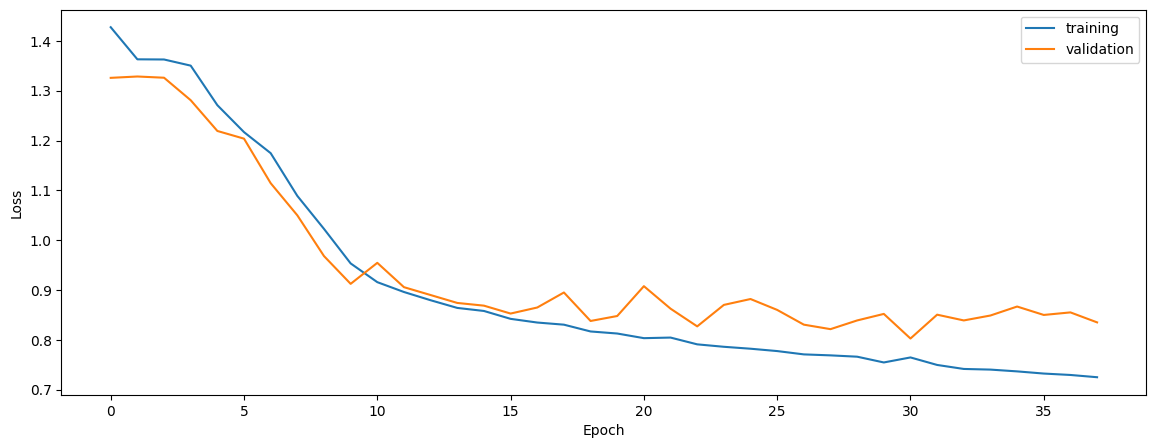

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7030516885467617
0.6868080053089308
0.6559731060151278


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.7030516885467617
0.6868080053089308
0.6559731060151278


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6993267511986502
0.6912290607942781
0.6487745594490582


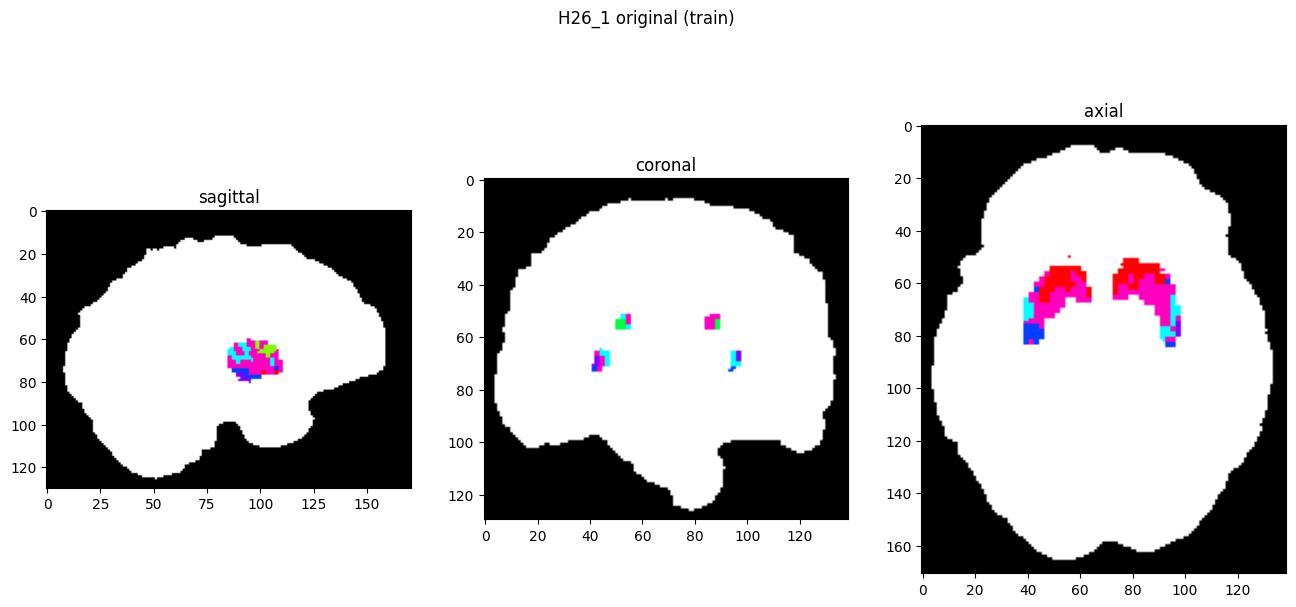

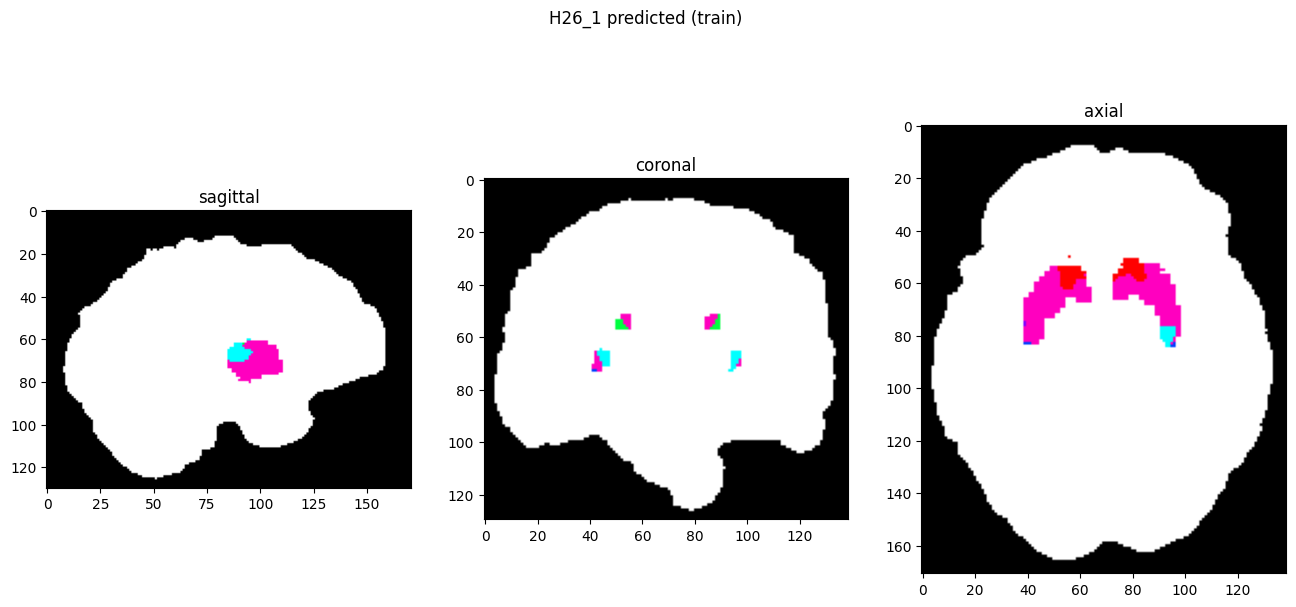

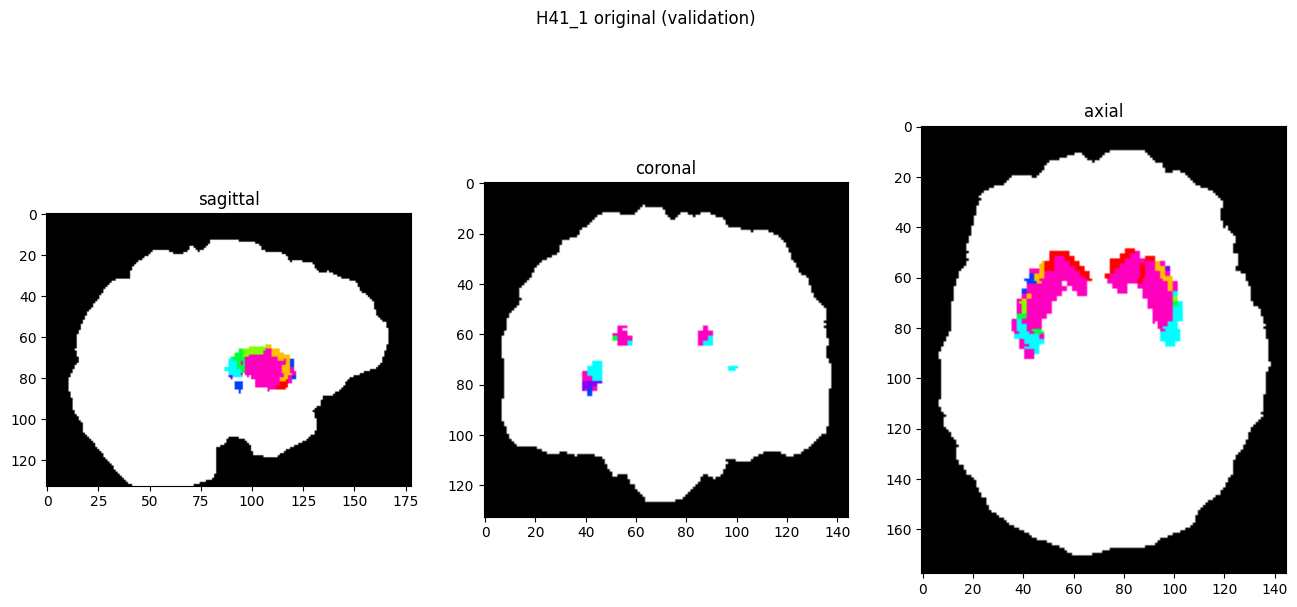

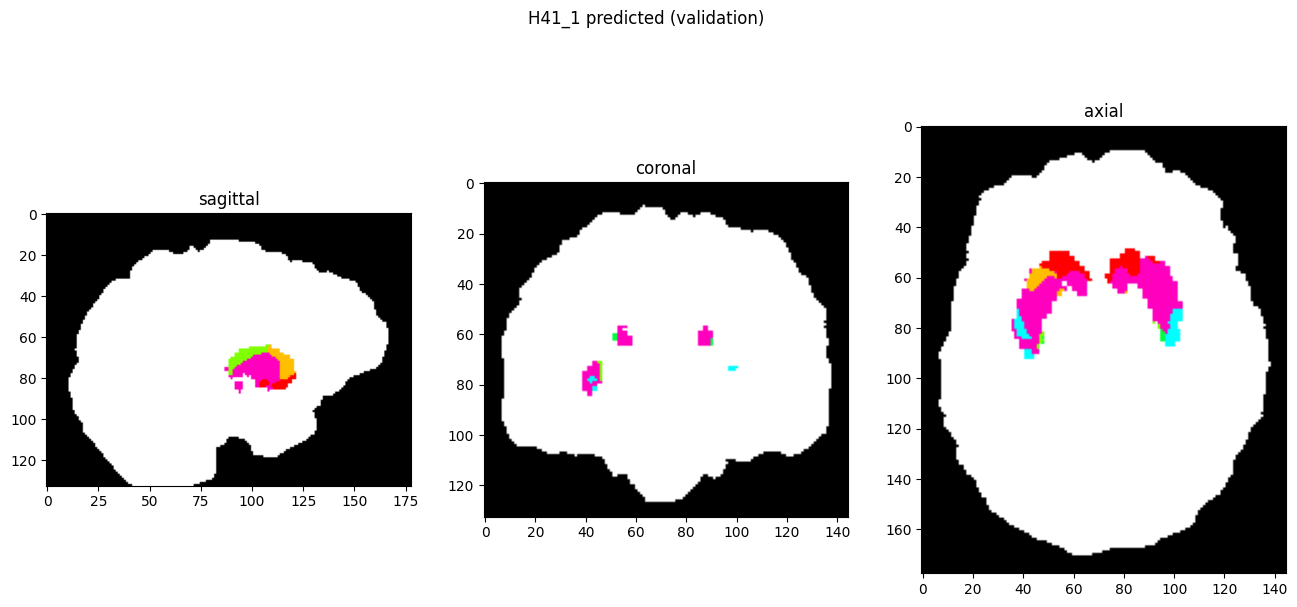

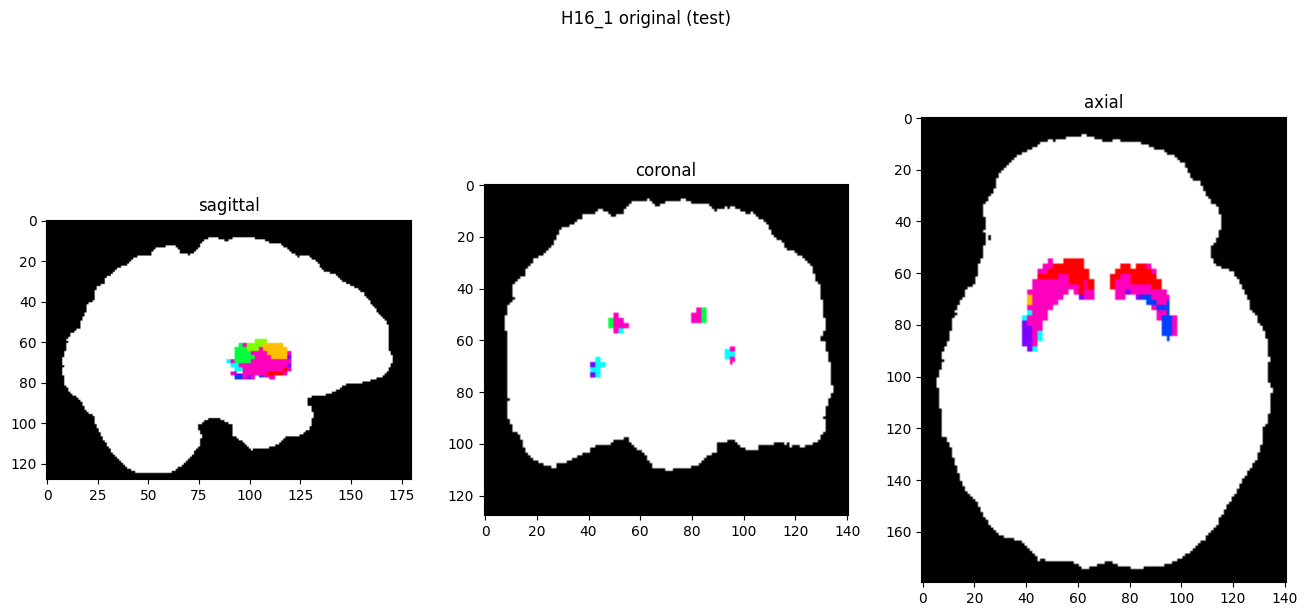

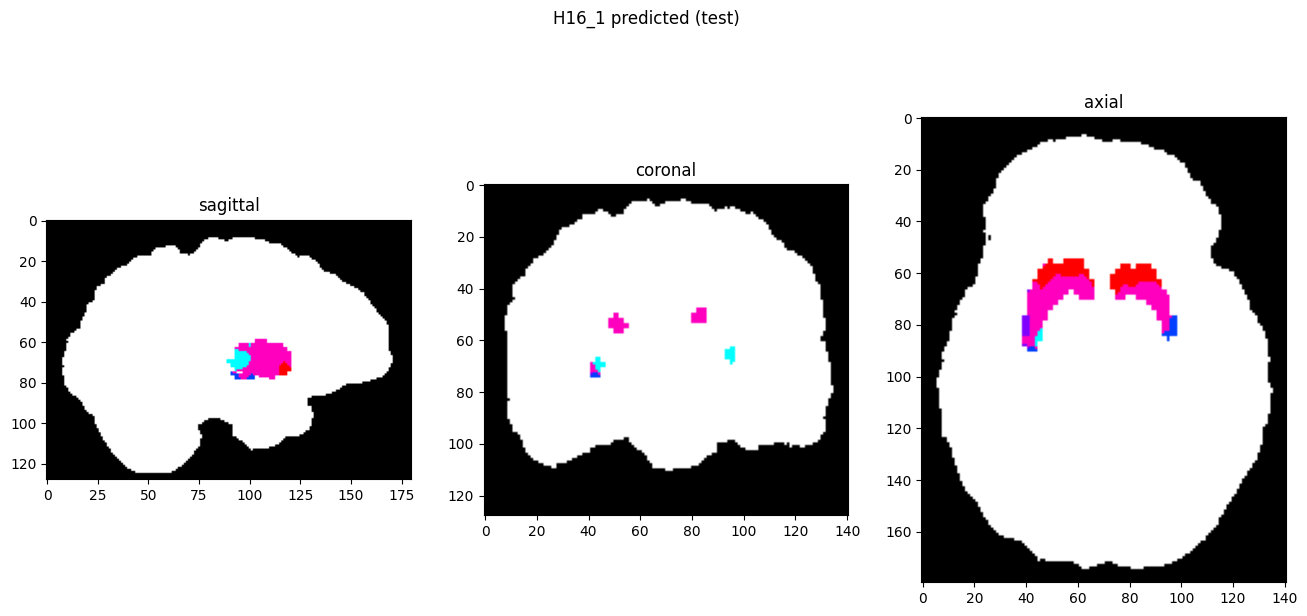

In [10]:
showResults(model, gen, threshold=0)